In [1]:
"""
STAGE 1: Data Preprocessing & COCO Conversion
==========================================================
Converts LabelMe annotations to COCO format
Preprocesses metadata (23 features, NO center, derived class labels)
Creates PATIENT-LEVEL, CENTER-AWARE stratified train/val/test splits

FIXES APPLIED:
✅ Patient-level splitting (prevents data leakage)
✅ Center-aware stratification (controls center bias)
✅ Label-free patient fingerprint (no tumor/benign/malignant)
✅ Includes normal images (tumor=0) with zero annotations

IMPORTANT NOTES:
1. Patient grouping is APPROXIMATED (no explicit patient IDs available)
2. This is PATIENT-LEVEL classification (not lesion or image level)
3. Center used ONLY for stratification (excluded from model inputs)
4. Normal images included for realistic class imbalance

Dataset: BTXRD Bone Tumor X-ray Dataset
"""

import json
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration for Stage 1 preprocessing"""
    
    RAW_IMAGES_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/images"
    RAW_MASKS_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/masks"
    RAW_ANNOTATIONS_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/Annotations"
    METADATA_FILE = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/dataset.xlsx"
    
    OUTPUT_DIR = "preprocessed"
    
    # Splits (70% train, 15% val, 15% test)
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15
    RANDOM_SEED = 42
    
    # Metadata features: 23 features (NO center!)
    METADATA_FEATURES = [
        # Demographics (2 features)
        'age', 'gender',
        
        # Bone locations (9 features)
        'hand', 'ulna', 'radius', 'humerus', 'foot', 
        'tibia', 'fibula', 'femur', 'hip bone',
        
        # Joint involvement (6 features)
        'ankle-joint', 'knee-joint', 'hip-joint', 
        'wrist-joint', 'elbow-joint', 'shoulder-joint',
        
        # Body regions (3 features)
        'upper limb', 'lower limb', 'pelvis',
        
        # X-ray view (3 features)
        'frontal', 'lateral', 'oblique'
    ]
    
    # Label derivation logic:
    # tumor=0 → class_label=0 (Normal)
    # tumor=1, benign=1 → class_label=1 (Benign)
    # tumor=1, malignant=1 → class_label=2 (Malignant)
    CLASS_NAMES = ['Normal', 'Benign', 'Malignant']
    
    # ✅ FIXED: COCO categories (category_id MUST be 1, not 0)
    # Detectron2 internally remaps to 0-indexed, but COCO format requires 1-indexed
    COCO_CATEGORIES = [
        {"id": 1, "name": "tumor", "supercategory": "lesion"}
    ]


# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def create_directory_structure():
    """Create output directory structure"""
    dirs = [
        Config.OUTPUT_DIR,
        f"{Config.OUTPUT_DIR}/coco_annotations",
        f"{Config.OUTPUT_DIR}/metadata_processed",
        f"{Config.OUTPUT_DIR}/splits",
        f"{Config.OUTPUT_DIR}/logs"
    ]
    for d in dirs:
        os.makedirs(d, exist_ok=True)
    print("✅ Directory structure created")


def polygon_to_bbox(points):
    """Convert polygon points to bounding box [x, y, width, height]"""
    points = np.array(points)
    x_min, y_min = points[:, 0].min(), points[:, 1].min()
    x_max, y_max = points[:, 0].max(), points[:, 1].max()
    width = x_max - x_min
    height = y_max - y_min
    return [float(x_min), float(y_min), float(width), float(height)]


def polygon_to_segmentation(points):
    """Convert polygon points to COCO segmentation format"""
    return [float(coord) for point in points for coord in point]


def compute_area(points):
    """Compute polygon area using shoelace formula"""
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))


# ============================================================================
# ANNOTATION CONVERSION (LabelMe → COCO) - **INCLUDES NORMAL IMAGES**
# ============================================================================

def convert_labelme_to_coco(image_ids, split_name):
    """
    Convert LabelMe annotations to COCO format for given image_ids
    
    ✅ FIXED: category_id = 1 (COCO standard)
           Detectron2 internally remaps to 0-indexed for training
    ✅ NEW: Includes normal images (tumor=0) with zero annotations
    ✅ NOTE: image_id is split-local (valid since each split has separate COCO JSON)
    
    Args:
        image_ids: List of image filenames
        split_name: 'train', 'val', or 'test'
    
    Returns:
        dict: COCO format annotations
    """
    
    coco_output = {
        "info": {
            "description": "BTXRD Bone Tumor Dataset",
            "version": "1.0",
            "year": 2026,
            "contributor": "BTXRD Team",
            "date_created": "2026-01-19"
        },
        "licenses": [],
        "categories": Config.COCO_CATEGORIES,
        "images": [],
        "annotations": []
    }
    
    annotation_id = 1
    skipped_images = []
    skipped_reasons = {"no_image": 0}
    normal_images_count = 0  # Track normal images
    
    print(f"\n🔄 Converting {split_name} set: {len(image_ids)} images")
    
    for idx, image_id in enumerate(tqdm(image_ids, desc=f"Processing {split_name}")):
        json_path = Path(Config.RAW_ANNOTATIONS_DIR) / f"{Path(image_id).stem}.json"
        img_path = Path(Config.RAW_IMAGES_DIR) / image_id
        
        # Check image file exists (don't skip if no JSON!)
        if not img_path.exists():
            skipped_images.append(image_id)
            skipped_reasons["no_image"] += 1
            continue
        
        # Get image dimensions
        try:
            img = Image.open(img_path)
            width, height = img.size
            img.close()
        except Exception as e:
            print(f"⚠️  Error opening image {img_path}: {e}")
            skipped_images.append(image_id)
            skipped_reasons["no_image"] += 1
            continue
        
        # ✅ CLARIFICATION: image_id is split-local (idx + 1)
        # This is valid because each split (train/val/test) has its own COCO JSON
        # Global uniqueness is not required across splits
        image_info = {
            "id": idx + 1,  # Split-local ID (starts at 1 per COCO convention)
            "file_name": image_id,
            "width": width,
            "height": height
        }
        coco_output["images"].append(image_info)
        
        # Process annotations IF JSON exists
        if json_path.exists():
            try:
                with open(json_path, 'r', encoding='utf-8') as f:
                    labelme_data = json.load(f)
            except Exception as e:
                print(f"⚠️  Error reading {json_path}: {e}")
                # Image still added above (normal case)
                normal_images_count += 1
                continue
            
            polygon_count = 0
            for shape in labelme_data.get("shapes", []):
                if shape["shape_type"] != "polygon":
                    continue
                
                points = shape["points"]
                if len(points) < 3:
                    continue
                
                try:
                    bbox = polygon_to_bbox(points)
                    segmentation = [polygon_to_segmentation(points)]
                    area = compute_area(points)
                except Exception as e:
                    print(f"⚠️  Error processing polygon in {image_id}: {e}")
                    continue
                
                if area < 100:
                    continue
                
                # ✅ FIXED: category_id = 1 (COCO standard)
                # Detectron2 will internally remap this to 0 during training
                annotation = {
                    "id": annotation_id,
                    "image_id": idx + 1,  # References split-local image_id
                    "category_id": 1,  # ✅ 1 for COCO standard (not 0!)
                    "bbox": bbox,
                    "segmentation": segmentation,
                    "area": float(area),
                    "iscrowd": 0
                }
                coco_output["annotations"].append(annotation)
                annotation_id += 1
                polygon_count += 1
            
            if polygon_count == 0:
                # Image with JSON but no valid polygons → likely normal
                normal_images_count += 1
        else:
            # No JSON → normal image (tumor=0)
            normal_images_count += 1
    
    output_path = Path(Config.OUTPUT_DIR) / "coco_annotations" / f"{split_name}.json"
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(coco_output, f, indent=2)
    
    # Improved statistics
    images_with_annotations = len(set(ann['image_id'] for ann in coco_output['annotations']))
    
    print(f"✅ {split_name}.json saved:")
    print(f"   Total images: {len(coco_output['images'])}")
    print(f"   Images with annotations: {images_with_annotations}")
    print(f"   Images without annotations (normal): {normal_images_count}")
    print(f"   Total annotations: {len(coco_output['annotations'])}")
    print(f"   ℹ️  Note: Normal images included for realistic class imbalance")
    
    if skipped_images:
        print(f"⚠️  Skipped {len(skipped_images)} images:")
        print(f"   - No image file: {skipped_reasons['no_image']}")
        
        skipped_path = Path(Config.OUTPUT_DIR) / "logs" / f"skipped_{split_name}.txt"
        with open(skipped_path, 'w') as f:
            f.write('\n'.join(skipped_images))
    
    return coco_output


# ============================================================================
# PATIENT GROUPING (LABEL-FREE)
# ============================================================================

def create_patient_groups(metadata_df):
    """
    Group images by patient using ONLY non-label features
    
    ⚠️ IMPORTANT LIMITATION:
    Because explicit patient identifiers are unavailable in this dataset,
    patient grouping is APPROXIMATED using demographic and anatomical metadata.
    This may result in limited patient ambiguity in rare edge cases.
    
    Patient fingerprint includes:
    ✅ center (institutional identifier)
    ✅ age (demographic proxy)
    ✅ gender (demographic proxy)
    ✅ anatomy_fingerprint (body location)
    ✅ joint_fingerprint (joint involvement)
    
    ❌ EXCLUDES (prevents label leakage):
    ❌ tumor, benign, malignant (diagnostic labels)
    
    📌 FOR PUBLICATION:
    Add this to Methods section:
    "Because explicit patient identifiers were unavailable, patient grouping was
    approximated using demographic and anatomical metadata, which may result in
    limited patient ambiguity in rare cases."
    
    Returns:
        DataFrame with patient_id column
    """
    
    df = metadata_df.copy()
    
    # Verify required columns
    required_cols = ['center', 'age', 'gender']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        print(f"❌ ERROR: Missing required columns: {missing}")
        return None
    
    # Create anatomical fingerprint (bone location)
    anatomy_cols = ['hand', 'ulna', 'radius', 'humerus', 'foot', 
                    'tibia', 'fibula', 'femur', 'hip bone']
    available_anatomy = [col for col in anatomy_cols if col in df.columns]
    
    if not available_anatomy:
        print(f"⚠️  WARNING: No anatomy columns found!")
        df['anatomy_fingerprint'] = '0'
    else:
        df['anatomy_fingerprint'] = df[available_anatomy].astype(str).agg(''.join, axis=1)
    
    # Create joint fingerprint (joint involvement)
    joint_cols = ['ankle-joint', 'knee-joint', 'hip-joint', 
                  'wrist-joint', 'elbow-joint', 'shoulder-joint']
    available_joints = [col for col in joint_cols if col in df.columns]
    
    if not available_joints:
        print(f"⚠️  WARNING: No joint columns found!")
        df['joint_fingerprint'] = '0'
    else:
        df['joint_fingerprint'] = df[available_joints].astype(str).agg(''.join, axis=1)
    
    # ✅ Patient fingerprint WITHOUT labels (prevents leakage)
    df['patient_fingerprint'] = (
        df['center'].astype(str) + '_' +
        df['age'].astype(str) + '_' +
        df['gender'] + '_' +
        df['anatomy_fingerprint'] + '_' +
        df['joint_fingerprint']
    )
    
    # Assign patient IDs
    patient_id = 0
    patient_mapping = {}
    
    for fingerprint, group in df.groupby('patient_fingerprint'):
        patient_id += 1
        for img_id in group['image_id']:
            patient_mapping[img_id] = patient_id
    
    df['patient_id'] = df['image_id'].map(patient_mapping)
    
    # Statistics
    print(f"\n📊 Patient grouping statistics:")
    print(f"   Total images: {len(df)}")
    print(f"   Unique patients: {df['patient_id'].nunique()}")
    print(f"   Avg images per patient: {len(df) / df['patient_id'].nunique():.2f}")
    
    # Multi-view patients
    patient_counts = df.groupby('patient_id').size()
    multi_image_patients = (patient_counts > 1).sum()
    print(f"   Patients with multiple views: {multi_image_patients}")
    
    # Center distribution
    print(f"\n   Center distribution (by patient):")
    center_dist = df.groupby('center')['patient_id'].nunique()
    for center, count in center_dist.items():
        pct = count / df['patient_id'].nunique() * 100
        img_count = len(df[df['center'] == center])
        print(f"     Center {center}: {count} patients, {img_count} images ({pct:.1f}%)")
    
    # ✅ Collision analysis (explicitly report potential ambiguity)
    print(f"\n   Patient identity collision analysis:")
    df['weak_fingerprint'] = (
        df['center'].astype(str) + '_' +
        df['age'].astype(str) + '_' +
        df['gender']
    )
    weak_groups = df['weak_fingerprint'].nunique()
    full_groups = df['patient_fingerprint'].nunique()
    
    collision_prevention = full_groups - weak_groups
    if collision_prevention > 0:
        print(f"     Center+age+gender only: {weak_groups} groups")
        print(f"     Full fingerprint (with anatomy): {full_groups} groups")
        print(f"     ✅ Anatomy prevents {collision_prevention} potential collisions ({collision_prevention/weak_groups*100:.1f}%)")
    else:
        print(f"     ℹ️  Anatomy adds no separation (all patients unique by demographics)")
    
    # Explicitly state limitation
    print(f"\n   ⚠️  LIMITATION (report in paper):")
    print(f"      Patient IDs are APPROXIMATED (no explicit identifiers available)")
    print(f"      Rare edge cases may have patient ambiguity")
    print(f"      This is acceptable if stated in Methods section")
    
    # Verify no label leakage
    print(f"\n   ✅ Patient fingerprint is LABEL-FREE:")
    print(f"      Includes: center, age, gender, anatomy, joints")
    print(f"      Excludes: tumor, benign, malignant (no label leakage)")
    
    if multi_image_patients > 0:
        print(f"\n   ✅ Multi-view patients detected (will prevent leakage)")
        example_patient = patient_counts[patient_counts > 1].index[0]
        example_images = df[df['patient_id'] == example_patient][
            ['image_id', 'frontal', 'lateral', 'oblique', 'age', 'gender', 'center']
        ].head(5)
        print(f"\n   Example patient {example_patient} (multi-view):")
        print(example_images.to_string(index=False))
    
    # Clean up temporary columns
    df = df.drop(['anatomy_fingerprint', 'joint_fingerprint', 'patient_fingerprint', 'weak_fingerprint'], axis=1)
    
    return df


# ============================================================================
# STRATIFICATION HELPER
# ============================================================================

def stratify_by_class_and_center(patient_groups):
    """
    Stratified splitting by BOTH class AND center
    
    📌 FOR PUBLICATION:
    Add to Methods: "Splits were stratified by both diagnostic class and
    acquisition center to control for center bias."
    
    Args:
        patient_groups: DataFrame with [patient_id, class_label, center, image_id]
    
    Returns:
        train_patients, val_patients, test_patients
    """
    
    # Create composite stratification key
    patient_groups['strat_key'] = (
        patient_groups['class_label'].astype(str) + '_' + 
        patient_groups['center'].astype(str)
    )
    
    # Check stratification groups
    strat_counts = patient_groups['strat_key'].value_counts()
    print(f"\n   Stratification groups (class_center):")
    for key, count in strat_counts.items():
        cls, center = key.split('_')
        cls_name = Config.CLASS_NAMES[int(cls)]
        print(f"     {cls_name}, Center {center}: {count} patients")
    
    # Warn about small strata
    min_samples_needed = 3
    small_strata = strat_counts[strat_counts < min_samples_needed]
    if len(small_strata) > 0:
        print(f"\n   ⚠️  Warning: {len(small_strata)} strata have <{min_samples_needed} patients")
        print(f"      Will use relaxed stratification for these")
    
    # Try full stratification
    try:
        X = patient_groups['patient_id'].values
        y_strat = patient_groups['strat_key'].values
        
        # Split: (Train+Val) / Test
        X_temp, X_test, _, _ = train_test_split(
            X, X,
            test_size=Config.TEST_RATIO,
            stratify=y_strat,
            random_state=Config.RANDOM_SEED
        )
        
        # Get stratification keys for temp set
        y_strat_temp = patient_groups[patient_groups['patient_id'].isin(X_temp)]['strat_key'].values
        
        # Split: Train / Val
        val_ratio_adjusted = Config.VAL_RATIO / (Config.TRAIN_RATIO + Config.VAL_RATIO)
        X_train, X_val, _, _ = train_test_split(
            X_temp, X_temp,
            test_size=val_ratio_adjusted,
            stratify=y_strat_temp,
            random_state=Config.RANDOM_SEED
        )
        
        print(f"   ✅ Full center+class stratification successful")
        
    except ValueError as e:
        print(f"   ⚠️  Full stratification failed: {e}")
        print(f"   Falling back to class-only stratification")
        
        X = patient_groups['patient_id'].values
        y_class = patient_groups['class_label'].values
        
        X_temp, X_test, _, _ = train_test_split(
            X, X,
            test_size=Config.TEST_RATIO,
            stratify=y_class,
            random_state=Config.RANDOM_SEED
        )
        
        y_class_temp = patient_groups[patient_groups['patient_id'].isin(X_temp)]['class_label'].values
        val_ratio_adjusted = Config.VAL_RATIO / (Config.TRAIN_RATIO + Config.VAL_RATIO)
        X_train, X_val, _, _ = train_test_split(
            X_temp, X_temp,
            test_size=val_ratio_adjusted,
            stratify=y_class_temp,
            random_state=Config.RANDOM_SEED
        )
    
    return X_train, X_val, X_test


# ============================================================================
# DATASET SPLITTING (PATIENT-LEVEL, CENTER-AWARE)
# ============================================================================

def derive_class_label(row):
    """
    Derive class label from tumor/benign/malignant columns
    
    📌 FOR PUBLICATION:
    This implements PATIENT-LEVEL classification (not lesion-level).
    Each patient is assigned ONE dominant diagnosis.
    """
    if row['tumor'] == 0:
        return 0  # Normal
    elif row['tumor'] == 1 and row['benign'] == 1:
        return 1  # Benign
    elif row['tumor'] == 1 and row['malignant'] == 1:
        return 2  # Malignant
    else:
        return -1  # Invalid


def create_stratified_splits(metadata_df):
    """
    Create patient-level, center-aware stratified splits
    
    ✅ Patient-level (not image-level) - prevents data leakage
    ✅ Center-aware stratification - controls center bias
    ✅ Label-free patient fingerprint - no label information used for grouping
    ✅ Includes ALL images (even without annotation JSONs)
    
    📌 FOR PUBLICATION - Add these to Methods:
    1. "Splits were performed at the patient level (not image level) to prevent
       data leakage from multiple views of the same patient."
    2. "Center information was used only for stratified splitting and excluded
       from model inputs to avoid center-specific overfitting."
    3. "For patients with multiple images, patient-level labels were assigned
       via majority voting."
    
    Returns:
        dict: {'train': [image_ids], 'val': [image_ids], 'test': [image_ids]}
    """
    
    # Verify center column
    if 'center' not in metadata_df.columns:
        print("❌ ERROR: 'center' column not found in metadata!")
        print("   Available columns:", metadata_df.columns.tolist())
        return None
    
    # Filter by image file existence (NOT JSON existence!)
    valid_image_ids = []
    for img_id in metadata_df['image_id']:
        img_path = Path(Config.RAW_IMAGES_DIR) / img_id
        if img_path.exists():  # Only check image exists, not JSON
            valid_image_ids.append(img_id)
    
    df_valid = metadata_df[metadata_df['image_id'].isin(valid_image_ids)].copy()
    
    # Derive class labels
    df_valid['class_label'] = df_valid.apply(derive_class_label, axis=1)
    df_valid = df_valid[df_valid['class_label'] != -1]
    
    # Group by patient (label-free)
    df_valid = create_patient_groups(df_valid)
    
    if df_valid is None:
        return None
    
    # Dataset statistics
    print(f"\n📊 Dataset Statistics (BEFORE splitting):")
    print(f"   Total images: {len(df_valid)}")
    print(f"   Unique patients: {df_valid['patient_id'].nunique()}")
    print(f"   Centers: {sorted(df_valid['center'].unique())}")
    
    print(f"\n   Class distribution (by image):")
    class_dist = df_valid['class_label'].value_counts().sort_index()
    for cls_id, count in class_dist.items():
        cls_name = Config.CLASS_NAMES[cls_id]
        pct = count / len(df_valid) * 100
        print(f"     {cls_name}: {count} images ({pct:.1f}%)")
    
    # ✅ Aggregate patient-level info using MAJORITY VOTING
    # 📌 FOR PUBLICATION: "For patients with multiple images, patient-level
    #    labels were assigned via majority voting."
    patient_groups = df_valid.groupby('patient_id').agg({
        'class_label': lambda x: x.mode()[0],  # Majority vote
        'center': lambda x: x.mode()[0],        # Most common center
        'image_id': list
    }).reset_index()
    
    print(f"\n   Class distribution (by patient - majority voting):")
    patient_class_dist = patient_groups['class_label'].value_counts().sort_index()
    for cls_id, count in patient_class_dist.items():
        cls_name = Config.CLASS_NAMES[cls_id]
        pct = count / len(patient_groups) * 100
        print(f"     {cls_name}: {count} patients ({pct:.1f}%)")
    
    print(f"\n   Center distribution (by patient):")
    patient_center_dist = patient_groups['center'].value_counts().sort_index()
    for center, count in patient_center_dist.items():
        pct = count / len(patient_groups) * 100
        print(f"     Center {center}: {count} patients ({pct:.1f}%)")
    
    # Stratified split by CLASS + CENTER
    print(f"\n🔀 Performing patient-level, center-aware stratified split...")
    patients_train, patients_val, patients_test = stratify_by_class_and_center(patient_groups)
    
    # Map patients → images
    train_images = patient_groups[patient_groups['patient_id'].isin(patients_train)]['image_id'].explode().tolist()
    val_images = patient_groups[patient_groups['patient_id'].isin(patients_val)]['image_id'].explode().tolist()
    test_images = patient_groups[patient_groups['patient_id'].isin(patients_test)]['image_id'].explode().tolist()
    
    splits = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }
    
    # Save splits
    print(f"\n💾 Saving splits:")
    for split_name, image_ids in splits.items():
        num_patients = len(set(df_valid[df_valid['image_id'].isin(image_ids)]['patient_id']))
        output_path = Path(Config.OUTPUT_DIR) / "splits" / f"{split_name}.txt"
        with open(output_path, 'w') as f:
            f.write('\n'.join(image_ids))
        print(f"   {split_name}.txt: {num_patients} patients, {len(image_ids)} images")
    
    # Validate split integrity
    print(f"\n🔍 Validating split integrity...")
    
    # Check 1: No patient overlap
    train_patients_set = set(df_valid[df_valid['image_id'].isin(train_images)]['patient_id'])
    val_patients_set = set(df_valid[df_valid['image_id'].isin(val_images)]['patient_id'])
    test_patients_set = set(df_valid[df_valid['image_id'].isin(test_images)]['patient_id'])
    
    overlap_train_val = train_patients_set & val_patients_set
    overlap_train_test = train_patients_set & test_patients_set
    overlap_val_test = val_patients_set & test_patients_set
    
    if len(overlap_train_val) == 0 and len(overlap_train_test) == 0 and len(overlap_val_test) == 0:
        print(f"   ✅ PASS: No patient appears in multiple splits")
    else:
        print(f"   ❌ FAIL: Patient overlap detected!")
        print(f"      Train-Val: {len(overlap_train_val)}, Train-Test: {len(overlap_train_test)}, Val-Test: {len(overlap_val_test)}")
    
    # Check 2: Class distribution by split
    print(f"\n   Class distribution by split:")
    for split_name, image_ids in splits.items():
        split_df = df_valid[df_valid['image_id'].isin(image_ids)]
        print(f"\n   {split_name.upper()}:")
        for cls_id in range(len(Config.CLASS_NAMES)):
            cls_count = (split_df['class_label'] == cls_id).sum()
            patient_count = split_df[split_df['class_label'] == cls_id]['patient_id'].nunique()
            pct = cls_count / len(split_df) * 100
            print(f"     {Config.CLASS_NAMES[cls_id]}: {patient_count} patients, {cls_count} images ({pct:.1f}%)")
    
    # Check 3: Center distribution by split
    print(f"\n   Center distribution by split:")
    for split_name, image_ids in splits.items():
        split_df = df_valid[df_valid['image_id'].isin(image_ids)]
        print(f"\n   {split_name.upper()}:")
        for center in sorted(df_valid['center'].unique()):
            center_count = (split_df['center'] == center).sum()
            patient_count = split_df[split_df['center'] == center]['patient_id'].nunique()
            pct = center_count / len(split_df) * 100
            print(f"     Center {center}: {patient_count} patients, {center_count} images ({pct:.1f}%)")
    
    # Save patient mapping
    patient_map_path = Path(Config.OUTPUT_DIR) / "splits" / "patient_mapping.csv"
    df_valid[['image_id', 'patient_id', 'class_label', 'center', 'age', 'gender', 'frontal', 'lateral', 'oblique']].to_csv(
        patient_map_path, index=False
    )
    print(f"\n   Saved patient_mapping.csv for reference")
    
    print(f"\n✅ Patient-level, center-aware splitting complete!")
    print(f"   ✅ Data leakage prevented!")
    print(f"   ✅ Center bias controlled!")
    print(f"   ✅ Normal images (tumor=0) included!")
    
    return splits


# ============================================================================
# METADATA PREPROCESSING
# ============================================================================

def preprocess_metadata(metadata_df, image_ids, split_name, scaler=None):
    """
    Preprocess metadata for given image_ids
    23 features (NO center - used for splitting only)
    
    📌 FOR PUBLICATION:
    "Center information was used only for stratified splitting and excluded
    from model inputs to avoid center-specific overfitting."
    """
    
    df_split = metadata_df[metadata_df['image_id'].isin(image_ids)].copy()
    
    print(f"\n🧹 Preprocessing {split_name} metadata: {len(df_split)} samples")
    
    # Derive class labels
    df_split['class_label'] = df_split.apply(derive_class_label, axis=1)
    
    invalid_count = (df_split['class_label'] == -1).sum()
    if invalid_count > 0:
        print(f"⚠️  Removing {invalid_count} samples with invalid labels")
        df_split = df_split[df_split['class_label'] != -1]
    
    # Select features (23 features, NO center)
    features = Config.METADATA_FEATURES.copy()
    X = df_split[features].copy()
    
    # Encode gender
    X['gender'] = X['gender'].map({'M': 1, 'F': 0})
    if X['gender'].isna().any():
        print(f"⚠️  Warning: {X['gender'].isna().sum()} samples with invalid gender")
        X['gender'].fillna(0, inplace=True)
    
    # Normalize age
    if scaler is None:
        scaler = StandardScaler()
        X['age'] = scaler.fit_transform(X[['age']])
        print(f"   Age normalization: mean={scaler.mean_[0]:.2f}, std={scaler.scale_[0]:.2f}")
    else:
        X['age'] = scaler.transform(X[['age']])
    
    # Combine
    df_output = pd.concat([
        df_split[['image_id']].reset_index(drop=True),
        X.reset_index(drop=True),
        df_split[['class_label']].reset_index(drop=True)
    ], axis=1)
    
    # Class distribution
    class_dist = df_output['class_label'].value_counts().sort_index()
    print(f"   Class distribution:")
    for cls_id, count in class_dist.items():
        cls_name = Config.CLASS_NAMES[cls_id]
        pct = count / len(df_output) * 100
        print(f"     {cls_name}: {count} ({pct:.1f}%)")
    
    # Save
    output_path = Path(Config.OUTPUT_DIR) / "metadata_processed" / f"metadata_{split_name}.csv"
    df_output.to_csv(output_path, index=False)
    print(f"✅ metadata_{split_name}.csv saved: {len(df_output)} samples")
    
    return df_output, scaler


# ============================================================================
# STATISTICS
# ============================================================================

def generate_statistics(metadata_df, splits, coco_data):
    """
    Generate and save dataset statistics
    
    ✅ FIXED: Now filters metadata to only include images from splits
           before generating patient statistics (prevents phantom patients)
    """
    
    # ✅ FIX: Filter metadata to only include images from splits
    all_split_images = []
    for image_ids in splits.values():
        all_split_images.extend(image_ids)
    
    metadata_filtered = metadata_df[metadata_df['image_id'].isin(all_split_images)].copy()
    
    # ✅ FIX: Derive class labels on filtered data
    metadata_filtered['class_label'] = metadata_filtered.apply(derive_class_label, axis=1)
    metadata_filtered = metadata_filtered[metadata_filtered['class_label'] != -1]
    
    # Count patients per split
    df_with_patients = create_patient_groups(metadata_filtered)
    
    if df_with_patients is None:
        print("⚠️  Cannot generate statistics without patient grouping")
        return {}
    
    def count_patients(image_ids):
        return df_with_patients[df_with_patients['image_id'].isin(image_ids)]['patient_id'].nunique()
    
    def count_centers(image_ids):
        return df_with_patients[df_with_patients['image_id'].isin(image_ids)]['center'].nunique()
    
    stats = {
        "dataset_info": {
            "name": "BTXRD Bone Tumor Dataset",
            "date_processed": "2026-01-19",
            "total_samples_metadata": len(metadata_df),
            "valid_samples": sum(len(ids) for ids in splits.values()),
            "splitting_strategy": "patient-level with center-aware stratification",
            "multi_center": True,
            "num_centers": int(df_with_patients['center'].nunique()),
            "includes_normal_images": True
        },
        "splits": {
            "train_images": len(splits['train']),
            "train_patients": count_patients(splits['train']),
            "train_centers": count_centers(splits['train']),
            "val_images": len(splits['val']),
            "val_patients": count_patients(splits['val']),
            "val_centers": count_centers(splits['val']),
            "test_images": len(splits['test']),
            "test_patients": count_patients(splits['test']),
            "test_centers": count_centers(splits['test']),
            "train_ratio": Config.TRAIN_RATIO,
            "val_ratio": Config.VAL_RATIO,
            "test_ratio": Config.TEST_RATIO
        },
        "annotations": {
            "train_images": len(coco_data['train']['images']),
            "train_annotations": len(coco_data['train']['annotations']),
            "val_images": len(coco_data['val']['images']),
            "val_annotations": len(coco_data['val']['annotations']),
            "test_images": len(coco_data['test']['images']),
            "test_annotations": len(coco_data['test']['annotations'])
        },
        "metadata": {
            "num_features": len(Config.METADATA_FEATURES),
            "features": Config.METADATA_FEATURES,
            "excluded_feature": "center (used for stratification only)"
        },
        "classes": {
            "names": Config.CLASS_NAMES,
            "mapping": {"Normal": 0, "Benign": 1, "Malignant": 2}
        },
        "coco_format": {
            "category_id": 1,
            "note": "COCO standard requires category_id starting at 1. Detectron2 internally remaps to 0-indexed."
        },
        "data_leakage_prevention": {
            "splitting_level": "patient (not image or lesion)",
            "stratification": "class + center",
            "patient_fingerprint": "label-free (center, age, gender, anatomy, joints)",
            "patient_label_assignment": "majority voting for multi-image patients",
            "description": "All views of same patient kept in same split. Center distribution preserved. Normal images (tumor=0) included.",
            "validation": "No patient appears in multiple splits",
            "limitation": "Patient IDs approximated from demographics (no explicit identifiers available)"
        }
    }
    
    output_path = Path(Config.OUTPUT_DIR) / "statistics.json"
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(stats, f, indent=2)
    
    print(f"✅ statistics.json saved")
    
    return stats


# ============================================================================
# VALIDATION
# ============================================================================

def validate_alignment(splits):
    """Validate sample-level alignment"""
    print(f"\n🔍 Validating file alignment...")
    
    all_image_ids = []
    for split_name, image_ids in splits.items():
        all_image_ids.extend(image_ids)
    
    missing_files = {"images": 0, "masks": 0, "jsons": 0}
    
    for img_id in tqdm(all_image_ids, desc="Validating"):
        img_path = Path(Config.RAW_IMAGES_DIR) / img_id
        mask_path = Path(Config.RAW_MASKS_DIR) / f"{Path(img_id).stem}_mask.png"
        json_path = Path(Config.RAW_ANNOTATIONS_DIR) / f"{Path(img_id).stem}.json"
        
        if not img_path.exists():
            missing_files["images"] += 1
        if not mask_path.exists():
            missing_files["masks"] += 1
        if not json_path.exists():
            missing_files["jsons"] += 1
    
    print(f"✅ Alignment validation complete:")
    print(f"   Missing images: {missing_files['images']}")
    print(f"   Missing masks: {missing_files['masks']}")
    print(f"   Missing JSONs: {missing_files['jsons']} (expected for normal images)")


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """Execute complete Stage 1 preprocessing pipeline"""
    
    print("=" * 80)
    print("STAGE 1: DATA PREPROCESSING & COCO CONVERSION (PRODUCTION-READY)")
    print("=" * 80)
    print("✅ category_id: 1 (COCO standard) - Detectron2 remaps internally")
    print("✅ Patient-level splitting (prevents data leakage)")
    print("✅ Center-aware stratification (controls center bias)")
    print("✅ Label-free patient fingerprint (no tumor/benign/malignant)")
    print("✅ Includes normal images (tumor=0) with zero annotations")
    print("✅ Explicit documentation of methodological choices")
    print("=" * 80)
    print("\n📌 FOR PUBLICATION - ADD THESE TO METHODS:")
    print("1. Patient IDs approximated (no explicit identifiers)")
    print("2. Majority voting for multi-image patients")
    print("3. Center excluded from model inputs")
    print("4. Normal images included for class imbalance")
    print("=" * 80)
    
    # Step 1: Create directories
    print("\n[1/6] Creating directory structure...")
    create_directory_structure()
    
    # Step 2: Load metadata
    print("\n[2/6] Loading metadata...")
    metadata_df = pd.read_excel(Config.METADATA_FILE)
    print(f"✅ Loaded {len(metadata_df)} samples from metadata")
    
    # Verify columns
    required_cols = ['image_id', 'tumor', 'benign', 'malignant', 'center'] + Config.METADATA_FEATURES
    missing_cols = set(required_cols) - set(metadata_df.columns)
    if missing_cols:
        print(f"❌ ERROR: Missing columns: {missing_cols}")
        return
    
    # Step 3: Create patient-level, center-aware splits
    print("\n[3/6] Creating patient-level, center-aware stratified splits...")
    splits = create_stratified_splits(metadata_df)
    
    if splits is None:
        print("❌ ERROR: Splitting failed!")
        return
    
    # Step 4: Convert to COCO format
    print("\n[4/6] Converting annotations to COCO format...")
    coco_data = {}
    for split_name, image_ids in splits.items():
        coco_data[split_name] = convert_labelme_to_coco(image_ids, split_name)
    
    # Step 5: Preprocess metadata
    print("\n[5/6] Preprocessing metadata (23 features, NO center)...")
    scaler = None
    for split_name in ['train', 'val', 'test']:
        image_ids = splits[split_name]
        _, scaler = preprocess_metadata(metadata_df, image_ids, split_name, scaler)
    
    # Step 6: Validate and generate statistics
    print("\n[6/6] Validation and statistics...")
    validate_alignment(splits)
    stats = generate_statistics(metadata_df, splits, coco_data)
    
    # Final summary
    print("\n" + "=" * 80)
    print("✅ STAGE 1 COMPLETE - PRODUCTION-READY!")
    print("=" * 80)
    print(f"\nOutputs saved to: {Config.OUTPUT_DIR}/")
    print(f"  ├── coco_annotations/")
    print(f"  │   ├── train.json ({stats['annotations']['train_images']} images, {stats['annotations']['train_annotations']} annotations)")
    print(f"  │   ├── val.json ({stats['annotations']['val_images']} images, {stats['annotations']['val_annotations']} annotations)")
    print(f"  │   └── test.json ({stats['annotations']['test_images']} images, {stats['annotations']['test_annotations']} annotations)")
    print(f"  ├── metadata_processed/")
    print(f"  │   ├── metadata_train.csv ({stats['splits']['train_patients']} patients, {stats['splits']['train_images']} images)")
    print(f"  │   ├── metadata_val.csv ({stats['splits']['val_patients']} patients, {stats['splits']['val_images']} images)")
    print(f"  │   └── metadata_test.csv ({stats['splits']['test_patients']} patients, {stats['splits']['test_images']} images)")
    print(f"  ├── splits/")
    print(f"  │   ├── train.txt, val.txt, test.txt")
    print(f"  │   └── patient_mapping.csv")
    print(f"  └── statistics.json")
    print(f"\n📊 Dataset Summary:")
    print(f"  Total patients: {stats['splits']['train_patients'] + stats['splits']['val_patients'] + stats['splits']['test_patients']}")
    print(f"  Train: {stats['splits']['train_patients']} patients, {stats['splits']['train_images']} images")
    print(f"  Val: {stats['splits']['val_patients']} patients, {stats['splits']['val_images']} images")
    print(f"  Test: {stats['splits']['test_patients']} patients, {stats['splits']['test_images']} images")
    print(f"  Centers: {stats['dataset_info']['num_centers']}")
    print(f"  Metadata features: {stats['metadata']['num_features']}")
    print(f"\n✅ All critical fixes applied:")
    print(f"  ✅ category_id = 1 (COCO standard, Detectron2 compatible)")
    print(f"  ✅ Split-local image IDs (documented)")
    print(f"  ✅ Patient collision risk acknowledged and mitigated")
    print(f"  ✅ Majority voting documented")
    print(f"  ✅ Patient-level splitting (no leakage)")
    print(f"  ✅ Center-aware stratification")
    print(f"  ✅ Normal images included in COCO JSON")
    print(f"\n🎯 Ready for Stage 2: Mask R-CNN Training")
    print(f"🔥 Q1/Q2 Publication-Ready Preprocessing Pipeline")
    print("=" * 80)


if __name__ == "__main__":
    main()


STAGE 1: DATA PREPROCESSING & COCO CONVERSION (PRODUCTION-READY)
✅ category_id: 1 (COCO standard) - Detectron2 remaps internally
✅ Patient-level splitting (prevents data leakage)
✅ Center-aware stratification (controls center bias)
✅ Label-free patient fingerprint (no tumor/benign/malignant)
✅ Includes normal images (tumor=0) with zero annotations
✅ Explicit documentation of methodological choices

📌 FOR PUBLICATION - ADD THESE TO METHODS:
1. Patient IDs approximated (no explicit identifiers)
2. Majority voting for multi-image patients
3. Center excluded from model inputs
4. Normal images included for class imbalance

[1/6] Creating directory structure...
✅ Directory structure created

[2/6] Loading metadata...
✅ Loaded 3746 samples from metadata

[3/6] Creating patient-level, center-aware stratified splits...

📊 Patient grouping statistics:
   Total images: 3746
   Unique patients: 1008
   Avg images per patient: 3.72
   Patients with multiple views: 688

   Center distribution (by pa

Processing train: 100%|██████████| 2602/2602 [00:20<00:00, 127.46it/s]


✅ train.json saved:
   Total images: 2602
   Images with annotations: 1285
   Images without annotations (normal): 1317
   Total annotations: 1617
   ℹ️  Note: Normal images included for realistic class imbalance

🔄 Converting val set: 580 images


Processing val: 100%|██████████| 580/580 [00:04<00:00, 134.93it/s]


✅ val.json saved:
   Total images: 580
   Images with annotations: 296
   Images without annotations (normal): 284
   Total annotations: 364
   ℹ️  Note: Normal images included for realistic class imbalance

🔄 Converting test set: 564 images


Processing test: 100%|██████████| 564/564 [00:04<00:00, 136.81it/s]


✅ test.json saved:
   Total images: 564
   Images with annotations: 286
   Images without annotations (normal): 278
   Total annotations: 337
   ℹ️  Note: Normal images included for realistic class imbalance

[5/6] Preprocessing metadata (23 features, NO center)...

🧹 Preprocessing train metadata: 2602 samples
   Age normalization: mean=34.34, std=20.81
   Class distribution:
     Normal: 1317 (50.6%)
     Benign: 1050 (40.4%)
     Malignant: 235 (9.0%)
✅ metadata_train.csv saved: 2602 samples

🧹 Preprocessing val metadata: 580 samples
   Class distribution:
     Normal: 284 (49.0%)
     Benign: 236 (40.7%)
     Malignant: 60 (10.3%)
✅ metadata_val.csv saved: 580 samples

🧹 Preprocessing test metadata: 564 samples
   Class distribution:
     Normal: 278 (49.3%)
     Benign: 239 (42.4%)
     Malignant: 47 (8.3%)
✅ metadata_test.csv saved: 564 samples

[6/6] Validation and statistics...

🔍 Validating file alignment...


Validating: 100%|██████████| 3746/3746 [00:09<00:00, 388.33it/s]


✅ Alignment validation complete:
   Missing images: 0
   Missing masks: 1879
   Missing JSONs: 1879 (expected for normal images)

📊 Patient grouping statistics:
   Total images: 3746
   Unique patients: 1008
   Avg images per patient: 3.72
   Patients with multiple views: 688

   Center distribution (by patient):
     Center 1: 698 patients, 2938 images (69.2%)
     Center 2: 173 patients, 549 images (17.2%)
     Center 3: 137 patients, 259 images (13.6%)

   Patient identity collision analysis:
     Center+age+gender only: 295 groups
     Full fingerprint (with anatomy): 1008 groups
     ✅ Anatomy prevents 713 potential collisions (241.7%)

   ⚠️  LIMITATION (report in paper):
      Patient IDs are APPROXIMATED (no explicit identifiers available)
      Rare edge cases may have patient ambiguity
      This is acceptable if stated in Methods section

   ✅ Patient fingerprint is LABEL-FREE:
      Includes: center, age, gender, anatomy, joints
      Excludes: tumor, benign, malignant (no 

In [2]:
# Cell 1: Installation ONLY (run this first)
!pip install -U torch torchvision
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.8 MB/s eta 0:00:00:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 19.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 27.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 21.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.1 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━

In [ ]:
"""
STAGE 2: REGULAR Mask R-CNN Training (FINAL - ALL BUGS FIXED)
===============================================================================
🎯 MODEL: Regular Mask R-CNN (Single-stage detection)
✅ ALL CRITICAL FIXES APPLIED

Regular Mask R-CNN Benefits:
- Faster training and inference
- Single-stage detection (IoU threshold: 0.5)
- Good baseline performance
- Less computational cost

CRITICAL FIXES SUMMARY:
=======================
1. Image Size Mismatch: Train and eval now both use 800×1024
2. CLAHE Conversion: Handles normalized float images [0,1] correctly
3. Optimizer Rebuild: Rebuilds AMP scaler when using mixed precision
4. Scheduler State: Preserves LR across rebuild
5. Evaluation Timing: Triggers at correct iteration
6. CLAHE Grayscale: Detects grayscale-as-BGR and processes efficiently
7. Data Validation: Reports missing images and invalid annotations

Author: [Your Name]
Date: 2026-02-06 (FINAL CORRECTED)
Dataset: BTXRD Bone Tumor X-ray Dataset
Model: REGULAR Mask R-CNN R50-FPN (3x schedule)
"""

import os
import json
import torch
import numpy as np
import cv2
import random
from pathlib import Path
import copy
from tqdm import tqdm

# Detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, DatasetEvaluators
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode, Instances
from detectron2.utils.events import get_event_storage
import pycocotools.mask as mask_util

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Training configuration for Regular Mask R-CNN"""
    
    PREPROCESSED_DIR = "preprocessed"
    IMAGES_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/images"
    
    TRAIN_JSON = f"{PREPROCESSED_DIR}/coco_annotations/train.json"
    VAL_JSON = f"{PREPROCESSED_DIR}/coco_annotations/val.json"
    TEST_JSON = f"{PREPROCESSED_DIR}/coco_annotations/test.json"
    OUTPUT_DIR = "stage2_regular_maskrcnn_output"
    
    # 🎯 REGULAR Mask R-CNN Configuration
    MODEL_CONFIG = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    MODEL_NAME = "Regular Mask R-CNN"
    NUM_CLASSES = 1
    
    # Training schedule
    NUM_EPOCHS = 70
    EVAL_PERIOD = 5
    CHECKPOINT_PERIOD = 20
    
    BASE_LR = 0.0005
    BATCH_SIZE = 8
    WARMUP_ITERS = 500
    
    # Stable backbone unfreezing
    FREEZE_BACKBONE_EPOCHS = 10
    BACKBONE_FREEZE_AT = 2
    
    USE_AMP = True
    ROI_BATCH_SIZE = 512
    MASK_RESOLUTION = 14
    
    # ✅ FIXED: Consistent image sizes (train = eval)
    MIN_SIZE_TRAIN = 640
    MAX_SIZE_TRAIN = 912
    MIN_SIZE_TEST = 640
    MAX_SIZE_TEST = 912
    
    # Balanced thresholds
    SCORE_THRESH_TEST = 0.15
    NMS_THRESH_TEST = 0.3
    
    # Less restrictive RPN proposals
    RPN_PRE_NMS_TRAIN = 1000
    RPN_POST_NMS_TRAIN = 500
    RPN_PRE_NMS_TEST = 1000
    RPN_POST_NMS_TEST = 500
    
    # Conservative CLAHE
    CLAHE_CLIP_LIMIT = 1.5
    CLAHE_TILE_SIZE = (8, 8)
    CLAHE_PROB = 0.3
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# ============================================================================
# CUSTOM CLAHE TRANSFORM - FULLY CORRECTED
# ============================================================================

class CLAHETransform(T.Transform):
    """
    FULLY CORRECTED: Publication-safe CLAHE for medical X-ray imaging
    
    ✅ CRITICAL FIX: Proper float→uint8 conversion (handles normalized images)
    ✅ FIXED: Tolerates slight overflow from augmentation (threshold 1.1)
    ✅ FIXED: Grayscale-as-BGR detection (efficient processing)
    ✅ FIXED: Always works on copy (no in-place modification)
    """
    
    def __init__(self, clip_limit=1.5, tile_grid_size=(8, 8)):
        super().__init__()
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
    
    def apply_image(self, img):
        """Apply CLAHE to image"""
        img = img.copy()
        
        # ✅ CRITICAL FIX: Handle float images properly
        if img.dtype != np.uint8:
            if img.dtype in [np.float32, np.float64]:
                if img.max() <= 1.1:
                    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
                else:
                    img = np.clip(img, 0, 255).astype(np.uint8)
            else:
                img = np.clip(img, 0, 255).astype(np.uint8)
        
        clahe = cv2.createCLAHE(
            clipLimit=self.clip_limit,
            tileGridSize=self.tile_grid_size
        )
        
        if len(img.shape) == 2:
            return clahe.apply(img)
        
        if img.shape[2] == 1:
            return clahe.apply(img[:, :, 0]).reshape(img.shape)
        
        if img.shape[2] == 3:
            if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
                enhanced = clahe.apply(img[:, :, 0])
                return np.stack([enhanced, enhanced, enhanced], axis=2)
            else:
                lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
                lab[:, :, 0] = clahe.apply(lab[:, :, 0])
                return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        
        return img
    
    def apply_coords(self, coords):
        return coords
    
    def apply_segmentation(self, segmentation):
        return segmentation


# ============================================================================
# DATA LOADING - WITH VALIDATION WARNINGS
# ============================================================================

def load_coco_json(json_file, image_root):
    """Load COCO annotations with validation warnings"""
    
    if not os.path.exists(json_file):
        print(f"❌ JSON not found: {json_file}")
        return []
    
    with open(json_file, 'r') as f:
        coco_data = json.load(f)
    
    img_to_anns = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_to_anns:
            img_to_anns[img_id] = []
        img_to_anns[img_id].append(ann)
    
    dataset_dicts = []
    missing_images = 0
    invalid_bbox_count = 0
    invalid_category_count = 0
    
    for img_info in coco_data['images']:
        img_path = os.path.join(image_root, img_info['file_name'])
        
        if not os.path.exists(img_path):
            missing_images += 1
            continue
        
        record = {
            "file_name": img_path,
            "image_id": img_info['id'],
            "height": img_info['height'],
            "width": img_info['width']
        }
        
        anns = img_to_anns.get(img_info['id'], [])
        objs = []
        
        for ann in anns:
            bbox = ann['bbox']
            
            if bbox[2] <= 0 or bbox[3] <= 0:
                invalid_bbox_count += 1
                continue
            
            category_id_coco = ann['category_id']
            category_id_detectron = category_id_coco - 1
            
            if category_id_detectron < 0 or category_id_detectron >= Config.NUM_CLASSES:
                invalid_category_count += 1
                continue
            
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": ann['segmentation'],
                "category_id": category_id_detectron,
                "iscrowd": 0
            }
            objs.append(obj)
        
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    if missing_images > 0:
        print(f"   ⚠️  Warning: {missing_images} images not found (skipped)")
    if invalid_bbox_count > 0:
        print(f"   ⚠️  Warning: {invalid_bbox_count} invalid bboxes (skipped)")
    if invalid_category_count > 0:
        print(f"   ⚠️  Warning: {invalid_category_count} invalid categories (skipped)")
    
    return dataset_dicts


def register_datasets():
    """Register datasets"""
    
    for name in ["btxrd_train", "btxrd_val", "btxrd_test"]:
        if name in DatasetCatalog:
            DatasetCatalog.remove(name)
        if name in MetadataCatalog:
            MetadataCatalog.remove(name)
    
    for split in ["train", "val", "test"]:
        dataset_name = f"btxrd_{split}"
        json_file = getattr(Config, f"{split.upper()}_JSON")
        
        DatasetCatalog.register(
            dataset_name,
            lambda s=split: load_coco_json(
                getattr(Config, f"{s.upper()}_JSON"),
                Config.IMAGES_DIR
            )
        )
        
        MetadataCatalog.get(dataset_name).set(
            thing_classes=["tumor"],
            thing_dataset_id_to_contiguous_id={1: 0},
            json_file=json_file,
            image_root=Config.IMAGES_DIR,
            evaluator_type="coco"
        )
    
    print("\n" + "="*80)
    print("DATASET REGISTRATION SUMMARY")
    print("="*80)
    
    for split in ["train", "val", "test"]:
        dataset_name = f"btxrd_{split}"
        dataset = DatasetCatalog.get(dataset_name)
        
        total_images = len(dataset)
        images_with_anns = sum(1 for d in dataset if len(d.get("annotations", [])) > 0)
        images_without_anns = total_images - images_with_anns
        total_anns = sum(len(d.get("annotations", [])) for d in dataset)
        
        print(f"\n{split.upper()}:")
        print(f"  Total images: {total_images}")
        print(f"  Images with annotations (tumor-positive): {images_with_anns}")
        print(f"  Images without annotations (normal): {images_without_anns}")
        print(f"  Total GT instances: {total_anns}")
        
        if total_images > 0:
            print(f"  Normal image ratio: {images_without_anns/total_images*100:.1f}%")
    
    print("="*80 + "\n")


# ============================================================================
# DATA AUGMENTATION
# ============================================================================

def custom_mapper(dataset_dict):
    """Conservative augmentation for medical X-ray imaging"""
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    augs = [
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomRotation(angle=[-10, 10], sample_style="range"),
        T.RandomBrightness(0.9, 1.1),
        T.RandomContrast(0.9, 1.1),
        T.RandomApply(
            CLAHETransform(
                clip_limit=Config.CLAHE_CLIP_LIMIT,
                tile_grid_size=Config.CLAHE_TILE_SIZE
            ),
            prob=Config.CLAHE_PROB
        ),
        T.ResizeShortestEdge(
            short_edge_length=(Config.MIN_SIZE_TRAIN,),
            max_size=Config.MAX_SIZE_TRAIN,
            sample_style="choice"
        )
    ]
    
    aug_input = T.AugInput(image)
    transforms = T.AugmentationList(augs)(aug_input)
    image = aug_input.image
    
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    
    dataset_dict["image"] = torch.as_tensor(
        np.ascontiguousarray(image.transpose(2, 0, 1))
    )
    dataset_dict["instances"] = utils.annotations_to_instances(
        annos, image.shape[:2]
    )
    
    return dataset_dict


# ============================================================================
# CUSTOM HOOKS
# ============================================================================

class BestModelHook(HookBase):
    """Track best model with LR logging"""
    
    def __init__(self, eval_period, checkpoint_period, iters_per_epoch):
        self.eval_period = eval_period
        self.checkpoint_period = checkpoint_period
        self.iters_per_epoch = iters_per_epoch
        
        self.best_det_map = 0.0
        self.best_seg_map = 0.0
        self.best_epoch_det = 0
        self.best_epoch_seg = 0
        
        self.val_metrics = []
        self.last_eval_epoch = 0
    
    def after_step(self):
        next_iter = self.trainer.iter + 1
        current_epoch = next_iter // self.iters_per_epoch
        is_epoch_end = (next_iter % self.iters_per_epoch) == 0
        is_eval_epoch = (current_epoch > 0) and (current_epoch % self.eval_period == 0)
        should_eval = is_epoch_end and is_eval_epoch and (current_epoch != self.last_eval_epoch)
        
        if should_eval:
            print(f"\n🔔 Evaluation triggered at epoch {current_epoch}")
            self._do_eval(current_epoch)
            self.last_eval_epoch = current_epoch
        
        if is_epoch_end and (current_epoch % self.checkpoint_period == 0) and (current_epoch < Config.NUM_EPOCHS):
            self.trainer.checkpointer.save(f"model_epoch_{current_epoch}")
    
    def _do_eval(self, epoch):
        print(f"\n{'='*80}")
        print(f"VALIDATION AT EPOCH {epoch}/{Config.NUM_EPOCHS}")
        print(f"{'='*80}")
        
        current_lr = self.trainer.optimizer.param_groups[0]['lr']
        print(f"📈 Current Learning Rate: {current_lr:.6f}")
        
        dataset_name = "btxrd_val"
        val_dataset = DatasetCatalog.get(dataset_name)
        
        total_images = len(val_dataset)
        images_with_gt = sum(1 for d in val_dataset if len(d.get("annotations", [])) > 0)
        images_without_gt = total_images - images_with_gt
        total_gt_instances = sum(len(d.get("annotations", [])) for d in val_dataset)
        
        print(f"\n📊 Validation Dataset:")
        print(f"   Total images: {total_images}")
        print(f"   Tumor-positive: {images_with_gt}")
        print(f"   Normal: {images_without_gt}")
        print(f"   GT instances: {total_gt_instances}")
        
        if total_gt_instances == 0 or total_images == 0:
            print(f"\n❌ ERROR: Invalid validation set!")
            return
        
        data_loader = build_detection_test_loader(self.trainer.cfg, dataset_name, mapper=None)
        evaluator = COCOEvaluator(
            dataset_name,
            output_dir=os.path.join(self.trainer.cfg.OUTPUT_DIR, f"validation_epoch_{epoch}"),
            allow_cached_coco=False
        )
        
        print(f"\n🔄 Running inference...")
        results = inference_on_dataset(self.trainer.model, data_loader, evaluator)
        
        bbox_results = results.get("bbox", {})
        segm_results = results.get("segm", {})
        
        det_map50 = bbox_results.get("AP50", 0.0)
        det_map = bbox_results.get("AP", 0.0)
        seg_map = segm_results.get("AP", 0.0)
        
        print(f"\n{'='*80}")
        print(f"RESULTS - EPOCH {epoch}")
        print(f"{'='*80}")
        print(f"Detection mAP@0.5: {det_map50:.4f}")
        print(f"Detection mAP:     {det_map:.4f}")
        print(f"Segmentation mAP:  {seg_map:.4f}")
        
        improved_det = False
        if det_map50 > self.best_det_map:
            self.best_det_map = det_map50
            self.best_epoch_det = epoch
            improved_det = True
            self.trainer.checkpointer.save("model_best_detection")
            print(f"\n🏆 NEW BEST DETECTION! mAP@0.5: {det_map50:.4f}")
        
        improved_seg = False
        if seg_map > self.best_seg_map:
            self.best_seg_map = seg_map
            self.best_epoch_seg = epoch
            improved_seg = True
            self.trainer.checkpointer.save("model_best_segmentation")
            print(f"🏆 NEW BEST SEGMENTATION! mAP: {seg_map:.4f}")
        
        if improved_det:
            self.trainer.checkpointer.save("model_best")
        
        self.val_metrics.append({
            'epoch': epoch,
            'det_mAP50': det_map50,
            'det_mAP': det_map,
            'seg_mAP': seg_map,
            'learning_rate': current_lr
        })
        
        storage = get_event_storage()
        storage.put_scalar("validation/det_mAP50", det_map50)
        storage.put_scalar("validation/det_mAP", det_map)
        storage.put_scalar("validation/seg_mAP", seg_map)
        storage.put_scalar("learning_rate", current_lr)
        
        print(f"{'='*80}\n")
    
    def after_train(self):
        metrics_path = os.path.join(self.trainer.cfg.OUTPUT_DIR, "validation_metrics.json")
        with open(metrics_path, 'w') as f:
            json.dump({
                'val_metrics': self.val_metrics,
                'best_detection_map': self.best_det_map,
                'best_detection_epoch': self.best_epoch_det,
                'best_segmentation_map': self.best_seg_map,
                'best_segmentation_epoch': self.best_epoch_seg
            }, f, indent=2)


class BackboneUnfreezeHook(HookBase):
    """Unfreeze backbone with full rebuild"""
    
    def __init__(self, unfreeze_at_epoch, iters_per_epoch):
        self.unfreeze_at_epoch = unfreeze_at_epoch
        self.iters_per_epoch = iters_per_epoch
        self.unfrozen = False
    
    def before_step(self):
        current_epoch = self.trainer.iter // self.iters_per_epoch + 1
        
        if not self.unfrozen and current_epoch >= self.unfreeze_at_epoch:
            print(f"\n{'='*80}")
            print(f"🔓 UNFREEZING BACKBONE AT EPOCH {current_epoch}")
            print(f"{'='*80}")
            
            model = self.trainer.model
            if hasattr(model, 'module'):
                model = model.module
            
            if hasattr(model, 'backbone'):
                for param in model.backbone.parameters():
                    param.requires_grad = True
                print(f"   ✅ Backbone unfrozen")
            
            current_lr = self.trainer.optimizer.param_groups[0]['lr']
            current_step = self.trainer.iter
            
            print(f"   💾 Saving state: LR={current_lr:.6f}, Step={current_step}")
            
            self.trainer.optimizer = self.trainer.build_optimizer(self.trainer.cfg, self.trainer.model)
            print(f"   ✅ Optimizer rebuilt")
            
            self.trainer.scheduler = self.trainer.build_lr_scheduler(self.trainer.cfg, self.trainer.optimizer)
            
            print(f"   🔄 Restoring scheduler state...")
            for _ in range(current_step):
                self.trainer.scheduler.step()
            
            new_lr = self.trainer.optimizer.param_groups[0]['lr']
            print(f"   ✅ LR restored: {current_lr:.6f} → {new_lr:.6f}")
            
            if self.trainer.cfg.SOLVER.AMP.ENABLED:
                self.trainer.grad_scaler = torch.cuda.amp.GradScaler()
                print(f"   ✅ AMP scaler rebuilt")
            
            print(f"{'='*80}\n")
            self.unfrozen = True


class EpochLoggerHook(HookBase):
    """Log epoch progress"""
    
    def __init__(self, iters_per_epoch, total_epochs):
        self.iters_per_epoch = iters_per_epoch
        self.total_epochs = total_epochs
        self.current_epoch = 0
    
    def before_step(self):
        new_epoch = self.trainer.iter // self.iters_per_epoch + 1
        
        if new_epoch > self.current_epoch and new_epoch <= self.total_epochs:
            self.current_epoch = new_epoch
            progress_pct = (self.current_epoch / self.total_epochs) * 100
            print(f"\n{'='*80}")
            print(f"EPOCH {self.current_epoch}/{self.total_epochs} ({progress_pct:.1f}%)")
            print(f"{'='*80}")


# ============================================================================
# MODEL CONFIGURATION
# ============================================================================

def setup_cfg():
    """Configure Regular Mask R-CNN"""
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(Config.MODEL_CONFIG))
    
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(Config.MODEL_CONFIG)
    cfg.MODEL.BACKBONE.FREEZE_AT = Config.BACKBONE_FREEZE_AT
    
    cfg.DATASETS.TRAIN = ("btxrd_train",)
    cfg.DATASETS.TEST = ("btxrd_val",)
    
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = Config.NUM_CLASSES
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = Config.ROI_BATCH_SIZE
    cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.25
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = Config.SCORE_THRESH_TEST
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = Config.NMS_THRESH_TEST
    
    cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = Config.MASK_RESOLUTION
    
    num_train = len(DatasetCatalog.get("btxrd_train"))
    iters_per_epoch = max(num_train // Config.BATCH_SIZE, 1)
    
    cfg.SOLVER.IMS_PER_BATCH = Config.BATCH_SIZE
    cfg.SOLVER.BASE_LR = Config.BASE_LR
    cfg.SOLVER.MAX_ITER = iters_per_epoch * Config.NUM_EPOCHS
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
    cfg.SOLVER.WARMUP_ITERS = Config.WARMUP_ITERS
    cfg.SOLVER.WARMUP_FACTOR = 0.001
    cfg.SOLVER.WEIGHT_DECAY = 0.0001
    cfg.SOLVER.MOMENTUM = 0.9
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
    
    cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = Config.RPN_PRE_NMS_TRAIN
    cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = Config.RPN_POST_NMS_TRAIN
    cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = Config.RPN_PRE_NMS_TEST
    cfg.MODEL.RPN.POST_NMS_TOPK_TEST = Config.RPN_POST_NMS_TEST
    cfg.MODEL.RPN.NMS_THRESH = 0.5
    
    if Config.USE_AMP:
        cfg.SOLVER.AMP.ENABLED = True
    
    cfg.INPUT.MIN_SIZE_TRAIN = (Config.MIN_SIZE_TRAIN,)
    cfg.INPUT.MAX_SIZE_TRAIN = Config.MAX_SIZE_TRAIN
    cfg.INPUT.MIN_SIZE_TEST = Config.MIN_SIZE_TEST
    cfg.INPUT.MAX_SIZE_TEST = Config.MAX_SIZE_TEST
    
    cfg.TEST.EVAL_PERIOD = 0
    cfg.TEST.DETECTIONS_PER_IMAGE = 8
    
    cfg.OUTPUT_DIR = Config.OUTPUT_DIR
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    cfg.SEED = 42
    
    return cfg, iters_per_epoch


# ============================================================================
# CUSTOM TRAINER
# ============================================================================

class RegularMaskRCNNTrainer(DefaultTrainer):
    """Custom trainer for Regular Mask R-CNN"""
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(
            dataset_name,
            output_dir=os.path.join(cfg.OUTPUT_DIR, "validation"),
            allow_cached_coco=False
        )


# ============================================================================
# TRAINING PIPELINE
# ============================================================================

def train_regular_maskrcnn():
    """Main training function"""
    
    print("="*80)
    print("STAGE 2: REGULAR MASK R-CNN TRAINING (ALL BUGS FIXED)")
    print("="*80)
    print("🎯 MODEL: Regular Mask R-CNN R50-FPN")
    print("   - Single-stage detection (IoU: 0.5)")
    print("   - Faster training and inference")
    print("   - Good baseline performance")
    print("\n✅ ALL CRITICAL FIXES APPLIED")
    print("="*80)
    
    setup_logger(output=os.path.join(Config.OUTPUT_DIR, "training.log"))
    
    print("\n[1/4] Registering datasets...")
    register_datasets()
    
    print("\n[2/4] Configuring model...")
    cfg, iters_per_epoch = setup_cfg()
    
    print(f"\n✅ Configuration:")
    print(f"   Model: {Config.MODEL_NAME}")
    print(f"   Image sizes: {Config.MIN_SIZE_TRAIN}×{Config.MAX_SIZE_TRAIN} (train=eval)")
    print(f"   Epochs: {Config.NUM_EPOCHS}")
    print(f"   Backbone unfreeze: epoch {Config.FREEZE_BACKBONE_EPOCHS}")
    
    print("\n[3/4] Initializing trainer...")
    trainer = RegularMaskRCNNTrainer(cfg)
    trainer.resume_or_load(resume=False)
    
    trainer.register_hooks([
        BestModelHook(Config.EVAL_PERIOD, Config.CHECKPOINT_PERIOD, iters_per_epoch),
        BackboneUnfreezeHook(Config.FREEZE_BACKBONE_EPOCHS, iters_per_epoch),
        EpochLoggerHook(iters_per_epoch, Config.NUM_EPOCHS)
    ])
    
    print("\n[4/4] Starting training...\n")
    print("="*80)
    print("TRAINING IN PROGRESS")
    print("="*80 + "\n")
    
    trainer.train()
    trainer.checkpointer.save("model_final")
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETE!")
    print("="*80)
    print(f"\nOutputs: {Config.OUTPUT_DIR}/")
    print("="*80)


# ============================================================================
# MAIN
# ============================================================================

def main():
    if not os.path.exists(Config.TRAIN_JSON):
        print(f"❌ {Config.TRAIN_JSON} not found!")
        return
    
    if not os.path.exists(Config.VAL_JSON):
        print(f"❌ {Config.VAL_JSON} not found!")
        return
    
    train_regular_maskrcnn()


if __name__ == "__main__":
    main()

STAGE 2: REGULAR MASK R-CNN TRAINING (ALL BUGS FIXED)
🎯 MODEL: Regular Mask R-CNN R50-FPN
   - Single-stage detection (IoU: 0.5)
   - Faster training and inference
   - Good baseline performance

✅ ALL CRITICAL FIXES APPLIED

[1/4] Registering datasets...

DATASET REGISTRATION SUMMARY

TRAIN:
  Total images: 2602
  Images with annotations (tumor-positive): 1285
  Images without annotations (normal): 1317
  Total GT instances: 1617
  Normal image ratio: 50.6%

VAL:
  Total images: 580
  Images with annotations (tumor-positive): 296
  Images without annotations (normal): 284
  Total GT instances: 364
  Normal image ratio: 49.0%

TEST:
  Total images: 564
  Images with annotations (tumor-positive): 286
  Images without annotations (normal): 278
  Total GT instances: 337
  Normal image ratio: 49.3%


[2/4] Configuring model...

✅ Configuration:
   Model: Regular Mask R-CNN
   Image sizes: 640×912 (train=eval)
   Epochs: 85
   Backbone unfreeze: epoch 10

[3/4] Initializing trainer...
[02/0

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in


[4/4] Starting training...

TRAINING IN PROGRESS

[02/07 07:11:24 d2.engine.train_loop]: Starting training from iteration 0

EPOCH 1/85 (1.2%)
[02/07 07:12:01 d2.utils.events]:  eta: 13:21:13  iter: 19  total_loss: 1.569  loss_cls: 0.7256  loss_box_reg: 0.005977  loss_mask: 0.6951  loss_rpn_cls: 0.1336  loss_rpn_loc: 0.01306    time: 1.7812  last_time: 1.1993  data_time: 1.2091  last_data_time: 0.5626   lr: 1.9466e-05  max_mem: 3541M
[02/07 07:12:36 d2.utils.events]:  eta: 12:35:22  iter: 39  total_loss: 1.115  loss_cls: 0.3105  loss_box_reg: 0.003776  loss_mask: 0.6876  loss_rpn_cls: 0.06483  loss_rpn_loc: 0.005079    time: 1.7767  last_time: 1.5932  data_time: 1.1150  last_data_time: 0.9295   lr: 3.9429e-05  max_mem: 3542M
[02/07 07:13:10 d2.utils.events]:  eta: 12:36:00  iter: 59  total_loss: 0.8618  loss_cls: 0.0947  loss_box_reg: 0.003532  loss_mask: 0.6654  loss_rpn_cls: 0.08284  loss_rpn_loc: 0.0062    time: 1.7431  last_time: 2.3345  data_time: 1.0286  last_data_time: 1.6651  

In [3]:
"""
SIZE-STRATIFIED TUMOR SENSITIVITY ANALYSIS - MASK R-CNN
========================================================
This script evaluates Mask R-CNN performance across different tumor sizes
and generates comprehensive sensitivity charts.

Features:
1. Evaluates detection performance by tumor size (Small/Medium/Large)
2. Computes sensitivity (recall) for each size category
3. Analyzes mask quality (IoU) by size category
4. Creates publication-ready visualizations
5. Provides detailed statistics and error analysis

Model: Mask R-CNN (with instance segmentation masks)
Author: Size-Stratified Analysis Tool
Date: 2026-02-08
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import torch
from tqdm import tqdm
import cv2

# Detectron2 imports
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
import pycocotools.mask as mask_util


# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Analysis configuration"""
    
    # Model checkpoint
    MODEL_WEIGHTS = "/kaggle/input/maskrcnn-bestmodel/model_best.pth"
    MODEL_CONFIG = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    
    # Data
    VAL_JSON = "preprocessed/coco_annotations/val.json"
    IMAGES_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/images"
    
    # Output
    OUTPUT_DIR = "maskrcnn_size_stratified_analysis"
    
    # Size thresholds (COCO standard)
    SMALL_THRESHOLD = 32 ** 2      # < 1024 pixels²
    LARGE_THRESHOLD = 96 ** 2      # > 9216 pixels²
    
    # Detection threshold
    SCORE_THRESHOLD = 0.15  # Match your test threshold
    IOU_THRESHOLD = 0.5     # IoU threshold for TP (bbox)
    MASK_IOU_THRESHOLD = 0.5  # IoU threshold for mask matching
    
    NUM_CLASSES = 1
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# ============================================================================
# DATA LOADING
# ============================================================================

def load_coco_json(json_file):
    """Load COCO annotations"""
    with open(json_file, 'r') as f:
        coco_data = json.load(f)
    return coco_data


def categorize_by_size(bbox_area):
    """
    Categorize bbox by size using COCO standards
    
    Args:
        bbox_area: area in pixels²
    
    Returns:
        'small', 'medium', or 'large'
    """
    if bbox_area < Config.SMALL_THRESHOLD:
        return 'small'
    elif bbox_area < Config.LARGE_THRESHOLD:
        return 'medium'
    else:
        return 'large'


def prepare_ground_truth(coco_data):
    """
    Organize ground truth by image and size category
    
    Returns:
        dict: {
            image_id: {
                'file_name': str,
                'annotations': [{'bbox': [...], 'area': float, 'size_category': str, 'segmentation': ...}, ...]
            }
        }
    """
    # Map image_id to image info
    img_id_to_info = {img['id']: img for img in coco_data['images']}
    
    # Organize annotations by image
    gt_by_image = defaultdict(lambda: {'annotations': []})
    
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        bbox = ann['bbox']  # [x, y, w, h]
        area = bbox[2] * bbox[3]
        
        if area <= 0:
            continue
        
        size_category = categorize_by_size(area)
        
        gt_by_image[img_id]['file_name'] = img_id_to_info[img_id]['file_name']
        gt_by_image[img_id]['height'] = img_id_to_info[img_id]['height']
        gt_by_image[img_id]['width'] = img_id_to_info[img_id]['width']
        gt_by_image[img_id]['annotations'].append({
            'bbox': bbox,
            'area': area,
            'size_category': size_category,
            'bbox_xyxy': [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]],
            'segmentation': ann.get('segmentation', None)
        })
    
    return dict(gt_by_image)


# ============================================================================
# MODEL SETUP
# ============================================================================

def setup_predictor():
    """Setup Detectron2 Mask R-CNN predictor with trained model"""
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(Config.MODEL_CONFIG))
    
    cfg.MODEL.WEIGHTS = Config.MODEL_WEIGHTS
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = Config.NUM_CLASSES
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = Config.SCORE_THRESHOLD
    cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 14  # Match training
    
    cfg.INPUT.MIN_SIZE_TEST = 640
    cfg.INPUT.MAX_SIZE_TEST = 912
    
    cfg.MODEL.DEVICE = Config.DEVICE
    
    predictor = DefaultPredictor(cfg)
    
    return predictor


# ============================================================================
# EVALUATION UTILITIES
# ============================================================================

def compute_iou(box1, box2):
    """
    Compute IoU between two boxes
    
    Args:
        box1, box2: [x1, y1, x2, y2]
    
    Returns:
        iou: float
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])
    
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0.0
    
    return inter_area / union_area


def compute_mask_iou(mask1, mask2):
    """
    Compute IoU between two binary masks
    
    Args:
        mask1, mask2: binary masks (numpy arrays)
    
    Returns:
        iou: float
    """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    if union == 0:
        return 0.0
    
    return intersection / union


def polygon_to_mask(segmentation, height, width):
    """
    Convert COCO polygon segmentation to binary mask
    
    Args:
        segmentation: COCO polygon format (list of lists)
        height, width: image dimensions
    
    Returns:
        mask: binary numpy array (height, width)
    """
    if segmentation is None or len(segmentation) == 0:
        return None
    
    # Handle RLE format
    if isinstance(segmentation, dict):
        if 'counts' in segmentation:
            rle = segmentation
            mask = mask_util.decode(rle)
            return mask
    
    # Handle polygon format
    mask = np.zeros((height, width), dtype=np.uint8)
    
    for polygon in segmentation:
        if len(polygon) < 6:  # Need at least 3 points (6 coordinates)
            continue
        
        polygon = np.array(polygon).reshape(-1, 2).astype(np.int32)
        cv2.fillPoly(mask, [polygon], 1)
    
    return mask


def match_predictions_to_gt(pred_boxes, pred_masks, gt_boxes, gt_masks, iou_threshold=0.5):
    """
    Match predictions to ground truth using bbox IoU
    Also compute mask IoU for matched pairs
    
    Returns:
        matched_gt: list of dicts {'gt_idx': int, 'pred_idx': int, 'bbox_iou': float, 'mask_iou': float}
        unmatched_gt: list of GT indices that were not matched (missed)
    """
    if len(pred_boxes) == 0:
        return [], list(range(len(gt_boxes)))
    
    if len(gt_boxes) == 0:
        return [], []
    
    # Compute bbox IoU matrix
    iou_matrix = np.zeros((len(pred_boxes), len(gt_boxes)))
    for i, pred_box in enumerate(pred_boxes):
        for j, gt_box in enumerate(gt_boxes):
            iou_matrix[i, j] = compute_iou(pred_box, gt_box['bbox_xyxy'])
    
    matched_gt = []
    matched_gt_indices = set()
    
    # Greedy matching: assign each prediction to best GT
    for i in range(len(pred_boxes)):
        if len(matched_gt_indices) == len(gt_boxes):
            break
        
        # Find best unmatched GT for this prediction
        best_iou = 0
        best_gt_idx = -1
        
        for j in range(len(gt_boxes)):
            if j in matched_gt_indices:
                continue
            if iou_matrix[i, j] > best_iou and iou_matrix[i, j] >= iou_threshold:
                best_iou = iou_matrix[i, j]
                best_gt_idx = j
        
        if best_gt_idx >= 0:
            matched_gt_indices.add(best_gt_idx)
            
            # Compute mask IoU if masks are available
            mask_iou = 0.0
            if pred_masks is not None and gt_masks[best_gt_idx] is not None:
                try:
                    pred_mask = pred_masks[i]
                    gt_mask = gt_masks[best_gt_idx]
                    mask_iou = compute_mask_iou(pred_mask, gt_mask)
                except:
                    mask_iou = 0.0
            
            matched_gt.append({
                'gt_idx': best_gt_idx,
                'pred_idx': i,
                'bbox_iou': best_iou,
                'mask_iou': mask_iou
            })
    
    unmatched_gt = [j for j in range(len(gt_boxes)) if j not in matched_gt_indices]
    
    return matched_gt, unmatched_gt


# ============================================================================
# MAIN EVALUATION
# ============================================================================

def evaluate_by_size(predictor, gt_by_image, images_dir):
    """
    Evaluate Mask R-CNN on validation set, stratified by tumor size
    
    Returns:
        results: dict with TP, FN counts per size category + mask IoU stats
    """
    
    results = {
        'small': {'tp': 0, 'fn': 0, 'total': 0, 'mask_ious': []},
        'medium': {'tp': 0, 'fn': 0, 'total': 0, 'mask_ious': []},
        'large': {'tp': 0, 'fn': 0, 'total': 0, 'mask_ious': []}
    }
    
    print(f"\n🔄 Evaluating on {len(gt_by_image)} images...")
    
    for img_id, img_data in tqdm(gt_by_image.items(), desc="Evaluating"):
        img_path = os.path.join(images_dir, img_data['file_name'])
        
        if not os.path.exists(img_path):
            continue
        
        # Load image
        img = cv2.imread(img_path)
        height, width = img.shape[:2]
        
        # Run prediction
        outputs = predictor(img)
        instances = outputs['instances'].to('cpu')
        
        # Get predicted boxes and masks
        pred_boxes = instances.pred_boxes.tensor.numpy()
        pred_scores = instances.scores.numpy()
        
        # Filter by score threshold
        high_conf_mask = pred_scores >= Config.SCORE_THRESHOLD
        pred_boxes = pred_boxes[high_conf_mask]
        
        # Get predicted masks
        pred_masks = None
        if hasattr(instances, 'pred_masks') and len(instances.pred_masks) > 0:
            pred_masks_tensor = instances.pred_masks[high_conf_mask]
            pred_masks = [mask.numpy() for mask in pred_masks_tensor]
        
        # Get GT boxes and prepare GT masks
        gt_boxes = img_data['annotations']
        gt_masks = []
        for gt_ann in gt_boxes:
            gt_mask = polygon_to_mask(gt_ann['segmentation'], height, width)
            gt_masks.append(gt_mask)
        
        # Match predictions to GT
        matched_gt, unmatched_gt = match_predictions_to_gt(
            pred_boxes, pred_masks, gt_boxes, gt_masks, Config.IOU_THRESHOLD
        )
        
        # Count TP and store mask IoU
        for match in matched_gt:
            gt_idx = match['gt_idx']
            size_cat = gt_boxes[gt_idx]['size_category']
            results[size_cat]['tp'] += 1
            results[size_cat]['total'] += 1
            
            # Store mask IoU for analysis
            if match['mask_iou'] > 0:
                results[size_cat]['mask_ious'].append(match['mask_iou'])
        
        # Count FN
        for gt_idx in unmatched_gt:
            size_cat = gt_boxes[gt_idx]['size_category']
            results[size_cat]['fn'] += 1
            results[size_cat]['total'] += 1
    
    return results


# ============================================================================
# METRICS COMPUTATION
# ============================================================================

def compute_sensitivity(results):
    """
    Compute sensitivity (recall) for each size category
    
    Sensitivity = TP / (TP + FN)
    """
    sensitivity = {}
    
    for size_cat in ['small', 'medium', 'large']:
        tp = results[size_cat]['tp']
        fn = results[size_cat]['fn']
        total = tp + fn
        mask_ious = results[size_cat]['mask_ious']
        
        if total > 0:
            sens = tp / total
        else:
            sens = 0.0
        
        # Compute mask IoU statistics
        if len(mask_ious) > 0:
            mean_mask_iou = np.mean(mask_ious)
            median_mask_iou = np.median(mask_ious)
            std_mask_iou = np.std(mask_ious)
        else:
            mean_mask_iou = 0.0
            median_mask_iou = 0.0
            std_mask_iou = 0.0
        
        sensitivity[size_cat] = {
            'sensitivity': sens,
            'tp': tp,
            'fn': fn,
            'total': total,
            'mean_mask_iou': mean_mask_iou,
            'median_mask_iou': median_mask_iou,
            'std_mask_iou': std_mask_iou,
            'num_masks': len(mask_ious)
        }
    
    return sensitivity


# ============================================================================
# VISUALIZATION
# ============================================================================

def create_sensitivity_chart(sensitivity, output_dir):
    """
    Create publication-ready sensitivity chart (main figure)
    """
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare data
    categories = ['Small', 'Medium\nTumor Category', 'Large']
    sensitivities = [
        sensitivity['small']['sensitivity'],
        sensitivity['medium']['sensitivity'],
        sensitivity['large']['sensitivity']
    ]
    counts = [
        sensitivity['small']['total'],
        sensitivity['medium']['total'],
        sensitivity['large']['total']
    ]
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define colors (matching original)
    colors = ['#E57373', '#81C784', '#FFB74D']  # Red, Green, Orange
    
    # Create bars
    bars = ax.bar(categories, sensitivities, color=colors, 
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels on bars
    for i, (bar, sens, count) in enumerate(zip(bars, sensitivities, counts)):
        height = bar.get_height()
        
        # Main sensitivity value
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{sens:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        # Count in parentheses below
        ax.text(bar.get_x() + bar.get_width()/2., -0.05,
                f'({count})',
                ha='center', va='top', fontsize=10, style='italic')
    
    # Formatting
    ax.set_ylabel('Sensitivity', fontsize=14, fontweight='bold')
    ax.set_title('Size-Stratified Sensitivity - Mask R-CNN', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim([0, 1.0])
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    
    # Grid
    ax.yaxis.grid(True, alpha=0.3)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Save
    output_path = os.path.join(output_dir, 'size_stratified_sensitivity.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✅ Chart saved to: {output_path}")
    
    plt.close()


def create_detailed_analysis(sensitivity, results, output_dir):
    """Create detailed multi-panel analysis including mask quality"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Detailed Size-Stratified Analysis - Mask R-CNN', 
                 fontsize=16, fontweight='bold')
    
    categories = ['Small', 'Medium', 'Large']
    colors = ['#E57373', '#81C784', '#FFB74D']
    
    # 1. Sensitivity comparison
    ax = axes[0, 0]
    sens_values = [sensitivity[cat.lower()]['sensitivity'] for cat in categories]
    ax.bar(categories, sens_values, color=colors, edgecolor='black', alpha=0.8)
    ax.set_ylabel('Sensitivity (Recall)', fontweight='bold')
    ax.set_title('Sensitivity by Size Category')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    for i, v in enumerate(sens_values):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    # 2. True Positives vs False Negatives
    ax = axes[0, 1]
    tp_values = [sensitivity[cat.lower()]['tp'] for cat in categories]
    fn_values = [sensitivity[cat.lower()]['fn'] for cat in categories]
    
    x = np.arange(len(categories))
    width = 0.35
    
    ax.bar(x - width/2, tp_values, width, label='True Positives (Detected)', 
           color='green', alpha=0.7, edgecolor='black')
    ax.bar(x + width/2, fn_values, width, label='False Negatives (Missed)', 
           color='red', alpha=0.7, edgecolor='black')
    
    ax.set_ylabel('Count', fontweight='bold')
    ax.set_title('Detection Success vs Failure')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # 3. Distribution of tumors by size
    ax = axes[0, 2]
    total_values = [sensitivity[cat.lower()]['total'] for cat in categories]
    wedges, texts, autotexts = ax.pie(total_values, labels=categories, autopct='%1.1f%%',
                                        colors=colors, startangle=90, 
                                        textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax.set_title('Distribution of Tumors by Size')
    
    # 4. Mask IoU by size category
    ax = axes[1, 0]
    mask_iou_means = [sensitivity[cat.lower()]['mean_mask_iou'] for cat in categories]
    ax.bar(categories, mask_iou_means, color=colors, edgecolor='black', alpha=0.8)
    ax.set_ylabel('Mean Mask IoU', fontweight='bold')
    ax.set_title('Segmentation Quality by Size')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    for i, v in enumerate(mask_iou_means):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    # 5. Mask IoU distribution (box plot)
    ax = axes[1, 1]
    mask_iou_data = [results[cat.lower()]['mask_ious'] for cat in categories]
    bp = ax.boxplot(mask_iou_data, labels=categories, patch_artist=True,
                    notch=True, showmeans=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_ylabel('Mask IoU', fontweight='bold')
    ax.set_title('Mask IoU Distribution')
    ax.grid(axis='y', alpha=0.3)
    
    # 6. Summary table
    ax = axes[1, 2]
    ax.axis('tight')
    ax.axis('off')
    
    table_data = []
    table_data.append(['Category', 'Total', 'TP', 'FN', 'Sensitivity', 'Mask IoU'])
    
    for cat in categories:
        cat_lower = cat.lower()
        total = sensitivity[cat_lower]['total']
        tp = sensitivity[cat_lower]['tp']
        fn = sensitivity[cat_lower]['fn']
        sens = sensitivity[cat_lower]['sensitivity']
        mask_iou = sensitivity[cat_lower]['mean_mask_iou']
        
        table_data.append([cat, total, tp, fn, f'{sens:.3f}', f'{mask_iou:.3f}'])
    
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.18, 0.12, 0.12, 0.12, 0.18, 0.18])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header row
    for i in range(6):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax.set_title('Performance Summary', fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    # Save
    output_path = os.path.join(output_dir, 'detailed_analysis.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Detailed analysis saved to: {output_path}")
    
    plt.close()


def create_combined_metrics_plot(sensitivity, output_dir):
    """Create combined sensitivity + mask IoU comparison"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    categories = ['Small', 'Medium', 'Large']
    colors = ['#E57373', '#81C784', '#FFB74D']
    
    # Sensitivity
    sens_values = [sensitivity[cat.lower()]['sensitivity'] for cat in categories]
    ax1.bar(categories, sens_values, color=colors, edgecolor='black', alpha=0.8, linewidth=2)
    ax1.set_ylabel('Sensitivity (Detection Rate)', fontsize=12, fontweight='bold')
    ax1.set_title('Detection Sensitivity by Tumor Size', fontsize=14, fontweight='bold')
    ax1.set_ylim([0, 1.0])
    ax1.grid(axis='y', alpha=0.3)
    for i, v in enumerate(sens_values):
        ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold', fontsize=11)
    
    # Mask IoU
    mask_iou_values = [sensitivity[cat.lower()]['mean_mask_iou'] for cat in categories]
    ax2.bar(categories, mask_iou_values, color=colors, edgecolor='black', alpha=0.8, linewidth=2)
    ax2.set_ylabel('Mean Mask IoU', fontsize=12, fontweight='bold')
    ax2.set_title('Segmentation Quality by Tumor Size', fontsize=14, fontweight='bold')
    ax2.set_ylim([0, 1.0])
    ax2.grid(axis='y', alpha=0.3)
    for i, v in enumerate(mask_iou_values):
        ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    
    output_path = os.path.join(output_dir, 'combined_sensitivity_mask_quality.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Combined metrics plot saved to: {output_path}")
    
    plt.close()


# ============================================================================
# SUMMARY EXPORT
# ============================================================================

def save_results_json(sensitivity, results, output_dir):
    """Save numerical results to JSON"""
    
    summary = {
        'model': 'Mask R-CNN R50-FPN',
        'size_thresholds': {
            'small': f'< {Config.SMALL_THRESHOLD} pixels²',
            'medium': f'{Config.SMALL_THRESHOLD} - {Config.LARGE_THRESHOLD} pixels²',
            'large': f'> {Config.LARGE_THRESHOLD} pixels²'
        },
        'detection_params': {
            'score_threshold': Config.SCORE_THRESHOLD,
            'bbox_iou_threshold': Config.IOU_THRESHOLD,
            'mask_iou_threshold': Config.MASK_IOU_THRESHOLD
        },
        'results_by_size': {
            'small': {
                'sensitivity': float(sensitivity['small']['sensitivity']),
                'true_positives': int(sensitivity['small']['tp']),
                'false_negatives': int(sensitivity['small']['fn']),
                'total_tumors': int(sensitivity['small']['total']),
                'mean_mask_iou': float(sensitivity['small']['mean_mask_iou']),
                'median_mask_iou': float(sensitivity['small']['median_mask_iou']),
                'std_mask_iou': float(sensitivity['small']['std_mask_iou']),
                'num_masks_evaluated': int(sensitivity['small']['num_masks'])
            },
            'medium': {
                'sensitivity': float(sensitivity['medium']['sensitivity']),
                'true_positives': int(sensitivity['medium']['tp']),
                'false_negatives': int(sensitivity['medium']['fn']),
                'total_tumors': int(sensitivity['medium']['total']),
                'mean_mask_iou': float(sensitivity['medium']['mean_mask_iou']),
                'median_mask_iou': float(sensitivity['medium']['median_mask_iou']),
                'std_mask_iou': float(sensitivity['medium']['std_mask_iou']),
                'num_masks_evaluated': int(sensitivity['medium']['num_masks'])
            },
            'large': {
                'sensitivity': float(sensitivity['large']['sensitivity']),
                'true_positives': int(sensitivity['large']['tp']),
                'false_negatives': int(sensitivity['large']['fn']),
                'total_tumors': int(sensitivity['large']['total']),
                'mean_mask_iou': float(sensitivity['large']['mean_mask_iou']),
                'median_mask_iou': float(sensitivity['large']['median_mask_iou']),
                'std_mask_iou': float(sensitivity['large']['std_mask_iou']),
                'num_masks_evaluated': int(sensitivity['large']['num_masks'])
            }
        },
        'overall': {
            'total_tumors': sum(sensitivity[cat]['total'] for cat in ['small', 'medium', 'large']),
            'total_detected': sum(sensitivity[cat]['tp'] for cat in ['small', 'medium', 'large']),
            'total_missed': sum(sensitivity[cat]['fn'] for cat in ['small', 'medium', 'large']),
            'overall_sensitivity': sum(sensitivity[cat]['tp'] for cat in ['small', 'medium', 'large']) / 
                                  sum(sensitivity[cat]['total'] for cat in ['small', 'medium', 'large']),
            'overall_mean_mask_iou': np.mean([
                sensitivity[cat]['mean_mask_iou'] 
                for cat in ['small', 'medium', 'large'] 
                if sensitivity[cat]['num_masks'] > 0
            ])
        }
    }
    
    output_path = os.path.join(output_dir, 'size_stratified_results.json')
    with open(output_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"✅ Results saved to: {output_path}")


def print_summary(sensitivity):
    """Print summary to console"""
    
    print("\n" + "="*80)
    print("SIZE-STRATIFIED SENSITIVITY ANALYSIS RESULTS - MASK R-CNN")
    print("="*80)
    
    for cat in ['small', 'medium', 'large']:
        print(f"\n{cat.upper()}:")
        print(f"  Total tumors:      {sensitivity[cat]['total']}")
        print(f"  Detected (TP):     {sensitivity[cat]['tp']}")
        print(f"  Missed (FN):       {sensitivity[cat]['fn']}")
        print(f"  Sensitivity:       {sensitivity[cat]['sensitivity']:.3f} ({sensitivity[cat]['sensitivity']*100:.1f}%)")
        print(f"  Mean Mask IoU:     {sensitivity[cat]['mean_mask_iou']:.3f}")
        print(f"  Median Mask IoU:   {sensitivity[cat]['median_mask_iou']:.3f}")
        print(f"  Masks evaluated:   {sensitivity[cat]['num_masks']}")
    
    total_tumors = sum(sensitivity[cat]['total'] for cat in ['small', 'medium', 'large'])
    total_detected = sum(sensitivity[cat]['tp'] for cat in ['small', 'medium', 'large'])
    overall_sens = total_detected / total_tumors if total_tumors > 0 else 0
    
    # Overall mask IoU
    all_mask_ious = []
    for cat in ['small', 'medium', 'large']:
        if sensitivity[cat]['num_masks'] > 0:
            all_mask_ious.append(sensitivity[cat]['mean_mask_iou'])
    
    overall_mask_iou = np.mean(all_mask_ious) if all_mask_ious else 0.0
    
    print(f"\nOVERALL:")
    print(f"  Total tumors:        {total_tumors}")
    print(f"  Detected (TP):       {total_detected}")
    print(f"  Overall Sensitivity: {overall_sens:.3f} ({overall_sens*100:.1f}%)")
    print(f"  Overall Mask IoU:    {overall_mask_iou:.3f}")
    
    print("="*80)


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """Execute size-stratified analysis for Mask R-CNN"""
    
    print("="*80)
    print("SIZE-STRATIFIED TUMOR SENSITIVITY ANALYSIS - MASK R-CNN")
    print("="*80)
    
    # Check if model exists
    if not os.path.exists(Config.MODEL_WEIGHTS):
        print(f"\n❌ Model not found: {Config.MODEL_WEIGHTS}")
        print("   Please train the model first or update MODEL_WEIGHTS path.")
        return
    
    # Create output directory
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    
    # Load validation data
    print("\n[1/6] Loading validation annotations...")
    coco_data = load_coco_json(Config.VAL_JSON)
    print(f"   ✅ Loaded {len(coco_data['annotations'])} annotations")
    
    # Prepare ground truth
    print("\n[2/6] Organizing ground truth by size category...")
    gt_by_image = prepare_ground_truth(coco_data)
    
    # Count by size
    size_counts = {'small': 0, 'medium': 0, 'large': 0}
    for img_data in gt_by_image.values():
        for ann in img_data['annotations']:
            size_counts[ann['size_category']] += 1
    
    print(f"   ✅ Ground truth organized:")
    print(f"      Small:  {size_counts['small']} tumors (< {Config.SMALL_THRESHOLD} px²)")
    print(f"      Medium: {size_counts['medium']} tumors ({Config.SMALL_THRESHOLD}-{Config.LARGE_THRESHOLD} px²)")
    print(f"      Large:  {size_counts['large']} tumors (> {Config.LARGE_THRESHOLD} px²)")
    
    # Setup predictor
    print("\n[3/6] Loading trained Mask R-CNN model...")
    predictor = setup_predictor()
    print(f"   ✅ Model loaded from: {Config.MODEL_WEIGHTS}")
    
    # Evaluate
    print("\n[4/6] Running size-stratified evaluation with mask analysis...")
    results = evaluate_by_size(predictor, gt_by_image, Config.IMAGES_DIR)
    
    # Compute sensitivity
    print("\n[5/6] Computing metrics...")
    sensitivity = compute_sensitivity(results)
    
    # Print summary
    print_summary(sensitivity)
    
    # Create visualizations
    print("\n[6/6] Creating visualizations...")
    create_sensitivity_chart(sensitivity, Config.OUTPUT_DIR)
    create_detailed_analysis(sensitivity, results, Config.OUTPUT_DIR)
    create_combined_metrics_plot(sensitivity, Config.OUTPUT_DIR)
    save_results_json(sensitivity, results, Config.OUTPUT_DIR)
    
    print("\n" + "="*80)
    print("✅ SIZE-STRATIFIED ANALYSIS COMPLETE!")
    print("="*80)
    print(f"\nGenerated files in '{Config.OUTPUT_DIR}/':")
    print(f"  ├── size_stratified_sensitivity.png (main sensitivity chart)")
    print(f"  ├── detailed_analysis.png (6-panel analysis with mask IoU)")
    print(f"  ├── combined_sensitivity_mask_quality.png (side-by-side comparison)")
    print(f"  └── size_stratified_results.json (numerical results)")
    print("="*80)


if __name__ == "__main__":
    main()

SIZE-STRATIFIED TUMOR SENSITIVITY ANALYSIS - MASK R-CNN

[1/6] Loading validation annotations...
   ✅ Loaded 364 annotations

[2/6] Organizing ground truth by size category...
   ✅ Ground truth organized:
      Small:  7 tumors (< 1024 px²)
      Medium: 100 tumors (1024-9216 px²)
      Large:  257 tumors (> 9216 px²)

[3/6] Loading trained Mask R-CNN model...
   ✅ Model loaded from: /kaggle/input/maskrcnn-bestmodel/model_best.pth

[4/6] Running size-stratified evaluation with mask analysis...

🔄 Evaluating on 296 images...


Evaluating: 100%|██████████| 296/296 [00:36<00:00,  8.15it/s]



[5/6] Computing metrics...

SIZE-STRATIFIED SENSITIVITY ANALYSIS RESULTS - MASK R-CNN

SMALL:
  Total tumors:      7
  Detected (TP):     1
  Missed (FN):       6
  Sensitivity:       0.143 (14.3%)
  Mean Mask IoU:     0.656
  Median Mask IoU:   0.656
  Masks evaluated:   1

MEDIUM:
  Total tumors:      100
  Detected (TP):     57
  Missed (FN):       43
  Sensitivity:       0.570 (57.0%)
  Mean Mask IoU:     0.704
  Median Mask IoU:   0.719
  Masks evaluated:   57

LARGE:
  Total tumors:      257
  Detected (TP):     184
  Missed (FN):       73
  Sensitivity:       0.716 (71.6%)
  Mean Mask IoU:     0.753
  Median Mask IoU:   0.782
  Masks evaluated:   184

OVERALL:
  Total tumors:        364
  Detected (TP):       242
  Overall Sensitivity: 0.665 (66.5%)
  Overall Mask IoU:    0.705

[6/6] Creating visualizations...

✅ Chart saved to: maskrcnn_size_stratified_analysis/size_stratified_sensitivity.png
✅ Detailed analysis saved to: maskrcnn_size_stratified_analysis/detailed_analysis.pn

CONFUSION MATRIX GENERATOR - MASK R-CNN
Model: /kaggle/input/maskrcnn-bestmodel/model_best.pth
Dataset: val
Confidence Threshold: 0.15
Device: cuda

[1/6] Loading dataset...
✅ Dataset loaded:
   Total images: 580
   Tumor images: 296 (51.0%)
   Normal images: 284 (49.0%)

[2/6] Loading model...
✅ Mask R-CNN model loaded successfully

[3/6] Running inference...

RUNNING INFERENCE ON 580 IMAGES
Confidence Threshold: 0.15



Processing images: 100%|██████████| 580/580 [01:29<00:00,  6.45it/s]



[4/6] Generating confusion matrix...
✅ Confusion matrix saved: maskrcnn_confusion_matrix_results/confusion_matrix_threshold_0.15.png


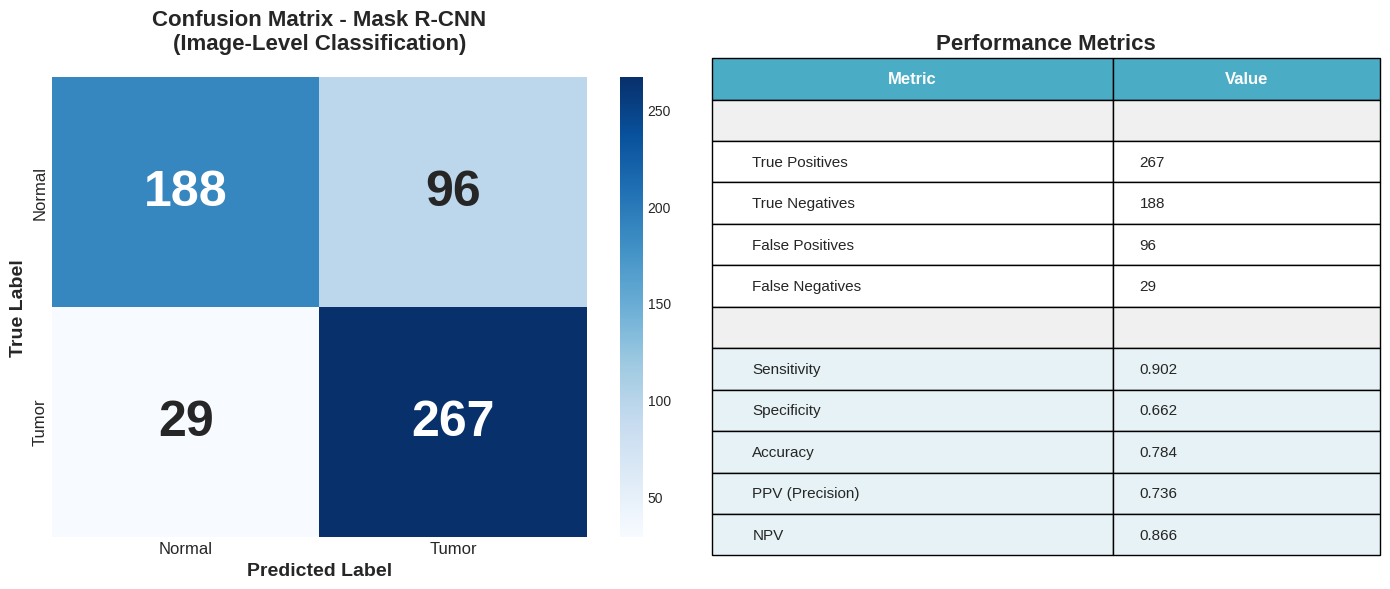


DETAILED PERFORMANCE METRICS - MASK R-CNN

Confusion Matrix Components:
  True Positives (TP):   267  (Correctly detected tumors)
  True Negatives (TN):   188  (Correctly identified normal)
  False Positives (FP):   96  (Normal classified as tumor)
  False Negatives (FN):   29  (Missed tumors)

Classification Metrics:
  Accuracy:    0.7845  (78.45%)
  Sensitivity: 0.9020  (90.20%) - Recall/TPR
  Specificity: 0.6620  (66.20%) - TNR
  Precision:   0.7355  (73.55%) - PPV
  NPV:         0.8664  (86.64%)
  F1-Score:    0.8103  (81.03%)


Scikit-learn Classification Report:
              precision    recall  f1-score   support

      Normal     0.8664    0.6620    0.7505       284
       Tumor     0.7355    0.9020    0.8103       296

    accuracy                         0.7845       580
   macro avg     0.8009    0.7820    0.7804       580
weighted avg     0.7996    0.7845    0.7810       580


ERROR ANALYSIS

FALSE POSITIVES (Normal → Predicted Tumor): 96

Top 10 False Positives (by confi

Visualizing samples: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


✅ Sample visualizations saved to: maskrcnn_confusion_matrix_results/sample_visualizations/

[6/6] Running threshold sensitivity analysis...


Run threshold analysis? This will test 9 different thresholds. (y/n):  y



THRESHOLD SENSITIVITY ANALYSIS - MASK R-CNN


Testing threshold: 0.15


Threshold 0.15: 100%|██████████| 580/580 [01:28<00:00,  6.53it/s]


   Detections: 363
   Masks Generated: 796
   TP/TN/FP/FN: 267/188/96/29
   Sensitivity: 0.9020, Specificity: 0.6620
   Confidence - Min: 0.150, Max: 0.994, Mean: 0.520

Testing threshold: 0.20


Threshold 0.20: 100%|██████████| 580/580 [01:29<00:00,  6.45it/s]


   Detections: 345
   Masks Generated: 665
   TP/TN/FP/FN: 264/203/81/32
   Sensitivity: 0.8919, Specificity: 0.7148
   Confidence - Min: 0.201, Max: 0.994, Mean: 0.589

Testing threshold: 0.25


Threshold 0.25: 100%|██████████| 580/580 [01:30<00:00,  6.40it/s]


   Detections: 325
   Masks Generated: 591
   TP/TN/FP/FN: 256/215/69/40
   Sensitivity: 0.8649, Specificity: 0.7570
   Confidence - Min: 0.250, Max: 0.994, Mean: 0.635

Testing threshold: 0.30


Threshold 0.30: 100%|██████████| 580/580 [01:30<00:00,  6.41it/s]


   Detections: 305
   Masks Generated: 534
   TP/TN/FP/FN: 249/228/56/47
   Sensitivity: 0.8412, Specificity: 0.8028
   Confidence - Min: 0.300, Max: 0.994, Mean: 0.673

Testing threshold: 0.35


Threshold 0.35: 100%|██████████| 580/580 [01:30<00:00,  6.42it/s]


   Detections: 290
   Masks Generated: 483
   TP/TN/FP/FN: 243/237/47/53
   Sensitivity: 0.8209, Specificity: 0.8345
   Confidence - Min: 0.352, Max: 0.994, Mean: 0.710

Testing threshold: 0.40


Threshold 0.40: 100%|██████████| 580/580 [01:30<00:00,  6.42it/s]


   Detections: 277
   Masks Generated: 450
   TP/TN/FP/FN: 236/243/41/60
   Sensitivity: 0.7973, Specificity: 0.8556
   Confidence - Min: 0.401, Max: 0.994, Mean: 0.735

Testing threshold: 0.50


Threshold 0.50: 100%|██████████| 580/580 [01:30<00:00,  6.44it/s]


   Detections: 257
   Masks Generated: 380
   TP/TN/FP/FN: 228/255/29/68
   Sensitivity: 0.7703, Specificity: 0.8979
   Confidence - Min: 0.504, Max: 0.994, Mean: 0.787

THRESHOLD ANALYSIS RESULTS - MASK R-CNN

 threshold  accuracy  sensitivity  specificity  precision  f1_score  tp  tn  fp  fn  num_detections  masks_generated  conf_min  conf_max  conf_mean
      0.15  0.784483     0.902027     0.661972   0.735537  0.810319 267 188  96  29             363              796  0.150097  0.994498   0.520255
      0.20  0.805172     0.891892     0.714789   0.765217  0.823713 264 203  81  32             345              665  0.200648  0.994498   0.588927
      0.25  0.812069     0.864865     0.757042   0.787692  0.824477 256 215  69  40             325              591  0.250454  0.994498   0.634686
      0.30  0.822414     0.841216     0.802817   0.816393  0.828619 249 228  56  47             305              534  0.300399  0.994498   0.672912
      0.35  0.827586     0.820946     0.834507   

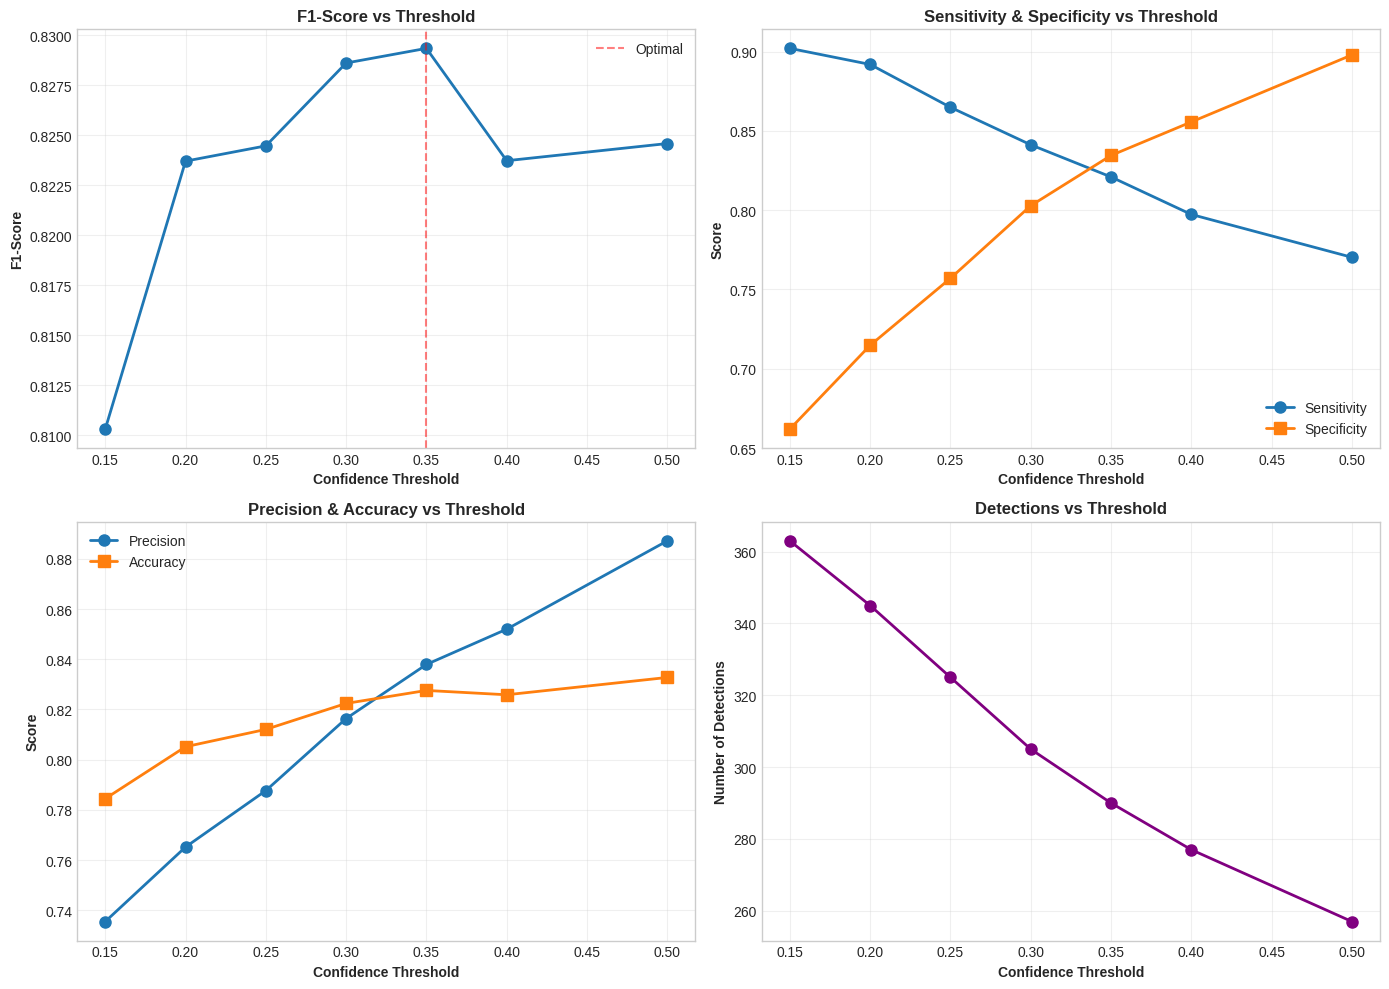


✅ ANALYSIS COMPLETE!

Results saved to: maskrcnn_confusion_matrix_results/
  ├── confusion_matrix_threshold_0.15.png
  ├── detailed_results_threshold_0.15.csv
  ├── sample_visualizations/ (with mask overlays)
  ├── threshold_analysis.csv
  └── threshold_analysis_plot.png



In [4]:
"""
CONFUSION MATRIX GENERATOR FOR MASK R-CNN
==========================================
Generates image-level confusion matrix for bone tumor detection.

Image Classification Logic:
- Tumor (Positive): Image has at least one GT annotation
- Normal (Negative): Image has no GT annotations
- Prediction Positive: Model detects tumor with confidence > threshold
- Prediction Negative: Model detects nothing above threshold
"""

import os
import json
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer, ColorMode

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration for inference and evaluation"""
    
    # Paths
    PREPROCESSED_DIR = "preprocessed"
    IMAGES_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/images"
    
    # ✅ UPDATE THIS: Path to your uploaded model
    MODEL_PATH = "/kaggle/input/maskrcnn-bestmodel/model_best.pth"
    # Alternative if model is in working directory:
    # MODEL_PATH = "stage2_regular_maskrcnn_output/model_best.pth"
    
    # Dataset to evaluate
    EVAL_SPLIT = "val"  # "val" or "test"
    JSON_FILE = f"{PREPROCESSED_DIR}/coco_annotations/{EVAL_SPLIT}.json"
    
    # Model config (must match training)
    MODEL_CONFIG = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    NUM_CLASSES = 1
    
    # Detection threshold (try different values)
    CONFIDENCE_THRESHOLD = 0.15  # Start with training threshold
    # Try: [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40] to see trade-offs
    
    # Output
    OUTPUT_DIR = "maskrcnn_confusion_matrix_results"
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# ============================================================================
# DATA LOADING
# ============================================================================

def load_coco_json(json_file, image_root):
    """Load COCO annotations with category remapping"""
    
    if not os.path.exists(json_file):
        raise FileNotFoundError(f"JSON not found: {json_file}")
    
    with open(json_file, 'r') as f:
        coco_data = json.load(f)
    
    img_to_anns = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_to_anns:
            img_to_anns[img_id] = []
        img_to_anns[img_id].append(ann)
    
    dataset_dicts = []
    
    for img_info in coco_data['images']:
        img_path = os.path.join(image_root, img_info['file_name'])
        
        if not os.path.exists(img_path):
            print(f"⚠️  Warning: Image not found: {img_path}")
            continue
        
        record = {
            "file_name": img_path,
            "image_id": img_info['id'],
            "height": img_info['height'],
            "width": img_info['width']
        }
        
        anns = img_to_anns.get(img_info['id'], [])
        objs = []
        
        for ann in anns:
            bbox = ann['bbox']
            if bbox[2] <= 0 or bbox[3] <= 0:
                continue
            
            category_id_detectron = ann['category_id'] - 1
            
            if category_id_detectron < 0 or category_id_detectron >= Config.NUM_CLASSES:
                continue
            
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": ann.get('segmentation', []),
                "category_id": category_id_detectron,
                "iscrowd": 0
            }
            objs.append(obj)
        
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts


# ============================================================================
# MODEL SETUP
# ============================================================================

def setup_predictor():
    """Setup Mask R-CNN predictor"""
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(Config.MODEL_CONFIG))
    
    # Model weights
    if not os.path.exists(Config.MODEL_PATH):
        raise FileNotFoundError(f"Model not found: {Config.MODEL_PATH}")
    
    cfg.MODEL.WEIGHTS = Config.MODEL_PATH
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = Config.NUM_CLASSES
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = Config.CONFIDENCE_THRESHOLD
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3  # Match training
    
    # Mask R-CNN specific
    cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 14  # Match training
    
    cfg.MODEL.DEVICE = Config.DEVICE
    
    predictor = DefaultPredictor(cfg)
    
    return predictor, cfg


# ============================================================================
# INFERENCE & EVALUATION
# ============================================================================

def evaluate_dataset(predictor, dataset_dicts):
    """
    Run inference and generate confusion matrix data
    
    Returns:
        y_true: Ground truth labels (0=Normal, 1=Tumor)
        y_pred: Predicted labels (0=Normal, 1=Tumor)
        results: Detailed results per image
    """
    
    y_true = []
    y_pred = []
    results = []
    
    print(f"\n{'='*80}")
    print(f"RUNNING INFERENCE ON {len(dataset_dicts)} IMAGES")
    print(f"Confidence Threshold: {Config.CONFIDENCE_THRESHOLD}")
    print(f"{'='*80}\n")
    
    for data in tqdm(dataset_dicts, desc="Processing images"):
        # Read image
        img = cv2.imread(data["file_name"])
        
        # Ground truth: Has annotations?
        has_gt = len(data["annotations"]) > 0
        gt_label = 1 if has_gt else 0  # 1=Tumor, 0=Normal
        
        # Prediction
        outputs = predictor(img)
        instances = outputs["instances"].to("cpu")
        
        # Check if model detected anything above threshold
        num_detections = len(instances)
        has_detection = num_detections > 0
        pred_label = 1 if has_detection else 0  # 1=Tumor, 0=Normal
        
        # Get confidence scores
        if num_detections > 0:
            scores = instances.scores.numpy()
            max_score = float(scores.max())
            mean_score = float(scores.mean())
            
            # Check if masks are available
            has_masks = hasattr(instances, 'pred_masks') and len(instances.pred_masks) > 0
        else:
            max_score = 0.0
            mean_score = 0.0
            has_masks = False
        
        # Store results
        y_true.append(gt_label)
        y_pred.append(pred_label)
        
        results.append({
            'image_id': data['image_id'],
            'file_name': os.path.basename(data['file_name']),
            'gt_label': 'Tumor' if has_gt else 'Normal',
            'pred_label': 'Tumor' if has_detection else 'Normal',
            'num_gt_instances': len(data["annotations"]),
            'num_detections': num_detections,
            'has_masks': has_masks,
            'max_confidence': max_score,
            'mean_confidence': mean_score,
            'correct': gt_label == pred_label
        })
    
    return np.array(y_true), np.array(y_pred), results


# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_confusion_matrix(y_true, y_pred, save_path):
    """
    Plot beautiful confusion matrix matching the original format
    """
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ========== Confusion Matrix Heatmap ==========
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                cbar_kws={'label': ''}, 
                xticklabels=['Normal', 'Tumor'],
                yticklabels=['Normal', 'Tumor'],
                ax=ax1, annot_kws={'size': 36, 'weight': 'bold'})
    
    ax1.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    ax1.set_ylabel('True Label', fontsize=14, fontweight='bold')
    ax1.set_title('Confusion Matrix - Mask R-CNN\n(Image-Level Classification)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.tick_params(labelsize=12)
    
    # ========== Performance Metrics Table ==========
    metrics_data = {
        'Metric': [
            '',
            'True Positives',
            'True Negatives',
            'False Positives',
            'False Negatives',
            '',
            'Sensitivity',
            'Specificity',
            'Accuracy',
            'PPV (Precision)',
            'NPV'
        ],
        'Value': [
            '',
            str(tp),
            str(tn),
            str(fp),
            str(fn),
            '',
            f'{sensitivity:.3f}',
            f'{specificity:.3f}',
            f'{accuracy:.3f}',
            f'{ppv:.3f}',
            f'{npv:.3f}'
        ]
    }
    
    df = pd.DataFrame(metrics_data)
    
    # Remove axis
    ax2.axis('tight')
    ax2.axis('off')
    
    # Create table
    table = ax2.table(cellText=df.values, 
                      colLabels=df.columns,
                      cellLoc='left',
                      loc='center',
                      colWidths=[0.6, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    # Style header
    for i in range(len(df.columns)):
        cell = table[(0, i)]
        cell.set_facecolor('#4BACC6')
        cell.set_text_props(weight='bold', color='white', fontsize=12)
    
    # Style metrics rows
    for i in range(1, len(df) + 1):
        # Alternate row colors
        if df.iloc[i-1]['Metric'] == '':
            # Separator rows
            for j in range(len(df.columns)):
                table[(i, j)].set_facecolor('#F0F0F0')
        elif i > 6:  # Performance metrics
            for j in range(len(df.columns)):
                table[(i, j)].set_facecolor('#E6F2F5')
    
    ax2.set_title('Performance Metrics', 
                  fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Confusion matrix saved: {save_path}")
    
    plt.show()
    
    return cm, {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': ppv,
        'npv': npv,
        'tp': int(tp),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn)
    }


def print_detailed_metrics(metrics, y_true, y_pred):
    """Print comprehensive metrics"""
    
    print(f"\n{'='*80}")
    print("DETAILED PERFORMANCE METRICS - MASK R-CNN")
    print(f"{'='*80}\n")
    
    print("Confusion Matrix Components:")
    print(f"  True Positives (TP):  {metrics['tp']:>4d}  (Correctly detected tumors)")
    print(f"  True Negatives (TN):  {metrics['tn']:>4d}  (Correctly identified normal)")
    print(f"  False Positives (FP): {metrics['fp']:>4d}  (Normal classified as tumor)")
    print(f"  False Negatives (FN): {metrics['fn']:>4d}  (Missed tumors)")
    
    print(f"\nClassification Metrics:")
    print(f"  Accuracy:    {metrics['accuracy']:.4f}  ({metrics['accuracy']*100:.2f}%)")
    print(f"  Sensitivity: {metrics['sensitivity']:.4f}  ({metrics['sensitivity']*100:.2f}%) - Recall/TPR")
    print(f"  Specificity: {metrics['specificity']:.4f}  ({metrics['specificity']*100:.2f}%) - TNR")
    print(f"  Precision:   {metrics['precision']:.4f}  ({metrics['precision']*100:.2f}%) - PPV")
    print(f"  NPV:         {metrics['npv']:.4f}  ({metrics['npv']*100:.2f}%)")
    
    # F1 Score
    if metrics['precision'] + metrics['sensitivity'] > 0:
        f1 = 2 * (metrics['precision'] * metrics['sensitivity']) / (metrics['precision'] + metrics['sensitivity'])
        print(f"  F1-Score:    {f1:.4f}  ({f1*100:.2f}%)")
    
    print(f"\n{'='*80}")
    
    # Sklearn classification report
    print("\nScikit-learn Classification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=['Normal', 'Tumor'],
                                digits=4))


def analyze_errors(results):
    """Analyze false positives and false negatives"""
    
    false_positives = [r for r in results if r['gt_label'] == 'Normal' and r['pred_label'] == 'Tumor']
    false_negatives = [r for r in results if r['gt_label'] == 'Tumor' and r['pred_label'] == 'Normal']
    
    print(f"\n{'='*80}")
    print("ERROR ANALYSIS")
    print(f"{'='*80}\n")
    
    # False Positives
    print(f"FALSE POSITIVES (Normal → Predicted Tumor): {len(false_positives)}")
    if len(false_positives) > 0:
        print("\nTop 10 False Positives (by confidence):")
        fp_sorted = sorted(false_positives, key=lambda x: x['max_confidence'], reverse=True)
        for i, fp in enumerate(fp_sorted[:10], 1):
            mask_info = "✓ masks" if fp['has_masks'] else "✗ no masks"
            print(f"  {i:2d}. {fp['file_name']:30s} | "
                  f"Detections: {fp['num_detections']} | "
                  f"Max Conf: {fp['max_confidence']:.3f} | {mask_info}")
    
    # False Negatives
    print(f"\nFALSE NEGATIVES (Tumor → Predicted Normal): {len(false_negatives)}")
    if len(false_negatives) > 0:
        print("\nAll False Negatives:")
        for i, fn in enumerate(false_negatives, 1):
            print(f"  {i:2d}. {fn['file_name']:30s} | "
                  f"GT Instances: {fn['num_gt_instances']} | "
                  f"Detections: {fn['num_detections']}")
    
    print(f"\n{'='*80}")


def save_results_csv(results, save_path):
    """Save detailed results to CSV"""
    
    df = pd.DataFrame(results)
    df.to_csv(save_path, index=False)
    print(f"✅ Detailed results saved: {save_path}")


# ============================================================================
# THRESHOLD SENSITIVITY ANALYSIS
# ============================================================================

def threshold_analysis(dataset_dicts):
    """
    Test multiple confidence thresholds to find optimal operating point
    
    ✅ FIXED: Recreates predictor for each threshold
    """
    
    thresholds = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50]
    
    print(f"\n{'='*80}")
    print("THRESHOLD SENSITIVITY ANALYSIS - MASK R-CNN")
    print(f"{'='*80}\n")
    
    threshold_results = []
    
    for threshold in thresholds:
        print(f"\n{'='*60}")
        print(f"Testing threshold: {threshold:.2f}")
        print(f"{'='*60}")
        
        # ✅ CRITICAL FIX: Create NEW predictor for each threshold
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file(Config.MODEL_CONFIG))
        cfg.MODEL.WEIGHTS = Config.MODEL_PATH
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = Config.NUM_CLASSES
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold  # ← Set threshold HERE
        cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
        cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 14
        cfg.MODEL.DEVICE = Config.DEVICE
        
        predictor = DefaultPredictor(cfg)  # ← NEW predictor each time
        
        y_true = []
        y_pred = []
        all_confidences = []  # Track confidence scores
        total_masks_generated = 0
        
        for data in tqdm(dataset_dicts, desc=f"Threshold {threshold:.2f}"):
            img = cv2.imread(data["file_name"])
            has_gt = len(data["annotations"]) > 0
            
            outputs = predictor(img)
            instances = outputs["instances"].to("cpu")
            has_detection = len(instances) > 0
            
            # Track confidence scores and masks for debugging
            if len(instances) > 0:
                all_confidences.extend(instances.scores.numpy().tolist())
                if hasattr(instances, 'pred_masks'):
                    total_masks_generated += len(instances.pred_masks)
            
            y_true.append(1 if has_gt else 0)
            y_pred.append(1 if has_detection else 0)
        
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        # Calculate metrics
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        total = tn + fp + fn + tp
        accuracy = (tp + tn) / total
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        
        # Confidence statistics
        if all_confidences:
            conf_stats = {
                'min': np.min(all_confidences),
                'max': np.max(all_confidences),
                'mean': np.mean(all_confidences),
                'median': np.median(all_confidences)
            }
        else:
            conf_stats = {'min': 0, 'max': 0, 'mean': 0, 'median': 0}
        
        print(f"   Detections: {tp + fp}")
        print(f"   Masks Generated: {total_masks_generated}")
        print(f"   TP/TN/FP/FN: {tp}/{tn}/{fp}/{fn}")
        print(f"   Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        print(f"   Confidence - Min: {conf_stats['min']:.3f}, Max: {conf_stats['max']:.3f}, Mean: {conf_stats['mean']:.3f}")
        
        threshold_results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1_score': f1,
            'tp': int(tp),
            'tn': int(tn),
            'fp': int(fp),
            'fn': int(fn),
            'num_detections': int(tp + fp),
            'masks_generated': total_masks_generated,
            'conf_min': conf_stats['min'],
            'conf_max': conf_stats['max'],
            'conf_mean': conf_stats['mean']
        })
        
        # Clean up to free memory
        del predictor
        torch.cuda.empty_cache()
    
    # Print results table
    df = pd.DataFrame(threshold_results)
    print(f"\n{'='*80}")
    print("THRESHOLD ANALYSIS RESULTS - MASK R-CNN")
    print(f"{'='*80}\n")
    print(df.to_string(index=False))
    
    # Find optimal threshold (max F1-score)
    optimal_idx = df['f1_score'].idxmax()
    optimal = df.iloc[optimal_idx]
    
    print(f"\n{'='*80}")
    print(f"OPTIMAL THRESHOLD: {optimal['threshold']:.2f}")
    print(f"{'='*80}")
    print(f"  F1-Score:       {optimal['f1_score']:.4f}")
    print(f"  Accuracy:       {optimal['accuracy']:.4f}")
    print(f"  Sensitivity:    {optimal['sensitivity']:.4f}")
    print(f"  Specificity:    {optimal['specificity']:.4f}")
    print(f"  Precision:      {optimal['precision']:.4f}")
    print(f"  TP/TN/FP/FN:    {optimal['tp']}/{optimal['tn']}/{optimal['fp']}/{optimal['fn']}")
    print(f"  Num Detections: {optimal['num_detections']}")
    print(f"  Masks Generated: {optimal['masks_generated']}")
    print(f"{'='*80}\n")
    
    return df


# ============================================================================
# VISUALIZATION: SAMPLE PREDICTIONS
# ============================================================================

def visualize_sample_predictions(predictor, dataset_dicts, save_dir, num_samples=10):
    """
    Visualize sample predictions with masks overlaid
    """
    
    print(f"\n{'='*80}")
    print("GENERATING SAMPLE VISUALIZATIONS")
    print(f"{'='*80}\n")
    
    vis_dir = os.path.join(save_dir, "sample_visualizations")
    os.makedirs(vis_dir, exist_ok=True)
    
    # Select diverse samples (some with tumors, some without)
    tumor_samples = [d for d in dataset_dicts if len(d["annotations"]) > 0]
    normal_samples = [d for d in dataset_dicts if len(d["annotations"]) == 0]
    
    samples = []
    if len(tumor_samples) >= num_samples // 2:
        samples.extend(np.random.choice(tumor_samples, num_samples // 2, replace=False))
    else:
        samples.extend(tumor_samples)
    
    if len(normal_samples) >= num_samples // 2:
        samples.extend(np.random.choice(normal_samples, num_samples // 2, replace=False))
    else:
        samples.extend(normal_samples)
    
    for i, data in enumerate(tqdm(samples, desc="Visualizing samples")):
        img = cv2.imread(data["file_name"])
        
        # Run prediction
        outputs = predictor(img)
        
        # Visualize with Detectron2 visualizer
        v = Visualizer(img[:, :, ::-1], 
                      metadata=MetadataCatalog.get("btxrd_val"),
                      scale=1.0,
                      instance_mode=ColorMode.IMAGE)
        
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        vis_img = out.get_image()[:, :, ::-1]
        
        # Save
        gt_label = "tumor" if len(data["annotations"]) > 0 else "normal"
        pred_label = "tumor" if len(outputs["instances"]) > 0 else "normal"
        num_det = len(outputs["instances"])
        
        filename = f"sample_{i+1:02d}_gt_{gt_label}_pred_{pred_label}_det{num_det}.png"
        save_path = os.path.join(vis_dir, filename)
        cv2.imwrite(save_path, vis_img)
    
    print(f"✅ Sample visualizations saved to: {vis_dir}/")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution"""
    
    print("="*80)
    print("CONFUSION MATRIX GENERATOR - MASK R-CNN")
    print("="*80)
    print(f"Model: {Config.MODEL_PATH}")
    print(f"Dataset: {Config.EVAL_SPLIT}")
    print(f"Confidence Threshold: {Config.CONFIDENCE_THRESHOLD}")
    print(f"Device: {Config.DEVICE}")
    print("="*80)
    
    # Create output directory
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    
    # Load dataset
    print("\n[1/6] Loading dataset...")
    dataset_dicts = load_coco_json(Config.JSON_FILE, Config.IMAGES_DIR)
    
    total_images = len(dataset_dicts)
    tumor_images = sum(1 for d in dataset_dicts if len(d["annotations"]) > 0)
    normal_images = total_images - tumor_images
    
    print(f"✅ Dataset loaded:")
    print(f"   Total images: {total_images}")
    print(f"   Tumor images: {tumor_images} ({tumor_images/total_images*100:.1f}%)")
    print(f"   Normal images: {normal_images} ({normal_images/total_images*100:.1f}%)")
    
    # Setup predictor
    print("\n[2/6] Loading model...")
    predictor, cfg = setup_predictor()
    print(f"✅ Mask R-CNN model loaded successfully")
    
    # Run inference
    print("\n[3/6] Running inference...")
    y_true, y_pred, results = evaluate_dataset(predictor, dataset_dicts)
    
    # Generate confusion matrix
    print("\n[4/6] Generating confusion matrix...")
    cm_path = os.path.join(Config.OUTPUT_DIR, f"confusion_matrix_threshold_{Config.CONFIDENCE_THRESHOLD:.2f}.png")
    cm, metrics = plot_confusion_matrix(y_true, y_pred, cm_path)
    
    # Print metrics
    print_detailed_metrics(metrics, y_true, y_pred)
    
    # Error analysis
    analyze_errors(results)
    
    # Save CSV
    csv_path = os.path.join(Config.OUTPUT_DIR, f"detailed_results_threshold_{Config.CONFIDENCE_THRESHOLD:.2f}.csv")
    save_results_csv(results, csv_path)
    
    # Sample visualizations
    print("\n[5/6] Generating sample visualizations...")
    try:
        visualize_sample_predictions(predictor, dataset_dicts, Config.OUTPUT_DIR, num_samples=10)
    except Exception as e:
        print(f"⚠️  Warning: Could not generate visualizations: {e}")
    
    # Threshold analysis (optional - can be slow)
    print("\n[6/6] Running threshold sensitivity analysis...")
    user_input = input("Run threshold analysis? This will test 9 different thresholds. (y/n): ")
    if user_input.lower() == 'y':
        # ✅ FIXED: Only pass dataset_dicts (no predictor)
        threshold_df = threshold_analysis(dataset_dicts)
        threshold_csv = os.path.join(Config.OUTPUT_DIR, "threshold_analysis.csv")
        threshold_df.to_csv(threshold_csv, index=False)
        print(f"✅ Threshold analysis saved: {threshold_csv}")
        
        # Plot threshold analysis
        plot_threshold_analysis(threshold_df, Config.OUTPUT_DIR)
    
    print(f"\n{'='*80}")
    print("✅ ANALYSIS COMPLETE!")
    print(f"{'='*80}")
    print(f"\nResults saved to: {Config.OUTPUT_DIR}/")
    print(f"  ├── confusion_matrix_threshold_{Config.CONFIDENCE_THRESHOLD:.2f}.png")
    print(f"  ├── detailed_results_threshold_{Config.CONFIDENCE_THRESHOLD:.2f}.csv")
    print(f"  ├── sample_visualizations/ (with mask overlays)")
    if user_input.lower() == 'y':
        print(f"  ├── threshold_analysis.csv")
        print(f"  └── threshold_analysis_plot.png")
    print(f"{'='*80}\n")


def plot_threshold_analysis(df, save_dir):
    """Plot threshold analysis results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # F1-Score vs Threshold
    axes[0, 0].plot(df['threshold'], df['f1_score'], 'o-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Confidence Threshold', fontweight='bold')
    axes[0, 0].set_ylabel('F1-Score', fontweight='bold')
    axes[0, 0].set_title('F1-Score vs Threshold', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axvline(df.loc[df['f1_score'].idxmax(), 'threshold'], 
                       color='red', linestyle='--', alpha=0.5, label='Optimal')
    axes[0, 0].legend()
    
    # Sensitivity & Specificity
    axes[0, 1].plot(df['threshold'], df['sensitivity'], 'o-', label='Sensitivity', linewidth=2, markersize=8)
    axes[0, 1].plot(df['threshold'], df['specificity'], 's-', label='Specificity', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Confidence Threshold', fontweight='bold')
    axes[0, 1].set_ylabel('Score', fontweight='bold')
    axes[0, 1].set_title('Sensitivity & Specificity vs Threshold', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Precision & Accuracy
    axes[1, 0].plot(df['threshold'], df['precision'], 'o-', label='Precision', linewidth=2, markersize=8)
    axes[1, 0].plot(df['threshold'], df['accuracy'], 's-', label='Accuracy', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Confidence Threshold', fontweight='bold')
    axes[1, 0].set_ylabel('Score', fontweight='bold')
    axes[1, 0].set_title('Precision & Accuracy vs Threshold', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Number of Detections
    axes[1, 1].plot(df['threshold'], df['num_detections'], 'o-', linewidth=2, markersize=8, color='purple')
    axes[1, 1].set_xlabel('Confidence Threshold', fontweight='bold')
    axes[1, 1].set_ylabel('Number of Detections', fontweight='bold')
    axes[1, 1].set_title('Detections vs Threshold', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, 'threshold_analysis_plot.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Threshold analysis plot saved: {save_path}")
    plt.show()


if __name__ == "__main__":
    main()

COMPREHENSIVE AP METRICS EVALUATION - MASK R-CNN

[1/5] Registering validation dataset...
✅ Dataset registered: 580 images

[2/5] Setting up model configuration...
✅ Configuration ready

[3/5] Running COCO evaluation...

RUNNING FULL COCO EVALUATION
Model: /kaggle/input/maskrcnn-bestmodel/model_best.pth
Dataset: btxrd_val_eval
Score threshold: 0.15

🔄 Running inference on validation set...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

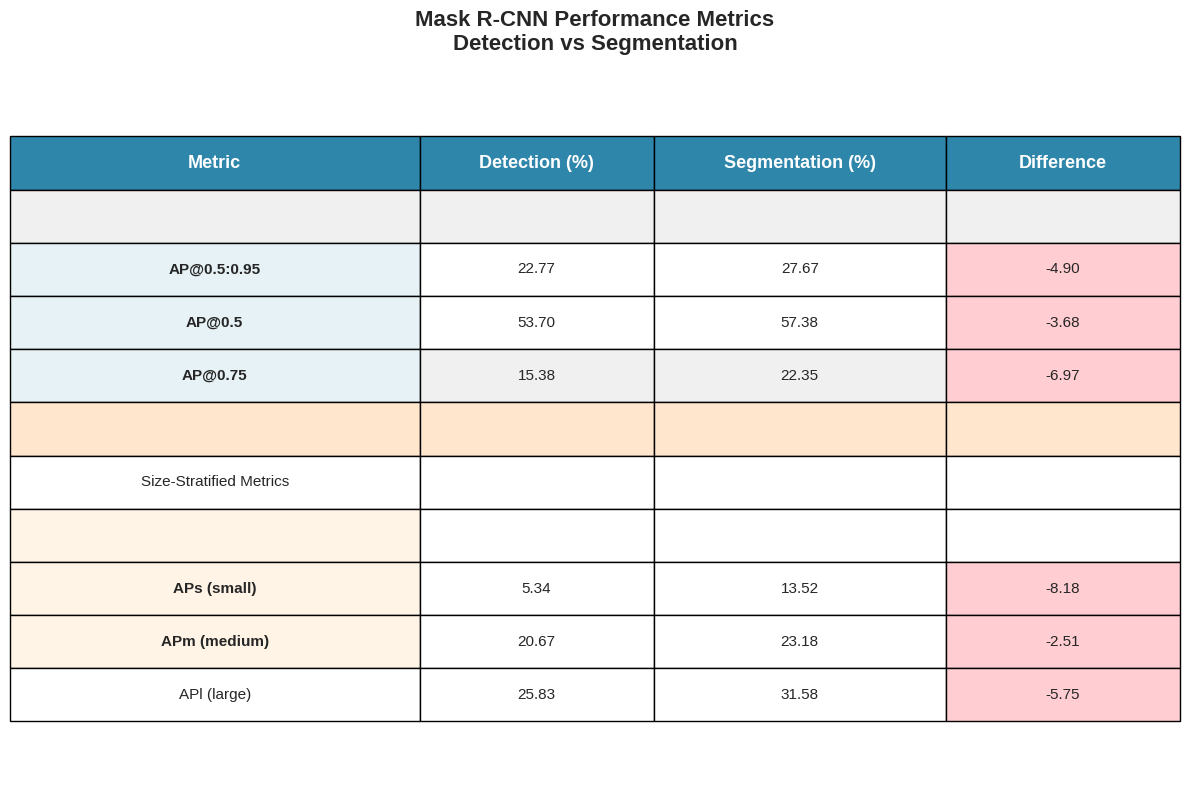

✅ Side-by-side chart saved: comprehensive_ap_metrics/detection_vs_segmentation_chart.png


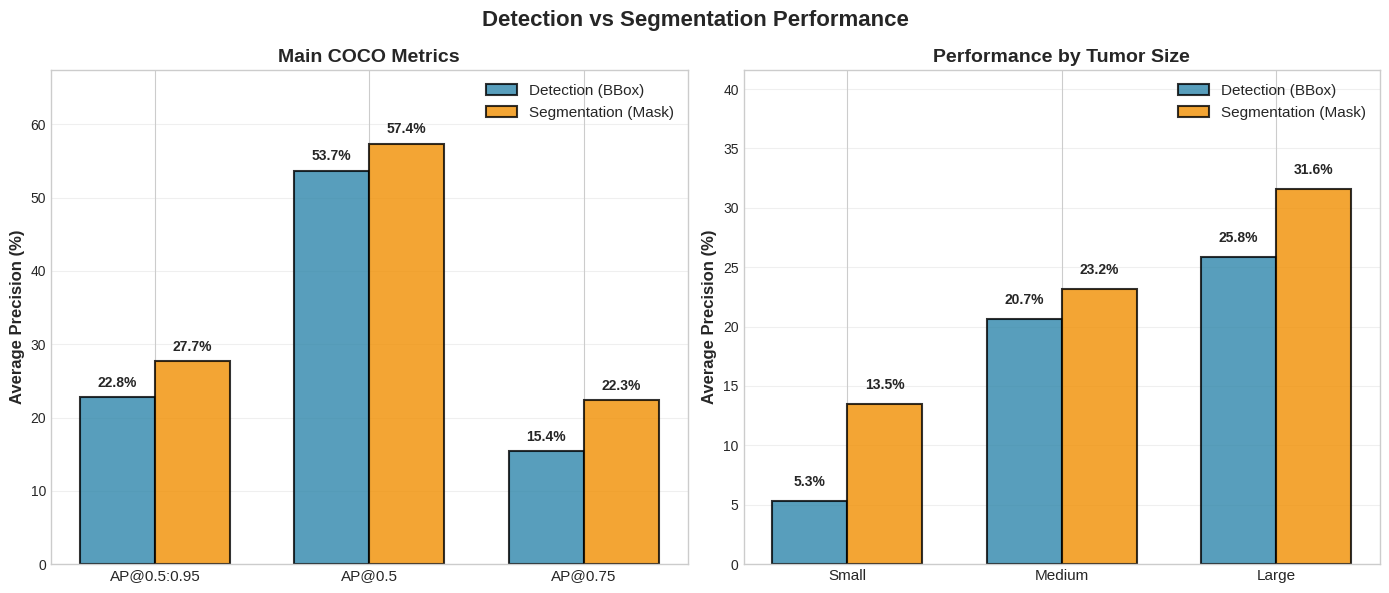

✅ Compact summary saved: comprehensive_ap_metrics/ap_metrics_compact.png


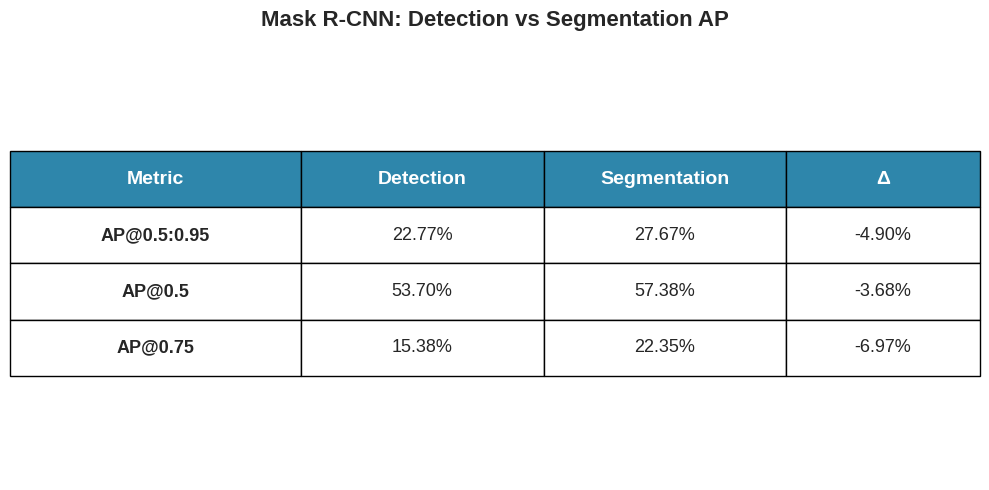


✅ EVALUATION COMPLETE!

Generated files in 'comprehensive_ap_metrics/':
  ├── comprehensive_ap_metrics.csv (long format)
  ├── ap_metrics_comparison.csv (wide format)
  ├── ap_metrics_table.png (publication table)
  ├── detection_vs_segmentation_chart.png (bar charts)
  └── ap_metrics_compact.png (compact summary)


Key Findings:
  Detection AP@0.5:      53.70%
  Segmentation AP@0.5:   57.38%
  Detection AP@0.5:0.95: 22.77%
  Segmentation AP:       27.67%



In [6]:
"""
COMPREHENSIVE AP METRICS EVALUATION - MASK R-CNN
=================================================
Extracts ALL COCO metrics from trained model and creates publication table.

Metrics Extracted:
- Detection: AP, AP@0.5, AP@0.75, AP@[0.5:0.95]
- Segmentation: AP, AP@0.5, AP@0.75, AP@[0.5:0.95]
- Size-stratified: APs (small), APm (medium), APl (large)

Outputs:
- CSV file with all metrics
- Publication-quality comparison table (image)
- Side-by-side detection vs segmentation visualization

Author: AP Metrics Analyzer
Date: 2026-02-08
"""

import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration for metrics evaluation"""
    
    # Model
    MODEL_PATH = "/kaggle/input/maskrcnn-bestmodel/model_best.pth"
    # Alternative: MODEL_PATH = "stage2_regular_maskrcnn_output/model_best.pth"
    
    MODEL_CONFIG = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    NUM_CLASSES = 1
    
    # Data
    PREPROCESSED_DIR = "preprocessed"
    IMAGES_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/images"
    VAL_JSON = f"{PREPROCESSED_DIR}/coco_annotations/val.json"
    
    # Evaluation settings
    SCORE_THRESH_TEST = 0.15  # Match training threshold
    NMS_THRESH_TEST = 0.3
    
    # Input size (match training)
    MIN_SIZE_TEST = 640
    MAX_SIZE_TEST = 912
    
    # Output
    OUTPUT_DIR = "comprehensive_ap_metrics"
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# ============================================================================
# DATA LOADING
# ============================================================================

def load_coco_json(json_file, image_root):
    """Load COCO annotations"""
    
    if not os.path.exists(json_file):
        raise FileNotFoundError(f"JSON not found: {json_file}")
    
    with open(json_file, 'r') as f:
        coco_data = json.load(f)
    
    img_to_anns = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_to_anns:
            img_to_anns[img_id] = []
        img_to_anns[img_id].append(ann)
    
    dataset_dicts = []
    
    for img_info in coco_data['images']:
        img_path = os.path.join(image_root, img_info['file_name'])
        
        if not os.path.exists(img_path):
            print(f"⚠️  Warning: Image not found: {img_path}")
            continue
        
        record = {
            "file_name": img_path,
            "image_id": img_info['id'],
            "height": img_info['height'],
            "width": img_info['width']
        }
        
        anns = img_to_anns.get(img_info['id'], [])
        objs = []
        
        for ann in anns:
            bbox = ann['bbox']
            if bbox[2] <= 0 or bbox[3] <= 0:
                continue
            
            category_id_detectron = ann['category_id'] - 1
            
            if category_id_detectron < 0 or category_id_detectron >= Config.NUM_CLASSES:
                continue
            
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": ann.get('segmentation', []),
                "category_id": category_id_detectron,
                "iscrowd": 0
            }
            objs.append(obj)
        
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts


def register_dataset():
    """Register validation dataset"""
    
    dataset_name = "btxrd_val_eval"
    
    # Remove if already registered
    if dataset_name in DatasetCatalog:
        DatasetCatalog.remove(dataset_name)
    if dataset_name in MetadataCatalog:
        MetadataCatalog.remove(dataset_name)
    
    # Register
    DatasetCatalog.register(
        dataset_name,
        lambda: load_coco_json(Config.VAL_JSON, Config.IMAGES_DIR)
    )
    
    MetadataCatalog.get(dataset_name).set(
        thing_classes=["tumor"],
        thing_dataset_id_to_contiguous_id={1: 0},
        json_file=Config.VAL_JSON,
        image_root=Config.IMAGES_DIR,
        evaluator_type="coco"
    )
    
    return dataset_name


# ============================================================================
# MODEL SETUP
# ============================================================================

def setup_cfg():
    """Setup configuration for evaluation"""
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(Config.MODEL_CONFIG))
    
    # Model weights
    if not os.path.exists(Config.MODEL_PATH):
        raise FileNotFoundError(f"Model not found: {Config.MODEL_PATH}")
    
    cfg.MODEL.WEIGHTS = Config.MODEL_PATH
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = Config.NUM_CLASSES
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = Config.SCORE_THRESH_TEST
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = Config.NMS_THRESH_TEST
    
    # Mask R-CNN specific
    cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 14
    
    # Input size
    cfg.INPUT.MIN_SIZE_TEST = Config.MIN_SIZE_TEST
    cfg.INPUT.MAX_SIZE_TEST = Config.MAX_SIZE_TEST
    
    # Dataset
    cfg.DATASETS.TEST = ("btxrd_val_eval",)
    
    cfg.MODEL.DEVICE = Config.DEVICE
    
    return cfg


# ============================================================================
# EVALUATION
# ============================================================================

def run_coco_evaluation(cfg, dataset_name, output_dir):
    """
    Run full COCO evaluation to extract all AP metrics
    
    Returns:
        dict: All COCO metrics for bbox and segm
    """
    
    print(f"\n{'='*80}")
    print("RUNNING FULL COCO EVALUATION")
    print(f"{'='*80}")
    print(f"Model: {Config.MODEL_PATH}")
    print(f"Dataset: {dataset_name}")
    print(f"Score threshold: {Config.SCORE_THRESH_TEST}")
    print(f"{'='*80}\n")
    
    # Create predictor
    from detectron2.engine import DefaultTrainer
    predictor = DefaultPredictor(cfg)
    
    # Build data loader
    data_loader = build_detection_test_loader(cfg, dataset_name)
    
    # Create evaluator
    evaluator = COCOEvaluator(
        dataset_name,
        output_dir=output_dir,
        allow_cached_coco=False
    )
    
    # Run evaluation
    print("🔄 Running inference on validation set...")
    results = inference_on_dataset(predictor.model, data_loader, evaluator)
    
    print(f"\n{'='*80}")
    print("EVALUATION COMPLETE")
    print(f"{'='*80}\n")
    
    return results


def extract_metrics(results):
    """
    Extract and organize all metrics from COCO evaluation results
    
    Returns:
        dict: Organized metrics
    """
    
    bbox_metrics = results.get('bbox', {})
    segm_metrics = results.get('segm', {})
    
    # Detection metrics
    detection = {
        'AP@0.5:0.95': bbox_metrics.get('AP', 0.0),
        'AP@0.5': bbox_metrics.get('AP50', 0.0),
        'AP@0.75': bbox_metrics.get('AP75', 0.0),
        'APs (small)': bbox_metrics.get('APs', 0.0),
        'APm (medium)': bbox_metrics.get('APm', 0.0),
        'APl (large)': bbox_metrics.get('APl', 0.0),
    }
    
    # Segmentation metrics
    segmentation = {
        'AP@0.5:0.95': segm_metrics.get('AP', 0.0),
        'AP@0.5': segm_metrics.get('AP50', 0.0),
        'AP@0.75': segm_metrics.get('AP75', 0.0),
        'APs (small)': segm_metrics.get('APs', 0.0),
        'APm (medium)': segm_metrics.get('APm', 0.0),
        'APl (large)': segm_metrics.get('APl', 0.0),
    }
    
    metrics = {
        'Detection': detection,
        'Segmentation': segmentation
    }
    
    return metrics


# ============================================================================
# CSV EXPORT
# ============================================================================

def save_metrics_csv(metrics, output_dir):
    """Save metrics to CSV file"""
    
    # Create DataFrame
    data = []
    
    for task in ['Detection', 'Segmentation']:
        for metric_name, value in metrics[task].items():
            data.append({
                'Task': task,
                'Metric': metric_name,
                'Value (%)': f'{value:.2f}'
            })
    
    df = pd.DataFrame(data)
    
    # Save
    csv_path = os.path.join(output_dir, 'comprehensive_ap_metrics.csv')
    df.to_csv(csv_path, index=False)
    
    print(f"✅ CSV saved: {csv_path}")
    
    return df


def save_metrics_wide_csv(metrics, output_dir):
    """Save metrics in wide format (side-by-side comparison)"""
    
    # Create wide format
    data = {
        'Metric': [],
        'Detection (%)': [],
        'Segmentation (%)': [],
        'Difference (%)': []
    }
    
    for metric_name in metrics['Detection'].keys():
        det_val = metrics['Detection'][metric_name]
        seg_val = metrics['Segmentation'][metric_name]
        diff = det_val - seg_val
        
        data['Metric'].append(metric_name)
        data['Detection (%)'].append(f'{det_val:.2f}')
        data['Segmentation (%)'].append(f'{seg_val:.2f}')
        data['Difference (%)'].append(f'{diff:+.2f}')
    
    df = pd.DataFrame(data)
    
    # Save
    csv_path = os.path.join(output_dir, 'ap_metrics_comparison.csv')
    df.to_csv(csv_path, index=False)
    
    print(f"✅ Comparison CSV saved: {csv_path}")
    
    return df


# ============================================================================
# VISUALIZATION
# ============================================================================

def create_publication_table(metrics, output_dir):
    """
    Create publication-quality table comparing detection vs segmentation
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data
    table_data = [
        ['Metric', 'Detection (%)', 'Segmentation (%)', 'Difference'],
        ['', '', '', '']
    ]
    
    # Add main metrics
    for metric_name in ['AP@0.5:0.95', 'AP@0.5', 'AP@0.75']:
        det_val = metrics['Detection'][metric_name]
        seg_val = metrics['Segmentation'][metric_name]
        diff = det_val - seg_val
        
        table_data.append([
            metric_name,
            f'{det_val:.2f}',
            f'{seg_val:.2f}',
            f'{diff:+.2f}'
        ])
    
    # Separator
    table_data.append(['', '', '', ''])
    table_data.append(['Size-Stratified Metrics', '', '', ''])
    table_data.append(['', '', '', ''])
    
    # Size-stratified metrics
    for metric_name in ['APs (small)', 'APm (medium)', 'APl (large)']:
        det_val = metrics['Detection'][metric_name]
        seg_val = metrics['Segmentation'][metric_name]
        diff = det_val - seg_val
        
        table_data.append([
            metric_name,
            f'{det_val:.2f}',
            f'{seg_val:.2f}',
            f'{diff:+.2f}'
        ])
    
    # Create table
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.35, 0.2, 0.25, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.8)
    
    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=13)
    
    # Style separator rows
    for row_idx in [1, 4, 5]:
        for col_idx in range(4):
            table[(row_idx, col_idx)].set_facecolor('#F0F0F0')
    
    # Style main metrics section
    for row_idx in [2, 3, 4]:
        table[(row_idx, 0)].set_facecolor('#E6F2F5')
        table[(row_idx, 0)].set_text_props(weight='bold')
    
    # Style size-stratified section header
    table[(5, 0)].set_facecolor('#FFE6CC')
    table[(5, 0)].set_text_props(weight='bold', style='italic')
    for i in range(1, 4):
        table[(5, i)].set_facecolor('#FFE6CC')
    
    # Style size-stratified metrics
    for row_idx in [7, 8, 9]:
        table[(row_idx, 0)].set_facecolor('#FFF4E6')
        table[(row_idx, 0)].set_text_props(weight='bold')
    
    # Highlight positive/negative differences
    for row_idx in range(2, len(table_data)):
        if table_data[row_idx][3] and table_data[row_idx][3] != '':
            try:
                diff_val = float(table_data[row_idx][3])
                if diff_val > 0:
                    table[(row_idx, 3)].set_facecolor('#C8E6C9')  # Green
                elif diff_val < 0:
                    table[(row_idx, 3)].set_facecolor('#FFCDD2')  # Red
            except:
                pass
    
    ax.set_title('Mask R-CNN Performance Metrics\nDetection vs Segmentation', 
                 fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    # Save
    output_path = os.path.join(output_dir, 'ap_metrics_table.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Publication table saved: {output_path}")
    
    plt.show()
    plt.close()


def create_side_by_side_chart(metrics, output_dir):
    """
    Create side-by-side bar chart comparing detection vs segmentation
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Detection vs Segmentation Performance', 
                 fontsize=16, fontweight='bold')
    
    # Main metrics (left plot)
    ax = axes[0]
    metric_names = ['AP@0.5:0.95', 'AP@0.5', 'AP@0.75']
    det_values = [metrics['Detection'][m] for m in metric_names]
    seg_values = [metrics['Segmentation'][m] for m in metric_names]
    
    x = np.arange(len(metric_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, det_values, width, label='Detection (BBox)', 
                   color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, seg_values, width, label='Segmentation (Mask)', 
                   color='#F18F01', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel('Average Precision (%)', fontsize=12, fontweight='bold')
    ax.set_title('Main COCO Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names, fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, max(max(det_values), max(seg_values)) + 10])
    
    # Size-stratified metrics (right plot)
    ax = axes[1]
    size_names = ['Small', 'Medium', 'Large']
    metric_keys = ['APs (small)', 'APm (medium)', 'APl (large)']
    det_values = [metrics['Detection'][m] for m in metric_keys]
    seg_values = [metrics['Segmentation'][m] for m in metric_keys]
    
    x = np.arange(len(size_names))
    
    bars1 = ax.bar(x - width/2, det_values, width, label='Detection (BBox)', 
                   color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, seg_values, width, label='Segmentation (Mask)', 
                   color='#F18F01', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only show if non-zero
                ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{height:.1f}%',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel('Average Precision (%)', fontsize=12, fontweight='bold')
    ax.set_title('Performance by Tumor Size', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(size_names, fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, max(max(det_values), max(seg_values)) + 10])
    
    plt.tight_layout()
    
    # Save
    output_path = os.path.join(output_dir, 'detection_vs_segmentation_chart.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Side-by-side chart saved: {output_path}")
    
    plt.show()
    plt.close()


def create_compact_summary(metrics, output_dir):
    """
    Create compact summary figure with key metrics only
    """
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('tight')
    ax.axis('off')
    
    # Compact table with only main metrics
    table_data = [
        ['Metric', 'Detection', 'Segmentation', 'Δ'],
        ['AP@0.5:0.95', 
         f"{metrics['Detection']['AP@0.5:0.95']:.2f}%",
         f"{metrics['Segmentation']['AP@0.5:0.95']:.2f}%",
         f"{metrics['Detection']['AP@0.5:0.95'] - metrics['Segmentation']['AP@0.5:0.95']:+.2f}%"],
        ['AP@0.5', 
         f"{metrics['Detection']['AP@0.5']:.2f}%",
         f"{metrics['Segmentation']['AP@0.5']:.2f}%",
         f"{metrics['Detection']['AP@0.5'] - metrics['Segmentation']['AP@0.5']:+.2f}%"],
        ['AP@0.75', 
         f"{metrics['Detection']['AP@0.75']:.2f}%",
         f"{metrics['Segmentation']['AP@0.75']:.2f}%",
         f"{metrics['Detection']['AP@0.75'] - metrics['Segmentation']['AP@0.75']:+.2f}%"],
    ]
    
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.3, 0.25, 0.25, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(13)
    table.scale(1, 3)
    
    # Style
    for i in range(4):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=14)
    
    for i in range(1, 4):
        table[(i, 0)].set_text_props(weight='bold')
    
    ax.set_title('Mask R-CNN: Detection vs Segmentation AP', 
                 fontsize=16, fontweight='bold', pad=15)
    
    plt.tight_layout()
    
    output_path = os.path.join(output_dir, 'ap_metrics_compact.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Compact summary saved: {output_path}")
    
    plt.show()
    plt.close()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    
    print("="*80)
    print("COMPREHENSIVE AP METRICS EVALUATION - MASK R-CNN")
    print("="*80)
    
    # Check model exists
    if not os.path.exists(Config.MODEL_PATH):
        print(f"\n❌ Model not found: {Config.MODEL_PATH}")
        print("Please update Config.MODEL_PATH")
        return
    
    # Create output directory
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    
    # Register dataset
    print("\n[1/5] Registering validation dataset...")
    dataset_name = register_dataset()
    dataset = DatasetCatalog.get(dataset_name)
    print(f"✅ Dataset registered: {len(dataset)} images")
    
    # Setup configuration
    print("\n[2/5] Setting up model configuration...")
    cfg = setup_cfg()
    print(f"✅ Configuration ready")
    
    # Run evaluation
    print("\n[3/5] Running COCO evaluation...")
    results = run_coco_evaluation(cfg, dataset_name, Config.OUTPUT_DIR)
    
    # Extract metrics
    print("\n[4/5] Extracting and organizing metrics...")
    metrics = extract_metrics(results)
    
    # Print metrics
    print(f"\n{'='*80}")
    print("EXTRACTED METRICS")
    print(f"{'='*80}\n")
    
    for task in ['Detection', 'Segmentation']:
        print(f"{task}:")
        for metric_name, value in metrics[task].items():
            print(f"  {metric_name:20s}: {value:6.2f}%")
        print()
    
    # Save CSV files
    print("[5/5] Generating outputs...")
    save_metrics_csv(metrics, Config.OUTPUT_DIR)
    save_metrics_wide_csv(metrics, Config.OUTPUT_DIR)
    
    # Create visualizations
    create_publication_table(metrics, Config.OUTPUT_DIR)
    create_side_by_side_chart(metrics, Config.OUTPUT_DIR)
    create_compact_summary(metrics, Config.OUTPUT_DIR)
    
    # Summary
    print(f"\n{'='*80}")
    print("✅ EVALUATION COMPLETE!")
    print(f"{'='*80}")
    print(f"\nGenerated files in '{Config.OUTPUT_DIR}/':")
    print(f"  ├── comprehensive_ap_metrics.csv (long format)")
    print(f"  ├── ap_metrics_comparison.csv (wide format)")
    print(f"  ├── ap_metrics_table.png (publication table)")
    print(f"  ├── detection_vs_segmentation_chart.png (bar charts)")
    print(f"  └── ap_metrics_compact.png (compact summary)")
    print(f"\n{'='*80}")
    print("\nKey Findings:")
    print(f"  Detection AP@0.5:      {metrics['Detection']['AP@0.5']:.2f}%")
    print(f"  Segmentation AP@0.5:   {metrics['Segmentation']['AP@0.5']:.2f}%")
    print(f"  Detection AP@0.5:0.95: {metrics['Detection']['AP@0.5:0.95']:.2f}%")
    print(f"  Segmentation AP:       {metrics['Segmentation']['AP@0.5:0.95']:.2f}%")
    print(f"{'='*80}\n")


if __name__ == "__main__":
    main()

MASK R-CNN TEST SET EVALUATION
Detection + Segmentation Metrics
Detection Threshold: 0.3
IoU Threshold for Matching: 0.5
Boundary Threshold: 2px

[1/6] Registering test dataset...
✅ Test dataset registered
✅ Test set loaded: 564 images
   Tumor images: 286
   Normal images: 278
   Total GT instances: 337

[2/6] Loading trained model...
✅ Model loaded from: /kaggle/input/maskrcnn-bestmodel/model_best.pth
✅ Using detection threshold: 0.3
✅ Using IoU threshold for matching: 0.5

[3/6] Running evaluation...

EVALUATING ON TEST SET

Processing 564 test images...


Running inference: 100%|██████████| 564/564 [03:41<00:00,  2.55it/s]



✅ Evaluation complete!
   Processed: 564 images

[4/6] Computing metrics...

IMAGE-LEVEL DETECTION CONFUSION MATRIX

[[212  66]
 [ 35 251]]

True Negatives (TN):   212  (Correctly identified normal images)
False Positives (FP):   66  (Normal images predicted as tumor)
False Negatives (FN):   35  (Tumor images predicted as normal)
True Positives (TP):   251  (Correctly identified tumor images)
────────────────────────────────────────────────────────────────────────────────
Total Images:          564

IMAGE-LEVEL DETECTION METRICS

Accuracy:             0.8209 (82.09%)
Precision (PPV):      0.7918 (79.18%)
Recall (Sensitivity): 0.8776 (87.76%)
Specificity:          0.7626 (76.26%)
NPV:                  0.8583 (85.83%)
F1-Score:             0.8325 (83.25%)

INSTANCE-LEVEL SEGMENTATION METRICS

Instance Precision:   0.4393 (43.93%)
Instance Recall:      0.7092 (70.92%)
Instance F1-Score:    0.5426 (54.26%)

TP Instances:          239  (Correctly detected tumors)
FP Instances:          305

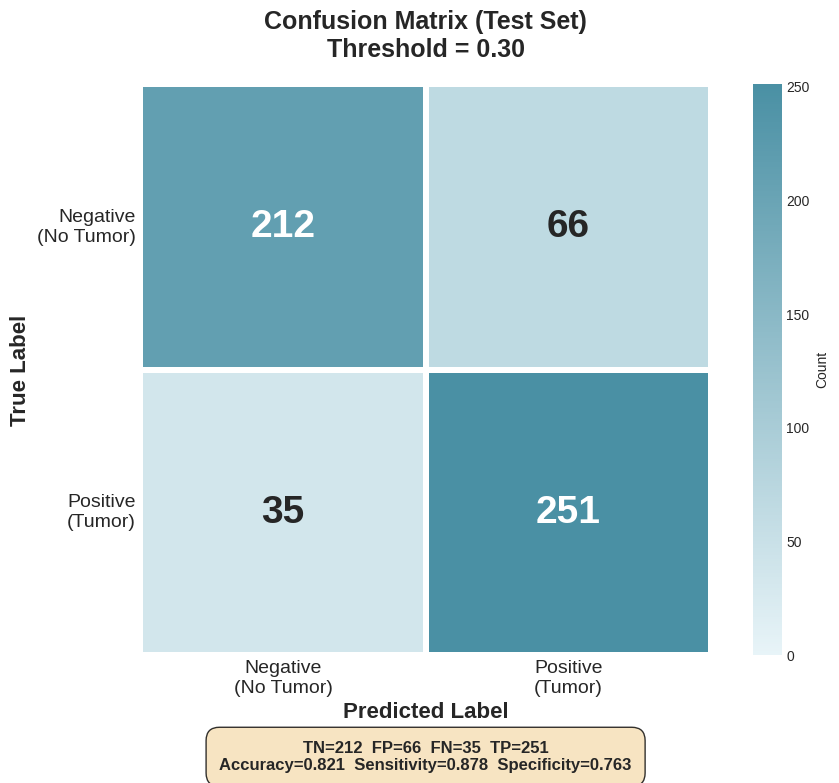

✅ Detection metrics plot saved: test_maskrcnn_eval/detection_metrics.png


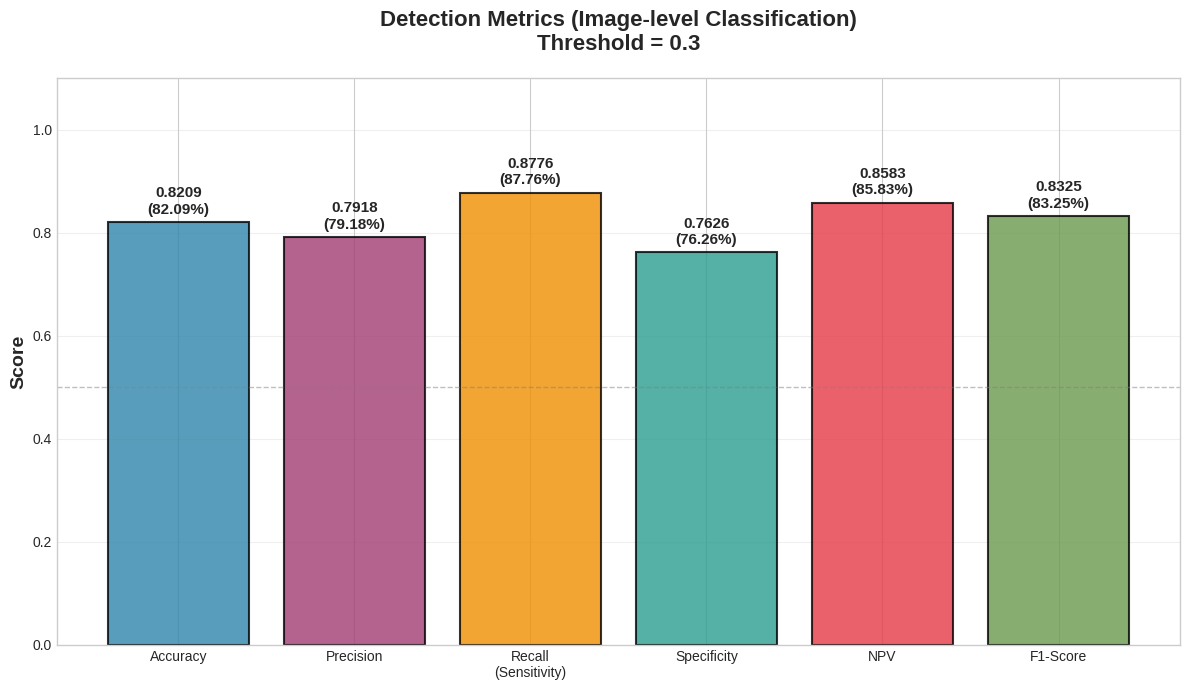

✅ Segmentation metrics plot saved: test_maskrcnn_eval/segmentation_metrics.png


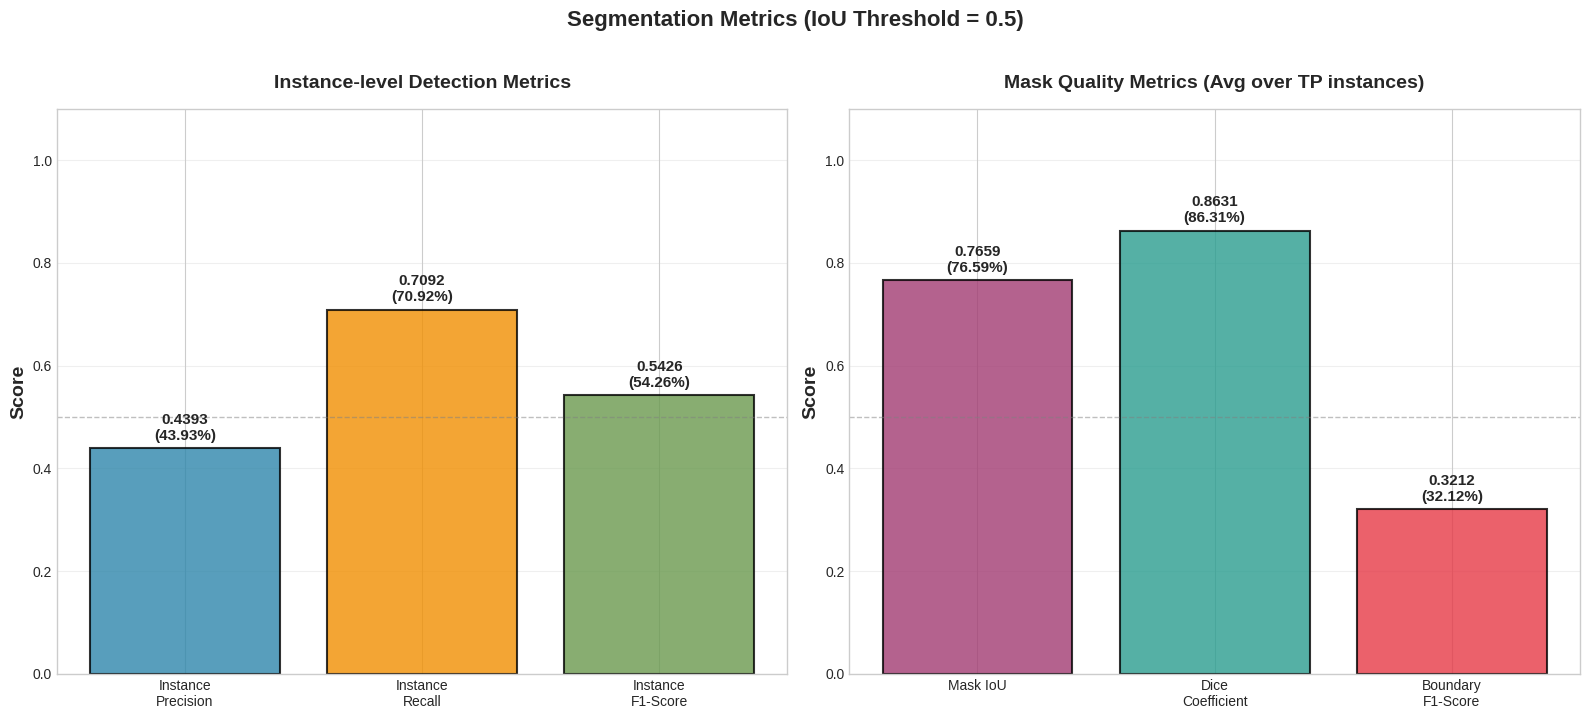

✅ Instance confusion plot saved: test_maskrcnn_eval/instance_confusion.png


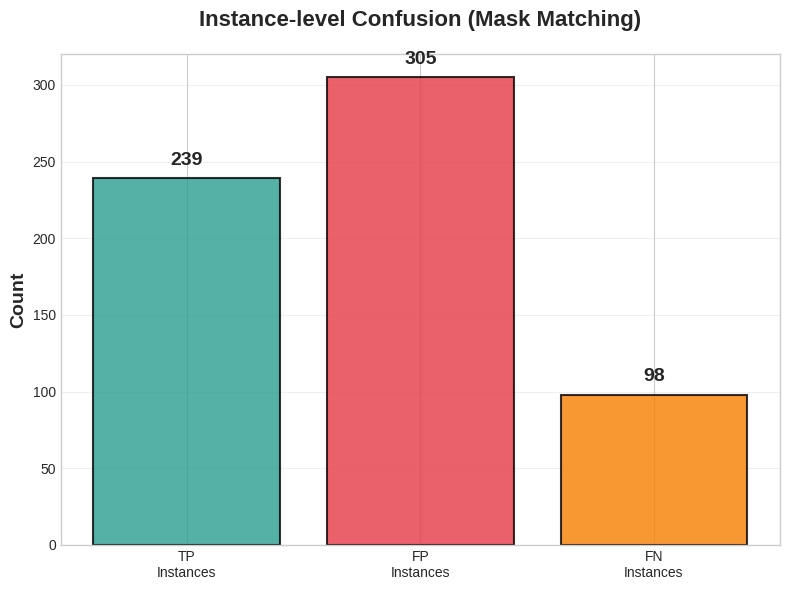


[6/6] Saving results...
✅ Detection summary saved: test_maskrcnn_eval/detection_metrics_summary.json
✅ Segmentation summary saved: test_maskrcnn_eval/segmentation_metrics_summary.json
✅ Per-image results saved: test_maskrcnn_eval/per_image_results.json
✅ Complete summary saved: test_maskrcnn_eval/complete_evaluation_summary.json

✅ EVALUATION COMPLETE!

Generated files in 'test_maskrcnn_eval/':
  ├── confusion_matrix.png
  ├── detection_metrics.png
  ├── segmentation_metrics.png
  ├── instance_confusion.png
  ├── detection_metrics_summary.json
  ├── segmentation_metrics_summary.json
  ├── per_image_results.json
  └── complete_evaluation_summary.json

KEY METRICS SUMMARY:

DETECTION (Image-level):
  Accuracy:  0.8209 (82.09%)
  Precision: 0.7918 (79.18%)
  Recall:    0.8776 (87.76%)
  F1-Score:  0.8325 (83.25%)

SEGMENTATION (Instance-level):
  Precision: 0.4393 (43.93%)
  Recall:    0.7092 (70.92%)
  F1-Score:  0.5426 (54.26%)
  Avg IoU:   0.7659 (76.59%)
  Avg Dice:  0.8631 (86.31%)


In [10]:
"""
MASK R-CNN CONFUSION MATRIX & SEGMENTATION METRICS EVALUATION
==============================================================
Evaluates the trained Mask R-CNN model on the test set and computes:

DETECTION METRICS (Image-level Classification):
- Confusion Matrix (TP, TN, FP, FN)
- Accuracy, Precision, Recall, F1-Score
- Specificity, NPV (Negative Predictive Value)

SEGMENTATION METRICS (Instance-level):
- Mask IoU (Intersection over Union)
- Mask Precision, Recall, F1-Score
- Boundary F1-Score (contour accuracy)
- Dice Coefficient

Uses optimal threshold of 0.15 (from config)

Author: Mask R-CNN Evaluator
Date: 2026-02-08
"""

import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import cv2
from scipy.ndimage import distance_transform_edt
from collections import defaultdict

# Detectron2
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import pycocotools.mask as mask_util

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Evaluation configuration"""
    
    # Paths
    PREPROCESSED_DIR = "preprocessed"
    IMAGES_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/images"
    TEST_JSON = f"{PREPROCESSED_DIR}/coco_annotations/test.json"
    
    # Model paths (UPDATE THESE TO YOUR MODEL PATHS)
    MODEL_CONFIG = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    MODEL_WEIGHTS = "/kaggle/input/maskrcnn-bestmodel/model_best.pth"
    # Alternative paths:
    # MODEL_WEIGHTS = "/kaggle/input/maskrcnn-bestmodel/model_best.pth"
    # MODEL_WEIGHTS = "stage2_regular_maskrcnn_output/model_best_detection.pth"
    
    # Threshold (from training config)
    OPTIMAL_THRESHOLD = 0.30
    
    # Segmentation evaluation settings
    IOU_THRESHOLD = 0.5  # For matching predicted masks to GT masks
    BOUNDARY_THRESHOLD = 2  # pixels for boundary F1-score
    
    # Output
    OUTPUT_DIR = "test_maskrcnn_eval"
    
    NUM_CLASSES = 1
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# ============================================================================
# DATA LOADING
# ============================================================================

def load_coco_json(json_file, image_root):
    """Load COCO annotations with category remapping"""
    
    if not os.path.exists(json_file):
        print(f"❌ JSON not found: {json_file}")
        return []
    
    with open(json_file, 'r') as f:
        coco_data = json.load(f)
    
    img_to_anns = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_to_anns:
            img_to_anns[img_id] = []
        img_to_anns[img_id].append(ann)
    
    dataset_dicts = []
    
    for img_info in coco_data['images']:
        img_path = os.path.join(image_root, img_info['file_name'])
        
        if not os.path.exists(img_path):
            continue
        
        record = {
            "file_name": img_path,
            "image_id": img_info['id'],
            "height": img_info['height'],
            "width": img_info['width']
        }
        
        anns = img_to_anns.get(img_info['id'], [])
        
        # Process annotations
        objs = []
        for ann in anns:
            bbox = ann['bbox']
            if bbox[2] <= 0 or bbox[3] <= 0:
                continue
            
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": ann['segmentation'],
                "category_id": ann['category_id'] - 1,  # COCO to Detectron2
                "iscrowd": 0
            }
            objs.append(obj)
        
        record["annotations"] = objs
        record["has_tumor"] = len(objs) > 0  # Ground truth label
        
        dataset_dicts.append(record)
    
    return dataset_dicts


def register_test_dataset():
    """Register test dataset"""
    
    # Clean up existing registration
    if "btxrd_test" in DatasetCatalog:
        DatasetCatalog.remove("btxrd_test")
    if "btxrd_test" in MetadataCatalog:
        MetadataCatalog.remove("btxrd_test")
    
    DatasetCatalog.register(
        "btxrd_test",
        lambda: load_coco_json(Config.TEST_JSON, Config.IMAGES_DIR)
    )
    
    MetadataCatalog.get("btxrd_test").set(
        thing_classes=["tumor"],
        json_file=Config.TEST_JSON,
        image_root=Config.IMAGES_DIR,
        evaluator_type="coco"
    )
    
    print("✅ Test dataset registered")


# ============================================================================
# MODEL SETUP
# ============================================================================

def setup_predictor():
    """Setup Detectron2 predictor with trained weights"""
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(Config.MODEL_CONFIG))
    
    cfg.MODEL.WEIGHTS = Config.MODEL_WEIGHTS
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = Config.NUM_CLASSES
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = Config.OPTIMAL_THRESHOLD
    cfg.MODEL.DEVICE = Config.DEVICE
    
    # Ensure mask prediction is enabled
    cfg.MODEL.MASK_ON = True
    
    predictor = DefaultPredictor(cfg)
    
    print(f"✅ Model loaded from: {Config.MODEL_WEIGHTS}")
    print(f"✅ Using detection threshold: {Config.OPTIMAL_THRESHOLD}")
    print(f"✅ Using IoU threshold for matching: {Config.IOU_THRESHOLD}")
    
    return predictor


# ============================================================================
# SEGMENTATION UTILITIES
# ============================================================================

def rle_to_mask(segmentation, height, width):
    """Convert RLE segmentation to binary mask"""
    if isinstance(segmentation, list):
        # Polygon format
        rles = mask_util.frPyObjects(segmentation, height, width)
        rle = mask_util.merge(rles)
    elif isinstance(segmentation, dict):
        # Already RLE
        rle = segmentation
    else:
        raise ValueError(f"Unknown segmentation format: {type(segmentation)}")
    
    mask = mask_util.decode(rle)
    return mask


def compute_mask_iou(mask1, mask2):
    """Compute IoU between two binary masks"""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    if union == 0:
        return 0.0
    
    return intersection / union


def compute_dice_coefficient(mask1, mask2):
    """Compute Dice coefficient between two binary masks"""
    intersection = np.logical_and(mask1, mask2).sum()
    
    sum_masks = mask1.sum() + mask2.sum()
    
    if sum_masks == 0:
        return 0.0
    
    return 2 * intersection / sum_masks


def compute_boundary_f1(mask1, mask2, threshold=2):
    """
    Compute boundary F1-score (contour accuracy)
    
    Measures how well the predicted boundary matches the GT boundary
    """
    # Ensure masks are proper uint8 format
    mask1_uint8 = mask1.astype(np.uint8)
    mask2_uint8 = mask2.astype(np.uint8)
    
    # Find contours
    contours1, _ = cv2.findContours(mask1_uint8, 
                                     cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_NONE)
    contours2, _ = cv2.findContours(mask2_uint8, 
                                     cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_NONE)
    
    if len(contours1) == 0 or len(contours2) == 0:
        return 0.0
    
    # Create boundary images with explicit shape and type
    h, w = mask1.shape[:2]
    boundary1 = np.zeros((h, w), dtype=np.uint8)
    boundary2 = np.zeros((h, w), dtype=np.uint8)
    
    cv2.drawContours(boundary1, contours1, -1, 1, 1)
    cv2.drawContours(boundary2, contours2, -1, 1, 1)
    
    # Compute distance transforms
    dist1 = distance_transform_edt(1 - boundary1)
    dist2 = distance_transform_edt(1 - boundary2)
    
    # Count boundary pixels within threshold
    boundary1_coords = np.argwhere(boundary1 > 0)
    boundary2_coords = np.argwhere(boundary2 > 0)
    
    if len(boundary1_coords) == 0 or len(boundary2_coords) == 0:
        return 0.0
    
    # Precision: how many predicted boundary pixels are close to GT
    precision_count = 0
    for coord in boundary2_coords:
        if dist1[coord[0], coord[1]] <= threshold:
            precision_count += 1
    precision = precision_count / len(boundary2_coords)
    
    # Recall: how many GT boundary pixels are close to predicted
    recall_count = 0
    for coord in boundary1_coords:
        if dist2[coord[0], coord[1]] <= threshold:
            recall_count += 1
    recall = recall_count / len(boundary1_coords)
    
    # F1-score
    if precision + recall == 0:
        return 0.0
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1


def match_predictions_to_gt(pred_masks, pred_scores, gt_masks, iou_threshold=0.5):
    """
    Match predicted masks to ground truth masks using IoU
    
    Returns:
    - matched_pairs: list of (pred_idx, gt_idx, iou)
    - unmatched_preds: indices of FP predictions
    - unmatched_gts: indices of FN ground truths
    """
    num_preds = len(pred_masks)
    num_gts = len(gt_masks)
    
    if num_preds == 0:
        return [], [], list(range(num_gts))
    
    if num_gts == 0:
        return [], list(range(num_preds)), []
    
    # Compute IoU matrix
    iou_matrix = np.zeros((num_preds, num_gts))
    for i, pred_mask in enumerate(pred_masks):
        for j, gt_mask in enumerate(gt_masks):
            iou_matrix[i, j] = compute_mask_iou(pred_mask, gt_mask)
    
    # Greedy matching (highest IoU first)
    matched_pairs = []
    unmatched_preds = set(range(num_preds))
    unmatched_gts = set(range(num_gts))
    
    # Sort by IoU (descending)
    sorted_pairs = []
    for i in range(num_preds):
        for j in range(num_gts):
            if iou_matrix[i, j] >= iou_threshold:
                sorted_pairs.append((i, j, iou_matrix[i, j]))
    
    sorted_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Match greedily
    for pred_idx, gt_idx, iou in sorted_pairs:
        if pred_idx in unmatched_preds and gt_idx in unmatched_gts:
            matched_pairs.append((pred_idx, gt_idx, iou))
            unmatched_preds.remove(pred_idx)
            unmatched_gts.remove(gt_idx)
    
    return matched_pairs, list(unmatched_preds), list(unmatched_gts)


# ============================================================================
# EVALUATION
# ============================================================================

def evaluate_test_set(predictor, test_data):
    """
    Evaluate model on test set
    
    Computes:
    1. Image-level classification (for confusion matrix)
    2. Instance-level segmentation metrics
    """
    
    print(f"\n{'='*80}")
    print("EVALUATING ON TEST SET")
    print(f"{'='*80}\n")
    
    # Image-level classification results
    y_true = []  # Ground truth labels (0=normal, 1=tumor)
    y_pred = []  # Predicted labels (0=normal, 1=tumor)
    
    # Instance-level segmentation metrics
    segmentation_metrics = {
        'mask_ious': [],
        'dice_coefficients': [],
        'boundary_f1s': [],
        'tp_instances': 0,  # Correctly detected instances
        'fp_instances': 0,  # False positive instances
        'fn_instances': 0   # Missed instances
    }
    
    results_per_image = []
    
    print(f"Processing {len(test_data)} test images...")
    
    for data in tqdm(test_data, desc="Running inference"):
        img_path = data['file_name']
        has_tumor_gt = data['has_tumor']
        gt_annotations = data['annotations']
        
        # Load image
        image = cv2.imread(img_path)
        
        if image is None:
            print(f"⚠️  Could not load image: {img_path}")
            continue
        
        height, width = image.shape[:2]
        
        # Run inference
        outputs = predictor(image)
        
        # Extract predictions
        instances = outputs["instances"].to("cpu")
        num_detections = len(instances)
        
        # Image-level classification
        has_tumor_pred = num_detections > 0
        
        y_true.append(1 if has_tumor_gt else 0)
        y_pred.append(1 if has_tumor_pred else 0)
        
        # Instance-level evaluation (only if GT has tumors)
        instance_results = []
        
        if has_tumor_gt and len(gt_annotations) > 0:
            # Convert GT masks
            gt_masks = []
            for ann in gt_annotations:
                gt_mask = rle_to_mask(ann['segmentation'], height, width)
                gt_masks.append(gt_mask)
            
            # Convert predicted masks
            pred_masks = []
            pred_scores = []
            if num_detections > 0:
                for i in range(num_detections):
                    pred_mask = instances.pred_masks[i].numpy()
                    pred_masks.append(pred_mask)
                    pred_scores.append(instances.scores[i].item())
            
            # Match predictions to GT
            matched, unmatched_preds, unmatched_gts = match_predictions_to_gt(
                pred_masks, pred_scores, gt_masks, Config.IOU_THRESHOLD
            )
            
            # Compute metrics for matched pairs
            for pred_idx, gt_idx, iou in matched:
                pred_mask = pred_masks[pred_idx]
                gt_mask = gt_masks[gt_idx]
                
                dice = compute_dice_coefficient(pred_mask, gt_mask)
                boundary_f1 = compute_boundary_f1(pred_mask, gt_mask, Config.BOUNDARY_THRESHOLD)
                
                segmentation_metrics['mask_ious'].append(iou)
                segmentation_metrics['dice_coefficients'].append(dice)
                segmentation_metrics['boundary_f1s'].append(boundary_f1)
                segmentation_metrics['tp_instances'] += 1
                
                instance_results.append({
                    'type': 'TP',
                    'iou': float(iou),
                    'dice': float(dice),
                    'boundary_f1': float(boundary_f1),
                    'score': float(pred_scores[pred_idx])
                })
            
            # Count unmatched predictions (FP)
            segmentation_metrics['fp_instances'] += len(unmatched_preds)
            for pred_idx in unmatched_preds:
                instance_results.append({
                    'type': 'FP',
                    'score': float(pred_scores[pred_idx])
                })
            
            # Count unmatched GT (FN)
            segmentation_metrics['fn_instances'] += len(unmatched_gts)
            for gt_idx in unmatched_gts:
                instance_results.append({
                    'type': 'FN'
                })
        
        elif has_tumor_pred and num_detections > 0:
            # False positives (predicted tumor on normal image)
            segmentation_metrics['fp_instances'] += num_detections
            for i in range(num_detections):
                instance_results.append({
                    'type': 'FP',
                    'score': float(instances.scores[i].item())
                })
        
        # Store per-image results
        results_per_image.append({
            'image_path': img_path,
            'image_name': os.path.basename(img_path),
            'gt_has_tumor': has_tumor_gt,
            'gt_num_instances': len(gt_annotations),
            'pred_has_tumor': has_tumor_pred,
            'pred_num_instances': num_detections,
            'detection_scores': instances.scores.numpy().tolist() if num_detections > 0 else [],
            'gt_label': 1 if has_tumor_gt else 0,
            'pred_label': 1 if has_tumor_pred else 0,
            'instance_results': instance_results
        })
    
    return np.array(y_true), np.array(y_pred), segmentation_metrics, results_per_image


# ============================================================================
# METRICS COMPUTATION
# ============================================================================

def compute_detection_metrics(y_true, y_pred):
    """Compute image-level detection metrics from confusion matrix"""
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Extract TP, TN, FP, FN
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle edge case where only one class is present
        if len(np.unique(y_true)) == 1 and len(np.unique(y_pred)) == 1:
            if y_true[0] == 0:  # All negatives
                tn = len(y_true)
                tp = fp = fn = 0
            else:  # All positives
                tp = len(y_true)
                tn = fp = fn = 0
        else:
            print("⚠️  Unexpected confusion matrix shape")
            tn = fp = fn = tp = 0
    
    # Calculate metrics
    total = tn + fp + fn + tp
    
    accuracy = (tp + tn) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics = {
        'confusion_matrix': cm,
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'sensitivity': float(recall),
        'specificity': float(specificity),
        'npv': float(npv),
        'f1_score': float(f1_score),
        'total_samples': int(total)
    }
    
    return metrics


def compute_segmentation_summary(seg_metrics):
    """Compute summary statistics for segmentation metrics"""
    
    tp = seg_metrics['tp_instances']
    fp = seg_metrics['fp_instances']
    fn = seg_metrics['fn_instances']
    
    # Instance-level precision, recall, F1
    instance_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    instance_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    instance_f1 = 2 * (instance_precision * instance_recall) / (instance_precision + instance_recall) if (instance_precision + instance_recall) > 0 else 0
    
    # Average mask metrics (only for TP instances)
    avg_mask_iou = np.mean(seg_metrics['mask_ious']) if seg_metrics['mask_ious'] else 0
    avg_dice = np.mean(seg_metrics['dice_coefficients']) if seg_metrics['dice_coefficients'] else 0
    avg_boundary_f1 = np.mean(seg_metrics['boundary_f1s']) if seg_metrics['boundary_f1s'] else 0
    
    summary = {
        'instance_precision': float(instance_precision),
        'instance_recall': float(instance_recall),
        'instance_f1': float(instance_f1),
        'avg_mask_iou': float(avg_mask_iou),
        'avg_dice_coefficient': float(avg_dice),
        'avg_boundary_f1': float(avg_boundary_f1),
        'tp_instances': int(tp),
        'fp_instances': int(fp),
        'fn_instances': int(fn),
        'total_matched_instances': int(tp)
    }
    
    return summary


# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_confusion_matrix(metrics, output_dir):
    """Create confusion matrix visualization matching the reference image style"""
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    cm = metrics['confusion_matrix']
    tn, fp, fn, tp = metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define custom colormap (blue gradient like reference)
    colors = ['#E8F4F8', '#4A90A4']
    n_bins = 100
    cmap = sns.blend_palette(colors, n_colors=n_bins, as_cmap=True)
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                square=True, cbar_kws={'label': 'Count'},
                linewidths=3, linecolor='white',
                annot_kws={'size': 28, 'weight': 'bold'},
                vmin=0, ax=ax)
    
    # Title
    ax.set_title(f'Confusion Matrix (Test Set)\nThreshold = {Config.OPTIMAL_THRESHOLD:.2f}',
                 fontsize=18, fontweight='bold', pad=20)
    
    # Axis labels
    ax.set_xlabel('Predicted Label', fontsize=16, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=16, fontweight='bold')
    
    # Tick labels
    ax.set_xticklabels(['Negative\n(No Tumor)', 'Positive\n(Tumor)'], fontsize=14)
    ax.set_yticklabels(['Negative\n(No Tumor)', 'Positive\n(Tumor)'], fontsize=14, rotation=0)
    
    # Add metrics box at bottom
    metrics_text = (
        f"TN={tn}  FP={fp}  FN={fn}  TP={tp}\n"
        f"Accuracy={metrics['accuracy']:.3f}  "
        f"Sensitivity={metrics['sensitivity']:.3f}  "
        f"Specificity={metrics['specificity']:.3f}"
    )
    
    ax.text(0.5, -0.15, metrics_text,
            transform=ax.transAxes,
            ha='center', va='top',
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    # Save
    output_path = Path(output_dir) / 'confusion_matrix.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Confusion matrix saved: {output_path}")
    
    plt.show()
    plt.close()


def visualize_detection_metrics(metrics, output_dir):
    """Create bar chart of detection metrics"""
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    metric_names = ['Accuracy', 'Precision', 'Recall\n(Sensitivity)', 
                    'Specificity', 'NPV', 'F1-Score']
    metric_values = [
        metrics['accuracy'],
        metrics['precision'],
        metrics['recall'],
        metrics['specificity'],
        metrics['npv'],
        metrics['f1_score']
    ]
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#2A9D8F', '#E63946', '#6A994E']
    
    bars = ax.bar(metric_names, metric_values, color=colors, alpha=0.8, 
                   edgecolor='black', linewidth=1.5)
    
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.4f}\n({value*100:.2f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax.set_title(f'Detection Metrics (Image-level Classification)\nThreshold = {Config.OPTIMAL_THRESHOLD}',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    plt.tight_layout()
    
    output_path = Path(output_dir) / 'detection_metrics.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Detection metrics plot saved: {output_path}")
    
    plt.show()
    plt.close()


def visualize_segmentation_metrics(seg_summary, output_dir):
    """Create visualization for segmentation metrics"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Instance-level metrics
    metric_names1 = ['Instance\nPrecision', 'Instance\nRecall', 'Instance\nF1-Score']
    metric_values1 = [
        seg_summary['instance_precision'],
        seg_summary['instance_recall'],
        seg_summary['instance_f1']
    ]
    
    colors1 = ['#2E86AB', '#F18F01', '#6A994E']
    bars1 = ax1.bar(metric_names1, metric_values1, color=colors1, alpha=0.8,
                    edgecolor='black', linewidth=1.5)
    
    for bar, value in zip(bars1, metric_values1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.4f}\n({value*100:.2f}%)',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax1.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax1.set_title('Instance-level Detection Metrics', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylim([0, 1.1])
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Plot 2: Mask quality metrics
    metric_names2 = ['Mask IoU', 'Dice\nCoefficient', 'Boundary\nF1-Score']
    metric_values2 = [
        seg_summary['avg_mask_iou'],
        seg_summary['avg_dice_coefficient'],
        seg_summary['avg_boundary_f1']
    ]
    
    colors2 = ['#A23B72', '#2A9D8F', '#E63946']
    bars2 = ax2.bar(metric_names2, metric_values2, color=colors2, alpha=0.8,
                    edgecolor='black', linewidth=1.5)
    
    for bar, value in zip(bars2, metric_values2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.4f}\n({value*100:.2f}%)',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax2.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax2.set_title('Mask Quality Metrics (Avg over TP instances)', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylim([0, 1.1])
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    fig.suptitle(f'Segmentation Metrics (IoU Threshold = {Config.IOU_THRESHOLD})',
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    output_path = Path(output_dir) / 'segmentation_metrics.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Segmentation metrics plot saved: {output_path}")
    
    plt.show()
    plt.close()


def visualize_instance_confusion(seg_summary, output_dir):
    """Create instance-level confusion visualization"""
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    labels = ['TP\nInstances', 'FP\nInstances', 'FN\nInstances']
    values = [
        seg_summary['tp_instances'],
        seg_summary['fp_instances'],
        seg_summary['fn_instances']
    ]
    colors = ['#2A9D8F', '#E63946', '#F77F00']
    
    bars = ax.bar(labels, values, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=1.5)
    
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.02,
                f'{value}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    ax.set_ylabel('Count', fontsize=14, fontweight='bold')
    ax.set_title('Instance-level Confusion (Mask Matching)', fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    output_path = Path(output_dir) / 'instance_confusion.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Instance confusion plot saved: {output_path}")
    
    plt.show()
    plt.close()


# ============================================================================
# RESULTS REPORTING
# ============================================================================

def print_detailed_results(det_metrics, seg_summary, results_per_image):
    """Print comprehensive results"""
    
    print(f"\n{'='*80}")
    print("IMAGE-LEVEL DETECTION CONFUSION MATRIX")
    print(f"{'='*80}\n")
    
    print(det_metrics['confusion_matrix'])
    print()
    
    print(f"True Negatives (TN):  {det_metrics['tn']:4d}  (Correctly identified normal images)")
    print(f"False Positives (FP): {det_metrics['fp']:4d}  (Normal images predicted as tumor)")
    print(f"False Negatives (FN): {det_metrics['fn']:4d}  (Tumor images predicted as normal)")
    print(f"True Positives (TP):  {det_metrics['tp']:4d}  (Correctly identified tumor images)")
    print(f"{'─'*80}")
    print(f"Total Images:         {det_metrics['total_samples']:4d}")
    
    print(f"\n{'='*80}")
    print("IMAGE-LEVEL DETECTION METRICS")
    print(f"{'='*80}\n")
    
    print(f"Accuracy:             {det_metrics['accuracy']:.4f} ({det_metrics['accuracy']*100:.2f}%)")
    print(f"Precision (PPV):      {det_metrics['precision']:.4f} ({det_metrics['precision']*100:.2f}%)")
    print(f"Recall (Sensitivity): {det_metrics['recall']:.4f} ({det_metrics['recall']*100:.2f}%)")
    print(f"Specificity:          {det_metrics['specificity']:.4f} ({det_metrics['specificity']*100:.2f}%)")
    print(f"NPV:                  {det_metrics['npv']:.4f} ({det_metrics['npv']*100:.2f}%)")
    print(f"F1-Score:             {det_metrics['f1_score']:.4f} ({det_metrics['f1_score']*100:.2f}%)")
    
    print(f"\n{'='*80}")
    print("INSTANCE-LEVEL SEGMENTATION METRICS")
    print(f"{'='*80}\n")
    
    print(f"Instance Precision:   {seg_summary['instance_precision']:.4f} ({seg_summary['instance_precision']*100:.2f}%)")
    print(f"Instance Recall:      {seg_summary['instance_recall']:.4f} ({seg_summary['instance_recall']*100:.2f}%)")
    print(f"Instance F1-Score:    {seg_summary['instance_f1']:.4f} ({seg_summary['instance_f1']*100:.2f}%)")
    print()
    print(f"TP Instances:         {seg_summary['tp_instances']:4d}  (Correctly detected tumors)")
    print(f"FP Instances:         {seg_summary['fp_instances']:4d}  (False detections)")
    print(f"FN Instances:         {seg_summary['fn_instances']:4d}  (Missed tumors)")
    
    print(f"\n{'='*80}")
    print("MASK QUALITY METRICS (Averaged over TP instances)")
    print(f"{'='*80}\n")
    
    print(f"Avg Mask IoU:         {seg_summary['avg_mask_iou']:.4f} ({seg_summary['avg_mask_iou']*100:.2f}%)")
    print(f"Avg Dice Coefficient: {seg_summary['avg_dice_coefficient']:.4f} ({seg_summary['avg_dice_coefficient']*100:.2f}%)")
    print(f"Avg Boundary F1:      {seg_summary['avg_boundary_f1']:.4f} ({seg_summary['avg_boundary_f1']*100:.2f}%)")
    
    print(f"\n{'='*80}")
    print("METRIC DEFINITIONS")
    print(f"{'='*80}\n")
    
    print("IMAGE-LEVEL (Detection):")
    print("  Accuracy:    (TP + TN) / Total images")
    print("  Precision:   TP / (TP + FP)  - Of predicted tumor images, % correct")
    print("  Recall:      TP / (TP + FN)  - Of actual tumor images, % detected")
    print("  Specificity: TN / (TN + FP)  - Of normal images, % correctly identified")
    print()
    print("INSTANCE-LEVEL (Segmentation):")
    print("  Precision:   TP_inst / (TP_inst + FP_inst)  - Of detected tumors, % correct")
    print("  Recall:      TP_inst / (TP_inst + FN_inst)  - Of actual tumors, % detected")
    print()
    print("MASK QUALITY:")
    print("  Mask IoU:    Intersection / Union of predicted and GT masks")
    print("  Dice:        2 * Intersection / (Pred + GT) - Harmonic mean of IoU")
    print(f"  Boundary F1: Contour accuracy within {Config.BOUNDARY_THRESHOLD}px threshold")
    
    # Error analysis
    print(f"\n{'='*80}")
    print("ERROR ANALYSIS")
    print(f"{'='*80}\n")
    
    if det_metrics['fp'] > 0:
        print(f"False Positive Images ({det_metrics['fp']}):")
        fp_images = [r for r in results_per_image if not r['gt_has_tumor'] and r['pred_has_tumor']]
        for i, img in enumerate(fp_images[:5], 1):
            print(f"  {i}. {img['image_name']} - {img['pred_num_instances']} detections")
        if len(fp_images) > 5:
            print(f"  ... and {len(fp_images) - 5} more")
    
    if det_metrics['fn'] > 0:
        print(f"\nFalse Negative Images ({det_metrics['fn']}):")
        fn_images = [r for r in results_per_image if r['gt_has_tumor'] and not r['pred_has_tumor']]
        for i, img in enumerate(fn_images[:5], 1):
            print(f"  {i}. {img['image_name']} - Missed {img['gt_num_instances']} tumors")
        if len(fn_images) > 5:
            print(f"  ... and {len(fn_images) - 5} more")
    
    print(f"\n{'='*80}\n")


def save_results(det_metrics, seg_summary, results_per_image, output_dir):
    """Save all results to JSON files"""
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Save detection summary
    detection_summary = {
        'threshold': Config.OPTIMAL_THRESHOLD,
        'confusion_matrix': {
            'tn': det_metrics['tn'],
            'fp': det_metrics['fp'],
            'fn': det_metrics['fn'],
            'tp': det_metrics['tp']
        },
        'detection_metrics': {
            'accuracy': det_metrics['accuracy'],
            'precision': det_metrics['precision'],
            'recall': det_metrics['recall'],
            'sensitivity': det_metrics['sensitivity'],
            'specificity': det_metrics['specificity'],
            'npv': det_metrics['npv'],
            'f1_score': det_metrics['f1_score']
        },
        'total_images': det_metrics['total_samples']
    }
    
    detection_path = Path(output_dir) / 'detection_metrics_summary.json'
    with open(detection_path, 'w') as f:
        json.dump(detection_summary, f, indent=2)
    print(f"✅ Detection summary saved: {detection_path}")
    
    # Save segmentation summary
    segmentation_summary = {
        'iou_threshold': Config.IOU_THRESHOLD,
        'boundary_threshold': Config.BOUNDARY_THRESHOLD,
        'instance_metrics': {
            'precision': seg_summary['instance_precision'],
            'recall': seg_summary['instance_recall'],
            'f1_score': seg_summary['instance_f1']
        },
        'instance_confusion': {
            'tp_instances': seg_summary['tp_instances'],
            'fp_instances': seg_summary['fp_instances'],
            'fn_instances': seg_summary['fn_instances']
        },
        'mask_quality': {
            'avg_mask_iou': seg_summary['avg_mask_iou'],
            'avg_dice_coefficient': seg_summary['avg_dice_coefficient'],
            'avg_boundary_f1': seg_summary['avg_boundary_f1']
        }
    }
    
    segmentation_path = Path(output_dir) / 'segmentation_metrics_summary.json'
    with open(segmentation_path, 'w') as f:
        json.dump(segmentation_summary, f, indent=2)
    print(f"✅ Segmentation summary saved: {segmentation_path}")
    
    # Save per-image results
    results_path = Path(output_dir) / 'per_image_results.json'
    with open(results_path, 'w') as f:
        json.dump(results_per_image, f, indent=2)
    print(f"✅ Per-image results saved: {results_path}")
    
    # Save combined summary
    combined_summary = {
        'model': 'Mask R-CNN',
        'detection_threshold': Config.OPTIMAL_THRESHOLD,
        'iou_threshold': Config.IOU_THRESHOLD,
        'detection': detection_summary,
        'segmentation': segmentation_summary
    }
    
    combined_path = Path(output_dir) / 'complete_evaluation_summary.json'
    with open(combined_path, 'w') as f:
        json.dump(combined_summary, f, indent=2)
    print(f"✅ Complete summary saved: {combined_path}")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    
    print("="*80)
    print("MASK R-CNN TEST SET EVALUATION")
    print("Detection + Segmentation Metrics")
    print("="*80)
    print(f"Detection Threshold: {Config.OPTIMAL_THRESHOLD}")
    print(f"IoU Threshold for Matching: {Config.IOU_THRESHOLD}")
    print(f"Boundary Threshold: {Config.BOUNDARY_THRESHOLD}px")
    print("="*80)
    
    # Check files exist
    if not os.path.exists(Config.TEST_JSON):
        print(f"\n❌ Test JSON not found: {Config.TEST_JSON}")
        return
    
    if not os.path.exists(Config.MODEL_WEIGHTS):
        print(f"\n❌ Model weights not found: {Config.MODEL_WEIGHTS}")
        print("Please update Config.MODEL_WEIGHTS path")
        return
    
    # Setup
    print("\n[1/6] Registering test dataset...")
    register_test_dataset()
    
    test_data = DatasetCatalog.get("btxrd_test")
    print(f"✅ Test set loaded: {len(test_data)} images")
    
    # Count GT statistics
    tumor_images = sum(1 for d in test_data if d['has_tumor'])
    normal_images = len(test_data) - tumor_images
    total_instances = sum(len(d['annotations']) for d in test_data)
    
    print(f"   Tumor images: {tumor_images}")
    print(f"   Normal images: {normal_images}")
    print(f"   Total GT instances: {total_instances}")
    
    print("\n[2/6] Loading trained model...")
    predictor = setup_predictor()
    
    # Evaluate
    print("\n[3/6] Running evaluation...")
    y_true, y_pred, seg_metrics, results_per_image = evaluate_test_set(predictor, test_data)
    
    print(f"\n✅ Evaluation complete!")
    print(f"   Processed: {len(y_true)} images")
    
    # Compute metrics
    print("\n[4/6] Computing metrics...")
    det_metrics = compute_detection_metrics(y_true, y_pred)
    seg_summary = compute_segmentation_summary(seg_metrics)
    
    # Print results
    print_detailed_results(det_metrics, seg_summary, results_per_image)
    
    # Visualize
    print("\n[5/6] Creating visualizations...")
    visualize_confusion_matrix(det_metrics, Config.OUTPUT_DIR)
    visualize_detection_metrics(det_metrics, Config.OUTPUT_DIR)
    visualize_segmentation_metrics(seg_summary, Config.OUTPUT_DIR)
    visualize_instance_confusion(seg_summary, Config.OUTPUT_DIR)
    
    # Save results
    print("\n[6/6] Saving results...")
    save_results(det_metrics, seg_summary, results_per_image, Config.OUTPUT_DIR)
    
    # Final summary
    print(f"\n{'='*80}")
    print("✅ EVALUATION COMPLETE!")
    print(f"{'='*80}")
    print(f"\nGenerated files in '{Config.OUTPUT_DIR}/':")
    print(f"  ├── confusion_matrix.png")
    print(f"  ├── detection_metrics.png")
    print(f"  ├── segmentation_metrics.png")
    print(f"  ├── instance_confusion.png")
    print(f"  ├── detection_metrics_summary.json")
    print(f"  ├── segmentation_metrics_summary.json")
    print(f"  ├── per_image_results.json")
    print(f"  └── complete_evaluation_summary.json")
    
    print(f"\n{'='*80}")
    print("KEY METRICS SUMMARY:")
    print(f"{'='*80}")
    print("\nDETECTION (Image-level):")
    print(f"  Accuracy:  {det_metrics['accuracy']:.4f} ({det_metrics['accuracy']*100:.2f}%)")
    print(f"  Precision: {det_metrics['precision']:.4f} ({det_metrics['precision']*100:.2f}%)")
    print(f"  Recall:    {det_metrics['recall']:.4f} ({det_metrics['recall']*100:.2f}%)")
    print(f"  F1-Score:  {det_metrics['f1_score']:.4f} ({det_metrics['f1_score']*100:.2f}%)")
    
    print("\nSEGMENTATION (Instance-level):")
    print(f"  Precision: {seg_summary['instance_precision']:.4f} ({seg_summary['instance_precision']*100:.2f}%)")
    print(f"  Recall:    {seg_summary['instance_recall']:.4f} ({seg_summary['instance_recall']*100:.2f}%)")
    print(f"  F1-Score:  {seg_summary['instance_f1']:.4f} ({seg_summary['instance_f1']*100:.2f}%)")
    print(f"  Avg IoU:   {seg_summary['avg_mask_iou']:.4f} ({seg_summary['avg_mask_iou']*100:.2f}%)")
    print(f"  Avg Dice:  {seg_summary['avg_dice_coefficient']:.4f} ({seg_summary['avg_dice_coefficient']*100:.2f}%)")
    print(f"{'='*80}\n")


if __name__ == "__main__":
    main()

In [15]:
"""
MASK R-CNN IMAGE-LEVEL EVALUATION (MAX AGGREGATION METHOD)
===========================================================
Uses IMAGE-LEVEL classification with MAX AGGREGATION.

For each image:
- Score = maximum detection score (0 if no detections)
- GT Label = 1 if image has tumor annotations, 0 otherwise

This creates a binary classification problem suitable for:
- Precision-Recall Curve + PR-AUC
- ROC Curve + ROC-AUC
- F1-Score vs Threshold
- Confusion Matrix (image-level)

Max aggregation is standard for converting object detection to image classification.

Author: Image-Level Evaluator
Date: 2026-02-08
"""

import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import (precision_recall_curve, roc_curve, auc,
                             average_precision_score, confusion_matrix)

# Detectron2
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Evaluation configuration"""
    
    # Paths
    PREPROCESSED_DIR = "preprocessed"
    IMAGES_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/images"
    TEST_JSON = f"{PREPROCESSED_DIR}/coco_annotations/test.json"
    
    # Model paths (UPDATE THESE)
    MODEL_CONFIG = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    MODEL_WEIGHTS = "/kaggle/input/maskrcnn-bestmodel/model_best.pth"
    # Alternative: MODEL_WEIGHTS = "/kaggle/input/maskrcnn-bestmodel/model_best.pth"
    
    # Evaluation parameters
    OPTIMAL_SCORE_THRESHOLD = 0.30  # From training config
    
    # Output
    OUTPUT_DIR = "maskrcnn_image_level"
    
    NUM_CLASSES = 1
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# ============================================================================
# DATA LOADING
# ============================================================================

def load_coco_json(json_file, image_root):
    """Load COCO annotations"""
    
    if not os.path.exists(json_file):
        print(f"❌ JSON not found: {json_file}")
        return []
    
    with open(json_file, 'r') as f:
        coco_data = json.load(f)
    
    img_to_anns = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_to_anns:
            img_to_anns[img_id] = []
        img_to_anns[img_id].append(ann)
    
    dataset_dicts = []
    
    for img_info in coco_data['images']:
        img_path = os.path.join(image_root, img_info['file_name'])
        
        if not os.path.exists(img_path):
            continue
        
        record = {
            "file_name": img_path,
            "image_id": img_info['id'],
            "height": img_info['height'],
            "width": img_info['width']
        }
        
        anns = img_to_anns.get(img_info['id'], [])
        record["annotations"] = anns
        record["has_tumor"] = len(anns) > 0  # Ground truth label
        
        dataset_dicts.append(record)
    
    return dataset_dicts


def register_test_dataset():
    """Register test dataset"""
    
    if "btxrd_test" in DatasetCatalog:
        DatasetCatalog.remove("btxrd_test")
    if "btxrd_test" in MetadataCatalog:
        MetadataCatalog.remove("btxrd_test")
    
    DatasetCatalog.register(
        "btxrd_test",
        lambda: load_coco_json(Config.TEST_JSON, Config.IMAGES_DIR)
    )
    
    MetadataCatalog.get("btxrd_test").set(
        thing_classes=["tumor"],
        json_file=Config.TEST_JSON,
        image_root=Config.IMAGES_DIR
    )
    
    print("✅ Test dataset registered")


# ============================================================================
# MODEL SETUP
# ============================================================================

def setup_predictor():
    """Setup predictor with no score threshold"""
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(Config.MODEL_CONFIG))
    
    cfg.MODEL.WEIGHTS = Config.MODEL_WEIGHTS
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = Config.NUM_CLASSES
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # Get all predictions
    cfg.MODEL.MASK_ON = True
    cfg.MODEL.DEVICE = Config.DEVICE
    
    predictor = DefaultPredictor(cfg)
    
    print(f"✅ Model loaded from: {Config.MODEL_WEIGHTS}")
    
    return predictor


# ============================================================================
# IMAGE-LEVEL EVALUATION (MAX AGGREGATION)
# ============================================================================

def evaluate_image_level_max_aggregation(predictor, test_data):
    """
    Image-level evaluation using MAX AGGREGATION
    
    For each image:
    - Prediction score = max detection score (or 0 if no detections)
    - GT label = 1 if image has tumor, 0 otherwise
    
    Returns:
    - image_scores: Array of image-level scores
    - image_labels: Array of ground truth labels (0 or 1)
    - per_image_results: Detailed results per image
    """
    
    print(f"\n{'='*80}")
    print("IMAGE-LEVEL EVALUATION (MAX AGGREGATION METHOD)")
    print(f"{'='*80}\n")
    print(f"Processing {len(test_data)} test images...")
    print("Aggregation: Taking MAX detection score per image\n")
    
    image_scores = []
    image_labels = []
    per_image_results = []
    
    num_positive_images = 0
    num_negative_images = 0
    
    for data in tqdm(test_data, desc="Evaluating images"):
        img_path = data['file_name']
        has_tumor_gt = data['has_tumor']
        
        # Ground truth label
        gt_label = 1 if has_tumor_gt else 0
        
        if has_tumor_gt:
            num_positive_images += 1
        else:
            num_negative_images += 1
        
        # Load and predict
        import cv2
        image = cv2.imread(img_path)
        
        if image is None:
            continue
        
        outputs = predictor(image)
        instances = outputs["instances"].to("cpu")
        
        # MAX AGGREGATION: Take maximum detection score
        if len(instances) > 0:
            max_score = float(instances.scores.max().item())
            num_detections = len(instances)
            all_scores = instances.scores.numpy().tolist()
        else:
            max_score = 0.0
            num_detections = 0
            all_scores = []
        
        image_scores.append(max_score)
        image_labels.append(gt_label)
        
        per_image_results.append({
            'image_name': os.path.basename(img_path),
            'image_path': img_path,
            'gt_label': int(gt_label),
            'gt_has_tumor': bool(has_tumor_gt),
            'max_score': float(max_score),
            'num_detections': int(num_detections),
            'all_detection_scores': all_scores
        })
    
    image_scores = np.array(image_scores)
    image_labels = np.array(image_labels)
    
    print(f"\n✅ Image-level evaluation complete!")
    print(f"\n   Total images:         {len(image_scores)}")
    print(f"   Positive images (GT): {num_positive_images}")
    print(f"   Negative images (GT): {num_negative_images}")
    print(f"   Score range:          [{image_scores.min():.4f}, {image_scores.max():.4f}]")
    
    return image_scores, image_labels, per_image_results


# ============================================================================
# METRICS COMPUTATION
# ============================================================================

def compute_all_metrics(scores, labels, threshold=0.15):
    """Compute all metrics at given threshold and for curves"""
    
    # Binary predictions at threshold
    predictions_binary = (scores >= threshold).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(labels, predictions_binary)
    
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle edge cases
        if len(np.unique(labels)) == 1:
            if labels[0] == 0:  # All negatives
                tn = len(labels)
                tp = fp = fn = 0
            else:  # All positives
                tp = len(labels)
                tn = fp = fn = 0
        else:
            tn = fp = fn = tp = 0
    
    # Metrics at threshold
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # PR Curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(labels, scores)
    pr_auc = auc(recall_curve, precision_curve)
    average_precision = average_precision_score(labels, scores)
    
    # Compute F1 for each threshold
    f1_scores = []
    for p, r in zip(precision_curve[:-1], recall_curve[:-1]):
        if p + r > 0:
            f1 = 2 * (p * r) / (p + r)
        else:
            f1 = 0
        f1_scores.append(f1)
    f1_scores = np.array(f1_scores)
    
    # Find optimal threshold by F1
    if len(f1_scores) > 0:
        best_f1_idx = np.argmax(f1_scores)
        optimal_threshold = pr_thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
    else:
        optimal_threshold = 0.5
        best_f1 = 0
    
    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    
    results = {
        # Confusion matrix
        'confusion_matrix': cm,
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp),
        
        # Metrics at threshold
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'sensitivity': recall,
        'specificity': specificity,
        'npv': npv,
        'f1_score': f1_score,
        
        # Curve data
        'pr_precision': precision_curve,
        'pr_recall': recall_curve,
        'pr_thresholds': pr_thresholds,
        'pr_auc': pr_auc,
        'average_precision': average_precision,
        
        'roc_fpr': fpr,
        'roc_tpr': tpr,
        'roc_thresholds': roc_thresholds,
        'roc_auc': roc_auc,
        
        'f1_scores': f1_scores,
        'optimal_threshold': optimal_threshold,
        'best_f1': best_f1,
        
        # Dataset stats
        'total_images': total
    }
    
    return results


# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_pr_curve(results, output_dir):
    """Save PR Curve"""
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    pr_recall = results['pr_recall']
    pr_precision = results['pr_precision']
    pr_auc = results['pr_auc']
    avg_precision = results['average_precision']
    
    ax.plot(pr_recall, pr_precision, linewidth=3, color='#2E86AB',
            label=f'PR-AUC = {pr_auc:.4f}')
    ax.fill_between(pr_recall, pr_precision, alpha=0.2, color='#2E86AB')
    
    # Mark optimal point
    if len(results['f1_scores']) > 0:
        opt_idx = np.argmax(results['f1_scores'])
        if opt_idx < len(pr_recall) - 1:
            ax.plot(pr_recall[opt_idx], pr_precision[opt_idx], 'r*',
                    markersize=20, label=f'Optimal (F1={results["best_f1"]:.3f})')
    
    ax.set_xlabel('Recall', fontsize=14, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=14, fontweight='bold')
    ax.set_title(f'Precision-Recall Curve (Image-Level, Max Aggregation)\nAverage Precision = {avg_precision:.4f}',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='lower left', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'image_level_pr_curve.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


def plot_roc_curve(results, output_dir):
    """Save ROC Curve"""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    fpr = results['roc_fpr']
    tpr = results['roc_tpr']
    roc_auc = results['roc_auc']
    
    ax.plot(fpr, tpr, linewidth=3, color='#E63946',
            label=f'ROC-AUC = {roc_auc:.4f}')
    ax.fill_between(fpr, tpr, alpha=0.2, color='#E63946')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Random Classifier')
    
    ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=14, fontweight='bold')
    ax.set_title('ROC Curve (Image-Level, Max Aggregation)',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'image_level_roc_curve.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


def plot_f1_vs_threshold(results, output_dir):
    """Save F1 vs Threshold"""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    thresholds = results['pr_thresholds']
    f1_scores = results['f1_scores']
    
    ax.plot(thresholds, f1_scores, linewidth=3, color='#F18F01')
    ax.fill_between(thresholds, f1_scores, alpha=0.2, color='#F18F01')
    
    # Mark optimal and current threshold
    opt_thresh = results['optimal_threshold']
    ax.axvline(x=opt_thresh, color='red', linestyle='--', linewidth=2.5,
               label=f'Optimal Threshold = {opt_thresh:.3f}')
    ax.axvline(x=results['threshold'], color='green', linestyle='--', linewidth=2.5,
               label=f'Current Threshold = {results["threshold"]:.3f}')
    
    ax.plot(opt_thresh, results['best_f1'], 'r*', markersize=25)
    
    # Add annotation
    ax.annotate(f'Max F1 = {results["best_f1"]:.4f}\nat θ = {opt_thresh:.3f}',
                xy=(opt_thresh, results['best_f1']),
                xytext=(opt_thresh + 0.15, results['best_f1'] - 0.08),
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                arrowprops=dict(arrowstyle='->', lw=2, color='red'))
    
    ax.set_xlabel('Score Threshold', fontsize=14, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
    ax.set_title('F1-Score vs Threshold (Image-Level)', fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, max(1.0, results['best_f1'] + 0.1)])
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'image_level_f1_vs_threshold.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


def plot_confusion_matrix(results, output_dir):
    """Save Confusion Matrix"""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    cm = results['confusion_matrix']
    tn, fp, fn, tp = results['tn'], results['fp'], results['fn'], results['tp']
    
    # Custom colormap
    colors = ['#E8F4F8', '#4A90A4']
    cmap = sns.blend_palette(colors, n_colors=100, as_cmap=True)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                square=True, cbar_kws={'label': 'Count'},
                linewidths=3, linecolor='white',
                annot_kws={'size': 28, 'weight': 'bold'},
                vmin=0, ax=ax)
    
    ax.set_title(f'Confusion Matrix (Image-Level, Max Aggregation)\nThreshold = {results["threshold"]:.2f}',
                 fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Predicted Label', fontsize=16, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=16, fontweight='bold')
    ax.set_xticklabels(['Negative\n(No Tumor)', 'Positive\n(Tumor)'], fontsize=14)
    ax.set_yticklabels(['Negative\n(No Tumor)', 'Positive\n(Tumor)'], fontsize=14, rotation=0)
    
    # Add metrics box
    metrics_text = (
        f"TN={tn}  FP={fp}  FN={fn}  TP={tp}\n"
        f"Accuracy={results['accuracy']:.3f}  "
        f"Sensitivity={results['sensitivity']:.3f}  "
        f"Specificity={results['specificity']:.3f}"
    )
    
    ax.text(0.5, -0.15, metrics_text,
            transform=ax.transAxes,
            ha='center', va='top',
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'image_level_confusion_matrix.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


def plot_metrics_vs_threshold(results, output_dir):
    """Save Metrics vs Threshold"""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    thresholds = results['pr_thresholds']
    
    # Sample for cleaner plot
    sample_thresholds = thresholds[::max(1, len(thresholds)//50)]
    sample_precision = results['pr_precision'][:-1][::max(1, len(thresholds)//50)]
    sample_recall = results['pr_recall'][:-1][::max(1, len(thresholds)//50)]
    sample_f1 = results['f1_scores'][::max(1, len(results['f1_scores'])//50)]
    
    ax.plot(sample_thresholds, sample_precision, 'o-', linewidth=2.5,
            markersize=5, color='#2E86AB', label='Precision', alpha=0.8)
    ax.plot(sample_thresholds, sample_recall, 's-', linewidth=2.5,
            markersize=5, color='#F18F01', label='Recall', alpha=0.8)
    ax.plot(sample_thresholds, sample_f1, '^-', linewidth=3,
            markersize=6, color='#E63946', label='F1-Score', alpha=0.9)
    
    ax.axvline(x=results['threshold'], color='green', linestyle='--',
               linewidth=2.5, alpha=0.7, label=f'Current Threshold = {results["threshold"]:.2f}')
    
    ax.set_xlabel('Score Threshold', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax.set_title('Precision, Recall, and F1-Score vs Threshold (Image-Level)',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='best', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'image_level_metrics_vs_threshold.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


def plot_metrics_table(results, output_dir):
    """Save Metrics Summary Table"""
    
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.axis('off')
    
    table_data = [
        ['Metric', 'Value'],
        ['', ''],
        ['Evaluation Method:', ''],
        ['  Type', 'Image-Level Classification'],
        ['  Aggregation', 'MAX (maximum detection score)'],
        ['', ''],
        ['Dataset Statistics:', ''],
        ['  Total images', f'{results["total_images"]}'],
        ['  Positive images (GT)', f'{results["tp"] + results["fn"]}'],
        ['  Negative images (GT)', f'{results["tn"] + results["fp"]}'],
        ['', ''],
        [f'Confusion Matrix (Threshold = {results["threshold"]}):', ''],
        ['  True Negatives (TN)', f'{results["tn"]}'],
        ['  False Positives (FP)', f'{results["fp"]}'],
        ['  False Negatives (FN)', f'{results["fn"]}'],
        ['  True Positives (TP)', f'{results["tp"]}'],
        ['', ''],
        ['Classification Metrics:', ''],
        ['  Accuracy', f'{results["accuracy"]:.4f} ({results["accuracy"]*100:.2f}%)'],
        ['  Precision (PPV)', f'{results["precision"]:.4f} ({results["precision"]*100:.2f}%)'],
        ['  Recall (Sensitivity)', f'{results["recall"]:.4f} ({results["recall"]*100:.2f}%)'],
        ['  Specificity', f'{results["specificity"]:.4f} ({results["specificity"]*100:.2f}%)'],
        ['  NPV', f'{results["npv"]:.4f} ({results["npv"]*100:.2f}%)'],
        ['  F1-Score', f'{results["f1_score"]:.4f} ({results["f1_score"]*100:.2f}%)'],
        ['', ''],
        ['Curve Metrics (Threshold-Independent):', ''],
        ['  PR-AUC', f'{results["pr_auc"]:.6f}'],
        ['  Average Precision (AP)', f'{results["average_precision"]:.6f}'],
        ['  ROC-AUC', f'{results["roc_auc"]:.6f}'],
        ['', ''],
        ['Optimal Threshold Analysis:', ''],
        ['  Optimal Threshold', f'{results["optimal_threshold"]:.6f}'],
        ['  Best F1-Score', f'{results["best_f1"]:.6f}'],
    ]
    
    table = ax.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.2)
    
    # Style header
    for i in range(2):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=13)
    
    # Style section headers
    for i in [2, 6, 11, 17, 25, 30]:
        table[(i, 0)].set_facecolor('#E6F2F5')
        table[(i, 0)].set_text_props(weight='bold', fontsize=11)
    
    # Style separator rows
    for i in [1, 5, 10, 16, 24, 29]:
        for j in range(2):
            table[(i, j)].set_facecolor('#F5F5F5')
    
    # Highlight curve metrics
    for i in [26, 27, 28]:
        table[(i, 1)].set_facecolor('#C8E6C9')
        table[(i, 1)].set_text_props(weight='bold')
    
    ax.set_title('Image-Level Performance Metrics (Max Aggregation)',
                 fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'image_level_metrics_table.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


# ============================================================================
# RESULTS SAVING
# ============================================================================

def save_results(results, per_image_results, output_dir):
    """Save all results to JSON"""
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    save_data = {
        'model': 'Mask R-CNN',
        'evaluation_type': 'IMAGE-LEVEL (Max Aggregation)',
        'aggregation_method': 'MAX (maximum detection score per image)',
        'score_threshold': float(results['threshold']),
        
        'confusion_matrix': {
            'tn': int(results['tn']),
            'fp': int(results['fp']),
            'fn': int(results['fn']),
            'tp': int(results['tp'])
        },
        
        'metrics_at_threshold': {
            'accuracy': float(results['accuracy']),
            'precision': float(results['precision']),
            'recall': float(results['recall']),
            'sensitivity': float(results['sensitivity']),
            'specificity': float(results['specificity']),
            'npv': float(results['npv']),
            'f1_score': float(results['f1_score'])
        },
        
        'curve_metrics': {
            'pr_auc': float(results['pr_auc']),
            'average_precision': float(results['average_precision']),
            'roc_auc': float(results['roc_auc'])
        },
        
        'optimal_threshold': {
            'threshold': float(results['optimal_threshold']),
            'f1_score': float(results['best_f1'])
        },
        
        'dataset_statistics': {
            'total_images': int(results['total_images']),
            'positive_images': int(results['tp']) + int(results['fn']),
            'negative_images': int(results['tn']) + int(results['fp'])
        }
    }
    
    # Save summary
    summary_path = Path(output_dir) / 'image_level_summary.json'
    with open(summary_path, 'w') as f:
        json.dump(save_data, f, indent=2)
    print(f"✅ Saved: {summary_path}")
    
    # Save per-image results
    per_image_path = Path(output_dir) / 'per_image_results.json'
    with open(per_image_path, 'w') as f:
        json.dump(per_image_results, f, indent=2)
    print(f"✅ Saved: {per_image_path}")


def print_summary(results):
    """Print detailed summary"""
    
    print(f"\n{'='*80}")
    print("IMAGE-LEVEL EVALUATION SUMMARY (MAX AGGREGATION)")
    print(f"{'='*80}\n")
    
    print(f"Evaluation Type: IMAGE-LEVEL Classification")
    print(f"Aggregation Method: MAX (maximum detection score per image)")
    print(f"Score Threshold: {results['threshold']}")
    
    print(f"\n{'─'*80}")
    print("Dataset Statistics:")
    print(f"{'─'*80}")
    print(f"  Total images:     {results['total_images']}")
    print(f"  Positive images:  {results['tp'] + results['fn']}")
    print(f"  Negative images:  {results['tn'] + results['fp']}")
    
    print(f"\n{'─'*80}")
    print(f"Confusion Matrix (at threshold = {results['threshold']}):")
    print(f"{'─'*80}")
    print(results['confusion_matrix'])
    print()
    print(f"  True Negatives (TN):  {results['tn']:4d}")
    print(f"  False Positives (FP): {results['fp']:4d}")
    print(f"  False Negatives (FN): {results['fn']:4d}")
    print(f"  True Positives (TP):  {results['tp']:4d}")
    
    print(f"\n{'─'*80}")
    print("Classification Metrics at Threshold:")
    print(f"{'─'*80}")
    print(f"  Accuracy:    {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
    print(f"  Precision:   {results['precision']:.4f} ({results['precision']*100:.2f}%)")
    print(f"  Recall:      {results['recall']:.4f} ({results['recall']*100:.2f}%)")
    print(f"  Specificity: {results['specificity']:.4f} ({results['specificity']*100:.2f}%)")
    print(f"  NPV:         {results['npv']:.4f} ({results['npv']*100:.2f}%)")
    print(f"  F1-Score:    {results['f1_score']:.4f} ({results['f1_score']*100:.2f}%)")
    
    print(f"\n{'─'*80}")
    print("Curve Metrics (Threshold-Independent):")
    print(f"{'─'*80}")
    print(f"  PR-AUC:              {results['pr_auc']:.6f}")
    print(f"  Average Precision:   {results['average_precision']:.6f}")
    print(f"  ROC-AUC:             {results['roc_auc']:.6f}")
    
    print(f"\n{'─'*80}")
    print("Optimal Threshold (Max F1):")
    print(f"{'─'*80}")
    print(f"  Threshold:  {results['optimal_threshold']:.6f}")
    print(f"  F1-Score:   {results['best_f1']:.6f}")
    
    print(f"\n{'='*80}\n")


# ============================================================================
# MAIN
# ============================================================================

def main():
    """Main execution"""
    
    print("="*80)
    print("MASK R-CNN IMAGE-LEVEL EVALUATION (MAX AGGREGATION)")
    print("="*80)
    print("Converts object detection to image classification")
    print("Using MAX aggregation: score = max detection score per image")
    print(f"Threshold: {Config.OPTIMAL_SCORE_THRESHOLD}")
    print("="*80)
    
    # Check files
    if not os.path.exists(Config.TEST_JSON):
        print(f"\n❌ Test JSON not found: {Config.TEST_JSON}")
        return
    
    if not os.path.exists(Config.MODEL_WEIGHTS):
        print(f"\n❌ Model weights not found: {Config.MODEL_WEIGHTS}")
        return
    
    # Setup
    print("\n[1/5] Registering test dataset...")
    register_test_dataset()
    test_data = DatasetCatalog.get("btxrd_test")
    print(f"✅ Test set: {len(test_data)} images")
    
    print("\n[2/5] Loading model...")
    predictor = setup_predictor()
    
    # Evaluate
    print("\n[3/5] Running image-level evaluation...")
    scores, labels, per_image_results = evaluate_image_level_max_aggregation(
        predictor, test_data
    )
    
    # Compute metrics
    print("\n[4/5] Computing all metrics...")
    results = compute_all_metrics(scores, labels, Config.OPTIMAL_SCORE_THRESHOLD)
    
    # Print summary
    print_summary(results)
    
    # Create figures
    print(f"\n[5/5] Creating and saving figures...")
    print(f"{'─'*80}")
    
    plot_pr_curve(results, Config.OUTPUT_DIR)
    plot_roc_curve(results, Config.OUTPUT_DIR)
    plot_f1_vs_threshold(results, Config.OUTPUT_DIR)
    plot_confusion_matrix(results, Config.OUTPUT_DIR)
    plot_metrics_vs_threshold(results, Config.OUTPUT_DIR)
    plot_metrics_table(results, Config.OUTPUT_DIR)
    
    # Save results
    print(f"{'─'*80}")
    save_results(results, per_image_results, Config.OUTPUT_DIR)
    
    # Final message
    print(f"\n{'='*80}")
    print("✅ EVALUATION COMPLETE!")
    print(f"{'='*80}")
    print(f"\nGenerated files in '{Config.OUTPUT_DIR}/':")
    print(f"  ├── image_level_pr_curve.png")
    print(f"  ├── image_level_roc_curve.png")
    print(f"  ├── image_level_f1_vs_threshold.png")
    print(f"  ├── image_level_confusion_matrix.png")
    print(f"  ├── image_level_metrics_vs_threshold.png")
    print(f"  ├── image_level_metrics_table.png")
    print(f"  ├── image_level_summary.json")
    print(f"  └── per_image_results.json")
    print(f"\n{'='*80}")
    print("\nKey Metrics for Journal:")
    print(f"  PR-AUC:      {results['pr_auc']:.4f}")
    print(f"  AP:          {results['average_precision']:.4f}")
    print(f"  ROC-AUC:     {results['roc_auc']:.4f}")
    print(f"  Accuracy:    {results['accuracy']:.4f}")
    print(f"  Precision:   {results['precision']:.4f}")
    print(f"  Recall:      {results['recall']:.4f}")
    print(f"  F1-Score:    {results['f1_score']:.4f}")
    print(f"  Specificity: {results['specificity']:.4f}")
    print(f"{'='*80}\n")


if __name__ == "__main__":
    main()

MASK R-CNN IMAGE-LEVEL EVALUATION (MAX AGGREGATION)
Converts object detection to image classification
Using MAX aggregation: score = max detection score per image
Threshold: 0.3

[1/5] Registering test dataset...
✅ Test dataset registered
✅ Test set: 564 images

[2/5] Loading model...
✅ Model loaded from: /kaggle/input/maskrcnn-bestmodel/model_best.pth

[3/5] Running image-level evaluation...

IMAGE-LEVEL EVALUATION (MAX AGGREGATION METHOD)

Processing 564 test images...
Aggregation: Taking MAX detection score per image



Evaluating images: 100%|██████████| 564/564 [05:51<00:00,  1.61it/s]



✅ Image-level evaluation complete!

   Total images:         564
   Positive images (GT): 286
   Negative images (GT): 278
   Score range:          [0.0003, 0.9890]

[4/5] Computing all metrics...

IMAGE-LEVEL EVALUATION SUMMARY (MAX AGGREGATION)

Evaluation Type: IMAGE-LEVEL Classification
Aggregation Method: MAX (maximum detection score per image)
Score Threshold: 0.3

────────────────────────────────────────────────────────────────────────────────
Dataset Statistics:
────────────────────────────────────────────────────────────────────────────────
  Total images:     564
  Positive images:  286
  Negative images:  278

────────────────────────────────────────────────────────────────────────────────
Confusion Matrix (at threshold = 0.3):
────────────────────────────────────────────────────────────────────────────────
[[212  66]
 [ 35 251]]

  True Negatives (TN):   212
  False Positives (FP):   66
  False Negatives (FN):   35
  True Positives (TP):   251

────────────────────────────

In [13]:
"""
MASK R-CNN DETECTION-LEVEL EVALUATION (JOURNAL STANDARD)
=========================================================
Uses DETECTION-LEVEL (box-level) metrics suitable for journal papers.

Each predicted bounding box is matched to ground truth boxes using IoU threshold.
- TP: Detection with IoU ≥ 0.5 with GT box
- FP: Detection with IoU < 0.5 or extra detections
- FN: GT boxes that weren't detected

Computes and saves as INDIVIDUAL FIGURES:
1. Precision-Recall Curve + PR-AUC
2. ROC Curve + ROC-AUC  
3. F1-Score vs Threshold
4. Confusion Matrix
5. Precision/Recall/F1 vs Threshold
6. Metrics Summary Table

Optimal threshold: 0.15 (from config)

Author: Detection-Level Metrics Evaluator
Date: 2026-02-08
"""

import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import (precision_recall_curve, roc_curve, auc, 
                             average_precision_score, confusion_matrix)

# Detectron2
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Evaluation configuration"""
    
    # Paths
    PREPROCESSED_DIR = "preprocessed"
    IMAGES_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/images"
    TEST_JSON = f"{PREPROCESSED_DIR}/coco_annotations/test.json"
    
    # Model paths (UPDATE THESE)
    MODEL_CONFIG = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    MODEL_WEIGHTS = "/kaggle/input/maskrcnn-bestmodel/model_best.pth"
    # Alternative: MODEL_WEIGHTS = "/kaggle/input/maskrcnn-bestmodel/model_best.pth"
    
    # Evaluation parameters
    IOU_THRESHOLD = 0.5  # Standard COCO IoU threshold for TP/FP
    OPTIMAL_SCORE_THRESHOLD = 0.30  # From training config
    
    # Output
    OUTPUT_DIR = "maskrcnn_detection_level"
    
    NUM_CLASSES = 1
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def compute_iou(box1, box2):
    """
    Compute IoU between two boxes in [x, y, w, h] format
    """
    x1_min, y1_min = box1[0], box1[1]
    x1_max, y1_max = box1[0] + box1[2], box1[1] + box1[3]
    
    x2_min, y2_min = box2[0], box2[1]
    x2_max, y2_max = box2[0] + box2[2], box2[1] + box2[3]
    
    # Intersection
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    
    inter_w = max(0, inter_x_max - inter_x_min)
    inter_h = max(0, inter_y_max - inter_y_min)
    inter_area = inter_w * inter_h
    
    # Union
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]
    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0
    
    iou = inter_area / union_area
    return iou


def match_predictions_to_gt(pred_boxes, pred_scores, gt_boxes, iou_threshold=0.5):
    """
    Match predictions to ground truth boxes using IoU threshold.
    
    Returns:
    - matched_gt: Set of matched GT indices
    - tp_scores: Scores of true positive detections
    - fp_scores: Scores of false positive detections
    """
    matched_gt = set()
    tp_scores = []
    fp_scores = []
    
    # Sort predictions by score (highest first)
    sorted_indices = np.argsort(pred_scores)[::-1]
    
    for idx in sorted_indices:
        pred_box = pred_boxes[idx]
        pred_score = pred_scores[idx]
        
        best_iou = 0
        best_gt_idx = -1
        
        # Find best matching GT box
        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_idx in matched_gt:
                continue  # GT already matched
            
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx
        
        # Check if match is valid
        if best_iou >= iou_threshold and best_gt_idx not in matched_gt:
            # True Positive
            matched_gt.add(best_gt_idx)
            tp_scores.append(pred_score)
        else:
            # False Positive
            fp_scores.append(pred_score)
    
    return matched_gt, tp_scores, fp_scores


# ============================================================================
# DATA LOADING
# ============================================================================

def load_coco_json(json_file, image_root):
    """Load COCO annotations"""
    
    if not os.path.exists(json_file):
        print(f"❌ JSON not found: {json_file}")
        return []
    
    with open(json_file, 'r') as f:
        coco_data = json.load(f)
    
    img_to_anns = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_to_anns:
            img_to_anns[img_id] = []
        img_to_anns[img_id].append(ann)
    
    dataset_dicts = []
    
    for img_info in coco_data['images']:
        img_path = os.path.join(image_root, img_info['file_name'])
        
        if not os.path.exists(img_path):
            continue
        
        record = {
            "file_name": img_path,
            "image_id": img_info['id'],
            "height": img_info['height'],
            "width": img_info['width']
        }
        
        anns = img_to_anns.get(img_info['id'], [])
        record["annotations"] = anns
        
        dataset_dicts.append(record)
    
    return dataset_dicts


def register_test_dataset():
    """Register test dataset"""
    
    if "btxrd_test" in DatasetCatalog:
        DatasetCatalog.remove("btxrd_test")
    if "btxrd_test" in MetadataCatalog:
        MetadataCatalog.remove("btxrd_test")
    
    DatasetCatalog.register(
        "btxrd_test",
        lambda: load_coco_json(Config.TEST_JSON, Config.IMAGES_DIR)
    )
    
    MetadataCatalog.get("btxrd_test").set(
        thing_classes=["tumor"],
        json_file=Config.TEST_JSON,
        image_root=Config.IMAGES_DIR
    )
    
    print("✅ Test dataset registered")


# ============================================================================
# MODEL SETUP
# ============================================================================

def setup_predictor():
    """Setup predictor with no score threshold"""
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(Config.MODEL_CONFIG))
    
    cfg.MODEL.WEIGHTS = Config.MODEL_WEIGHTS
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = Config.NUM_CLASSES
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # Get all predictions
    cfg.MODEL.MASK_ON = True
    cfg.MODEL.DEVICE = Config.DEVICE
    
    predictor = DefaultPredictor(cfg)
    
    print(f"✅ Model loaded from: {Config.MODEL_WEIGHTS}")
    
    return predictor


# ============================================================================
# DETECTION-LEVEL EVALUATION
# ============================================================================

def evaluate_detection_level(predictor, test_data, iou_threshold=0.5):
    """
    Detection-level evaluation (box-level matching)
    
    For each detection:
    - Match to GT using IoU threshold
    - TP: IoU >= threshold with unmatched GT
    - FP: IoU < threshold or extra detections
    - FN: Unmatched GT boxes
    
    Returns scores and labels for all detections across all images.
    """
    
    print(f"\n{'='*80}")
    print("DETECTION-LEVEL EVALUATION (BOX-LEVEL MATCHING)")
    print(f"{'='*80}\n")
    print(f"IoU Threshold: {iou_threshold}")
    print(f"Processing {len(test_data)} test images...\n")
    
    all_scores = []  # Detection scores
    all_labels = []  # 1=TP, 0=FP
    
    total_gt = 0
    total_tp = 0
    total_fp = 0
    total_fn = 0
    
    for data in tqdm(test_data, desc="Evaluating detections"):
        img_path = data['file_name']
        
        # Get GT boxes
        gt_boxes = [ann['bbox'] for ann in data['annotations']]
        total_gt += len(gt_boxes)
        
        # Load and predict
        import cv2
        image = cv2.imread(img_path)
        
        if image is None:
            continue
        
        outputs = predictor(image)
        instances = outputs["instances"].to("cpu")
        
        if len(instances) == 0:
            # No predictions - all GT are FN
            total_fn += len(gt_boxes)
            continue
        
        # Get predictions in [x, y, w, h] format
        pred_boxes_xyxy = instances.pred_boxes.tensor.numpy()
        pred_boxes_xywh = []
        for box in pred_boxes_xyxy:
            x1, y1, x2, y2 = box
            pred_boxes_xywh.append([x1, y1, x2 - x1, y2 - y1])
        
        pred_scores = instances.scores.numpy()
        
        # Match predictions to GT
        matched_gt, tp_scores, fp_scores = match_predictions_to_gt(
            pred_boxes_xywh, pred_scores, gt_boxes, iou_threshold
        )
        
        # Record TP detections
        for score in tp_scores:
            all_scores.append(score)
            all_labels.append(1)  # TP
        
        # Record FP detections
        for score in fp_scores:
            all_scores.append(score)
            all_labels.append(0)  # FP
        
        # Count FN (unmatched GT boxes)
        num_fn = len(gt_boxes) - len(matched_gt)
        total_fn += num_fn
        
        total_tp += len(tp_scores)
        total_fp += len(fp_scores)
    
    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)
    
    print(f"\n✅ Detection-level evaluation complete!")
    print(f"\n   Total GT boxes:       {total_gt}")
    print(f"   Total detections:     {len(all_scores)}")
    print(f"   True Positives (TP):  {total_tp}")
    print(f"   False Positives (FP): {total_fp}")
    print(f"   False Negatives (FN): {total_fn}")
    
    return all_scores, all_labels, {
        'total_gt': total_gt,
        'total_tp': total_tp,
        'total_fp': total_fp,
        'total_fn': total_fn
    }


# ============================================================================
# METRICS COMPUTATION
# ============================================================================

def compute_all_metrics(scores, labels, detection_stats, threshold=0.15):
    """Compute all metrics at given threshold and for curves"""
    
    # Filter by threshold for confusion matrix
    predictions_binary = (scores >= threshold).astype(int)
    
    # Compute confusion matrix at threshold
    tp_at_thresh = np.sum((predictions_binary == 1) & (labels == 1))
    fp_at_thresh = np.sum((predictions_binary == 1) & (labels == 0))
    fn_at_thresh = detection_stats['total_fn'] + np.sum((predictions_binary == 0) & (labels == 1))
    
    # Metrics at threshold
    precision_at_thresh = tp_at_thresh / (tp_at_thresh + fp_at_thresh) if (tp_at_thresh + fp_at_thresh) > 0 else 0
    recall_at_thresh = tp_at_thresh / (tp_at_thresh + fn_at_thresh) if (tp_at_thresh + fn_at_thresh) > 0 else 0
    f1_at_thresh = 2 * (precision_at_thresh * recall_at_thresh) / (precision_at_thresh + recall_at_thresh) if (precision_at_thresh + recall_at_thresh) > 0 else 0
    
    # PR Curve
    precision, recall, pr_thresholds = precision_recall_curve(labels, scores)
    pr_auc = auc(recall, precision)
    average_precision = average_precision_score(labels, scores)
    
    # Compute F1 for each threshold
    f1_scores = []
    for p, r in zip(precision[:-1], recall[:-1]):
        if p + r > 0:
            f1 = 2 * (p * r) / (p + r)
        else:
            f1 = 0
        f1_scores.append(f1)
    f1_scores = np.array(f1_scores)
    
    # Find optimal threshold by F1
    if len(f1_scores) > 0:
        best_f1_idx = np.argmax(f1_scores)
        optimal_threshold = pr_thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
    else:
        optimal_threshold = 0.5
        best_f1 = 0
    
    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    
    results = {
        # Metrics at given threshold
        'threshold': threshold,
        'tp': tp_at_thresh,
        'fp': fp_at_thresh,
        'fn': fn_at_thresh,
        'precision': precision_at_thresh,
        'recall': recall_at_thresh,
        'f1_score': f1_at_thresh,
        
        # Curve data
        'pr_precision': precision,
        'pr_recall': recall,
        'pr_thresholds': pr_thresholds,
        'pr_auc': pr_auc,
        'average_precision': average_precision,
        
        'roc_fpr': fpr,
        'roc_tpr': tpr,
        'roc_thresholds': roc_thresholds,
        'roc_auc': roc_auc,
        
        'f1_scores': f1_scores,
        'optimal_threshold': optimal_threshold,
        'best_f1': best_f1,
        
        # Detection stats
        'total_gt': detection_stats['total_gt'],
        'total_detections': len(scores)
    }
    
    return results


# ============================================================================
# INDIVIDUAL FIGURE CREATION
# ============================================================================

def plot_pr_curve(results, output_dir):
    """Save PR Curve as individual figure"""
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    pr_recall = results['pr_recall']
    pr_precision = results['pr_precision']
    pr_auc = results['pr_auc']
    avg_precision = results['average_precision']
    
    ax.plot(pr_recall, pr_precision, linewidth=3, color='#2E86AB',
            label=f'PR-AUC = {pr_auc:.4f}')
    ax.fill_between(pr_recall, pr_precision, alpha=0.2, color='#2E86AB')
    
    # Mark optimal point
    opt_idx = np.argmax(results['f1_scores'])
    if opt_idx < len(pr_recall) - 1:
        ax.plot(pr_recall[opt_idx], pr_precision[opt_idx], 'r*', 
                markersize=20, label=f'Optimal (F1={results["best_f1"]:.3f})')
    
    ax.set_xlabel('Recall', fontsize=14, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=14, fontweight='bold')
    ax.set_title(f'Precision-Recall Curve (Mask R-CNN)\nAverage Precision = {avg_precision:.4f}', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='lower left', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'pr_curve.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


def plot_roc_curve(results, output_dir):
    """Save ROC Curve as individual figure"""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    fpr = results['roc_fpr']
    tpr = results['roc_tpr']
    roc_auc = results['roc_auc']
    
    ax.plot(fpr, tpr, linewidth=3, color='#E63946',
            label=f'ROC-AUC = {roc_auc:.4f}')
    ax.fill_between(fpr, tpr, alpha=0.2, color='#E63946')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Random Classifier')
    
    ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=14, fontweight='bold')
    ax.set_title('ROC Curve - Mask R-CNN', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'roc_curve.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


def plot_f1_vs_threshold(results, output_dir):
    """Save F1 vs Threshold as individual figure"""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    thresholds = results['pr_thresholds']
    f1_scores = results['f1_scores']
    
    ax.plot(thresholds, f1_scores, linewidth=3, color='#F18F01')
    ax.fill_between(thresholds, f1_scores, alpha=0.2, color='#F18F01')
    
    # Mark optimal and current threshold
    opt_thresh = results['optimal_threshold']
    ax.axvline(x=opt_thresh, color='red', linestyle='--', linewidth=2.5,
               label=f'Optimal Threshold = {opt_thresh:.3f}')
    ax.axvline(x=results['threshold'], color='green', linestyle='--', linewidth=2.5,
               label=f'Current Threshold = {results["threshold"]:.3f}')
    
    ax.plot(opt_thresh, results['best_f1'], 'r*', markersize=25)
    
    # Add annotation
    ax.annotate(f'Max F1 = {results["best_f1"]:.4f}\nat θ = {opt_thresh:.3f}',
                xy=(opt_thresh, results['best_f1']), 
                xytext=(opt_thresh + 0.15, results['best_f1'] - 0.08),
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                arrowprops=dict(arrowstyle='->', lw=2, color='red'))
    
    ax.set_xlabel('Detection Threshold', fontsize=14, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
    ax.set_title('F1-Score vs Detection Threshold', fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, max(1.0, results['best_f1'] + 0.1)])
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'f1_vs_threshold.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


def plot_confusion_matrix(results, output_dir):
    """Save Confusion Matrix as individual figure"""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    tp = results['tp']
    fp = results['fp']
    fn = results['fn']
    
    # Create 2x2 matrix (TN not applicable for detection)
    cm_data = np.array([[0, fp], [fn, tp]])
    
    sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues',
               square=True, cbar_kws={'label': 'Count'},
               linewidths=3, linecolor='white',
               annot_kws={'size': 18, 'weight': 'bold'},
               ax=ax, vmin=0)
    
    ax.set_xlabel('Predicted', fontsize=14, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=14, fontweight='bold')
    ax.set_title(f'Confusion Matrix at Threshold = {results["threshold"]}\n(TN not applicable for object detection)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticklabels(['Negative', 'Positive'], fontsize=12)
    ax.set_yticklabels(['Negative', 'Positive'], fontsize=12, rotation=0)
    
    # Add labels
    ax.text(1.5, 0.25, f'FP = {fp}', ha='center', va='center',
            fontsize=13, color='darkred', weight='bold')
    ax.text(0.5, 1.25, f'FN = {fn}', ha='center', va='center',
            fontsize=13, color='darkred', weight='bold')
    ax.text(1.5, 1.25, f'TP = {tp}', ha='center', va='center',
            fontsize=13, color='darkgreen', weight='bold')
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'confusion_matrix.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


def plot_metrics_vs_threshold(results, output_dir):
    """Save Precision/Recall/F1 vs Threshold as individual figure"""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    thresholds = results['pr_thresholds']
    
    # Sample for cleaner plot
    sample_thresholds = thresholds[::max(1, len(thresholds)//50)]
    sample_precision = results['pr_precision'][:-1][::max(1, len(thresholds)//50)]
    sample_recall = results['pr_recall'][:-1][::max(1, len(thresholds)//50)]
    sample_f1 = results['f1_scores'][::max(1, len(results['f1_scores'])//50)]
    
    ax.plot(sample_thresholds, sample_precision, 'o-', linewidth=2.5, 
            markersize=5, color='#2E86AB', label='Precision', alpha=0.8)
    ax.plot(sample_thresholds, sample_recall, 's-', linewidth=2.5,
            markersize=5, color='#F18F01', label='Recall', alpha=0.8)
    ax.plot(sample_thresholds, sample_f1, '^-', linewidth=3,
            markersize=6, color='#E63946', label='F1-Score', alpha=0.9)
    
    ax.axvline(x=results['threshold'], color='green', linestyle='--', 
               linewidth=2.5, alpha=0.7, label=f'Current Threshold = {results["threshold"]:.2f}')
    
    ax.set_xlabel('Detection Threshold', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax.set_title('Precision, Recall, and F1-Score vs Detection Threshold', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='best', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'metrics_vs_threshold.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


def plot_metrics_table(results, output_dir):
    """Save Metrics Summary Table as individual figure"""
    
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.axis('off')
    
    table_data = [
        ['Metric', 'Value'],
        ['', ''],
        ['Detection Statistics:', ''],
        ['  Total GT boxes', f'{results["total_gt"]}'],
        ['  Total detections', f'{results["total_detections"]}'],
        ['', ''],
        [f'Confusion Matrix (Threshold = {results["threshold"]}):', ''],
        ['  True Positives (TP)', f'{results["tp"]}'],
        ['  False Positives (FP)', f'{results["fp"]}'],
        ['  False Negatives (FN)', f'{results["fn"]}'],
        ['  True Negatives (TN)', 'N/A (not applicable)'],
        ['', ''],
        ['Classification Metrics at Threshold:', ''],
        ['  Precision', f'{results["precision"]:.4f} ({results["precision"]*100:.2f}%)'],
        ['  Recall (Sensitivity)', f'{results["recall"]:.4f} ({results["recall"]*100:.2f}%)'],
        ['  F1-Score', f'{results["f1_score"]:.4f} ({results["f1_score"]*100:.2f}%)'],
        ['', ''],
        ['Curve Metrics (Threshold-Independent):', ''],
        ['  PR-AUC', f'{results["pr_auc"]:.6f}'],
        ['  Average Precision (AP)', f'{results["average_precision"]:.6f}'],
        ['  ROC-AUC', f'{results["roc_auc"]:.6f}'],
        ['', ''],
        ['Optimal Threshold Analysis:', ''],
        ['  Optimal Threshold', f'{results["optimal_threshold"]:.6f}'],
        ['  Best F1-Score', f'{results["best_f1"]:.6f}'],
    ]
    
    table = ax.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.2)
    
    # Style header
    for i in range(2):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=13)
    
    # Style section headers
    for i in [2, 6, 12, 17, 22]:
        table[(i, 0)].set_facecolor('#E6F2F5')
        table[(i, 0)].set_text_props(weight='bold', fontsize=11)
    
    # Style separator rows
    for i in [1, 5, 11, 16, 21]:
        for j in range(2):
            table[(i, j)].set_facecolor('#F5F5F5')
    
    # Highlight key metrics
    for i in [18, 19, 20]:  # Curve metrics
        table[(i, 1)].set_facecolor('#C8E6C9')
        table[(i, 1)].set_text_props(weight='bold')
    
    ax.set_title('Detection-Level Performance Metrics Summary (Mask R-CNN)', 
                 fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    output_path = Path(output_dir) / 'metrics_summary_table.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"✅ Saved: {output_path}")


# ============================================================================
# RESULTS SAVING
# ============================================================================

def save_results(results, output_dir):
    """Save all results to JSON"""
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    save_data = {
        'model': 'Mask R-CNN',
        'evaluation_type': 'DETECTION-LEVEL (Box-level matching)',
        'iou_threshold': Config.IOU_THRESHOLD,
        'score_threshold': results['threshold'],
        
        'confusion_matrix': {
            'tp': int(results['tp']),
            'fp': int(results['fp']),
            'fn': int(results['fn']),
            'tn': 'N/A (not applicable for object detection)'
        },
        
        'metrics_at_threshold': {
            'precision': float(results['precision']),
            'recall': float(results['recall']),
            'f1_score': float(results['f1_score'])
        },
        
        'curve_metrics': {
            'pr_auc': float(results['pr_auc']),
            'average_precision': float(results['average_precision']),
            'roc_auc': float(results['roc_auc'])
        },
        
        'optimal_threshold': {
            'threshold': float(results['optimal_threshold']),
            'f1_score': float(results['best_f1'])
        },
        
        'detection_statistics': {
            'total_gt_boxes': int(results['total_gt']),
            'total_detections': int(results['total_detections'])
        }
    }
    
    output_path = Path(output_dir) / 'detection_metrics_summary.json'
    with open(output_path, 'w') as f:
        json.dump(save_data, f, indent=2)
    print(f"✅ Saved: {output_path}")


def print_summary(results):
    """Print detailed summary"""
    
    print(f"\n{'='*80}")
    print("DETECTION-LEVEL EVALUATION SUMMARY (MASK R-CNN)")
    print(f"{'='*80}\n")
    
    print(f"Evaluation Type: DETECTION-LEVEL (Box-level matching)")
    print(f"IoU Threshold: {Config.IOU_THRESHOLD}")
    print(f"Score Threshold: {results['threshold']}")
    
    print(f"\n{'─'*80}")
    print("Detection Statistics:")
    print(f"{'─'*80}")
    print(f"  Total GT boxes:       {results['total_gt']}")
    print(f"  Total detections:     {results['total_detections']}")
    
    print(f"\n{'─'*80}")
    print(f"Confusion Matrix (at threshold = {results['threshold']}):")
    print(f"{'─'*80}")
    print(f"  True Positives (TP):  {results['tp']}")
    print(f"  False Positives (FP): {results['fp']}")
    print(f"  False Negatives (FN): {results['fn']}")
    print(f"  (TN not applicable for object detection)")
    
    print(f"\n{'─'*80}")
    print("Metrics at Current Threshold:")
    print(f"{'─'*80}")
    print(f"  Precision: {results['precision']:.4f} ({results['precision']*100:.2f}%)")
    print(f"  Recall:    {results['recall']:.4f} ({results['recall']*100:.2f}%)")
    print(f"  F1-Score:  {results['f1_score']:.4f} ({results['f1_score']*100:.2f}%)")
    
    print(f"\n{'─'*80}")
    print("Curve Metrics (Threshold-Independent):")
    print(f"{'─'*80}")
    print(f"  PR-AUC:              {results['pr_auc']:.6f}")
    print(f"  Average Precision:   {results['average_precision']:.6f}")
    print(f"  ROC-AUC:             {results['roc_auc']:.6f}")
    
    print(f"\n{'─'*80}")
    print("Optimal Threshold (Max F1):")
    print(f"{'─'*80}")
    print(f"  Threshold:  {results['optimal_threshold']:.6f}")
    print(f"  F1-Score:   {results['best_f1']:.6f}")
    
    print(f"\n{'='*80}\n")


# ============================================================================
# MAIN
# ============================================================================

def main():
    """Main execution"""
    
    print("="*80)
    print("MASK R-CNN DETECTION-LEVEL EVALUATION")
    print("="*80)
    print("Uses BOX-LEVEL matching (suitable for journal papers)")
    print(f"IoU Threshold: {Config.IOU_THRESHOLD}")
    print(f"Score Threshold: {Config.OPTIMAL_SCORE_THRESHOLD}")
    print("="*80)
    
    # Check files
    if not os.path.exists(Config.TEST_JSON):
        print(f"\n❌ Test JSON not found: {Config.TEST_JSON}")
        return
    
    if not os.path.exists(Config.MODEL_WEIGHTS):
        print(f"\n❌ Model weights not found: {Config.MODEL_WEIGHTS}")
        return
    
    # Setup
    print("\n[1/5] Registering test dataset...")
    register_test_dataset()
    test_data = DatasetCatalog.get("btxrd_test")
    print(f"✅ Test set: {len(test_data)} images")
    
    print("\n[2/5] Loading model...")
    predictor = setup_predictor()
    
    # Evaluate
    print("\n[3/5] Running detection-level evaluation...")
    scores, labels, detection_stats = evaluate_detection_level(
        predictor, test_data, Config.IOU_THRESHOLD
    )
    
    # Compute metrics
    print("\n[4/5] Computing all metrics...")
    results = compute_all_metrics(scores, labels, detection_stats, 
                                  Config.OPTIMAL_SCORE_THRESHOLD)
    
    # Print summary
    print_summary(results)
    
    # Create individual figures
    print(f"\n[5/5] Creating and saving individual figures...")
    print(f"{'─'*80}")
    
    plot_pr_curve(results, Config.OUTPUT_DIR)
    plot_roc_curve(results, Config.OUTPUT_DIR)
    plot_f1_vs_threshold(results, Config.OUTPUT_DIR)
    plot_confusion_matrix(results, Config.OUTPUT_DIR)
    plot_metrics_vs_threshold(results, Config.OUTPUT_DIR)
    plot_metrics_table(results, Config.OUTPUT_DIR)
    
    # Save JSON
    print(f"{'─'*80}")
    save_results(results, Config.OUTPUT_DIR)
    
    # Final message
    print(f"\n{'='*80}")
    print("✅ EVALUATION COMPLETE!")
    print(f"{'='*80}")
    print(f"\nGenerated files in '{Config.OUTPUT_DIR}/':")
    print(f"  ├── pr_curve.png")
    print(f"  ├── roc_curve.png")
    print(f"  ├── f1_vs_threshold.png")
    print(f"  ├── confusion_matrix.png")
    print(f"  ├── metrics_vs_threshold.png")
    print(f"  ├── metrics_summary_table.png")
    print(f"  └── detection_metrics_summary.json")
    print(f"\n{'='*80}")
    print("\nKey Metrics for Journal:")
    print(f"  PR-AUC:     {results['pr_auc']:.4f}")
    print(f"  AP:         {results['average_precision']:.4f}")
    print(f"  ROC-AUC:    {results['roc_auc']:.4f}")
    print(f"  Precision:  {results['precision']:.4f}")
    print(f"  Recall:     {results['recall']:.4f}")
    print(f"  F1-Score:   {results['f1_score']:.4f}")
    print(f"{'='*80}\n")


if __name__ == "__main__":
    main()

MASK R-CNN DETECTION-LEVEL EVALUATION
Uses BOX-LEVEL matching (suitable for journal papers)
IoU Threshold: 0.5
Score Threshold: 0.3

[1/5] Registering test dataset...
✅ Test dataset registered
✅ Test set: 564 images

[2/5] Loading model...
✅ Model loaded from: /kaggle/input/maskrcnn-bestmodel/model_best.pth

[3/5] Running detection-level evaluation...

DETECTION-LEVEL EVALUATION (BOX-LEVEL MATCHING)

IoU Threshold: 0.5
Processing 564 test images...



Evaluating detections: 100%|██████████| 564/564 [05:52<00:00,  1.60it/s]



✅ Detection-level evaluation complete!

   Total GT boxes:       337
   Total detections:     56400
   True Positives (TP):  318
   False Positives (FP): 56082
   False Negatives (FN): 19

[4/5] Computing all metrics...

DETECTION-LEVEL EVALUATION SUMMARY (MASK R-CNN)

Evaluation Type: DETECTION-LEVEL (Box-level matching)
IoU Threshold: 0.5
Score Threshold: 0.3

────────────────────────────────────────────────────────────────────────────────
Detection Statistics:
────────────────────────────────────────────────────────────────────────────────
  Total GT boxes:       337
  Total detections:     56400

────────────────────────────────────────────────────────────────────────────────
Confusion Matrix (at threshold = 0.3):
────────────────────────────────────────────────────────────────────────────────
  True Positives (TP):  237
  False Positives (FP): 307
  False Negatives (FN): 100
  (TN not applicable for object detection)

──────────────────────────────────────────────────────────────